#Predicting Student Performance in HarvardX-MITx 2013 MOOC Dataset

####Imports

In [1]:
pip install deap pyswarm

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip -q install scikit-optimize

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
pip install -q tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [26]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.base import clone
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping
from deap import base, creator, tools, algorithms
import random
from pyswarm import pso

In [27]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

from pandas import Timedelta

from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, learning_curve

from sklearn.metrics import (
    accuracy_score, roc_curve, auc, confusion_matrix, classification_report,
    precision_recall_curve, average_precision_score, hamming_loss,
    log_loss, matthews_corrcoef, precision_recall_fscore_support
)

from sklearn.metrics import jaccard_score
from sklearn.metrics import zero_one_loss
from sklearn.metrics import brier_score_loss

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

### 1: Import Dataset

In [23]:
import pandas as pd

# Convert dates into datetime value types
mooc = pd.read_csv(
    'HMXPC13_DI_v2_5-14-14.csv',
    parse_dates=['start_time_DI', 'last_event_DI']
)

cols = list(mooc.columns)
rows = len(mooc)


Balance using SMOTE

In [7]:
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder

from imblearn.over_sampling import SMOTENC


SEED = 42
DATA_PATH = "HMXPC13_DI_v2_5-14-14.csv"
TARGET_COL = "certified"

OUT_TRAIN_BAL = "HMXPC13_DI_v2_5-14-14_SMOTE_BALANCED_TRAIN.csv"
OUT_FULL_BAL  = "HMXPC13_DI_v2_5-14-14_SMOTE_BALANCED_FULL.csv"


NUMERIC_OBJECT_THRESHOLD = 0.95


DEFAULT_DROP_COLS = ["userid_DI"]  



def drop_all_nan_columns(df: pd.DataFrame) -> pd.DataFrame:
    all_nan_cols = df.columns[df.isna().all()].tolist()
    if all_nan_cols:
        print("Dropping fully-NaN columns:", all_nan_cols)
        df = df.drop(columns=all_nan_cols)
    return df


def drop_columns_if_present(df: pd.DataFrame, cols) -> pd.DataFrame:
    cols = [c for c in cols if c in df.columns]
    if cols:
        print("Dropping columns:", cols)
        df = df.drop(columns=cols)
    return df


def coerce_numeric_like_object_columns(X: pd.DataFrame, threshold: float = 0.95) -> pd.DataFrame:
    """
    For object columns: try converting to numeric. If most values become numeric,
    keep the numeric conversion (helps avoid 'median with non-numeric' errors).
    """
    X = X.copy()
    obj_cols = X.select_dtypes(include=["object"]).columns.tolist()
    for c in obj_cols:
        as_num = pd.to_numeric(X[c], errors="coerce")
        non_na_ratio = as_num.notna().mean()
        if non_na_ratio >= threshold:
            X[c] = as_num
    return X


def detect_numeric_and_categorical(X: pd.DataFrame):
    """
    Robust detection:
      - numeric: true numeric dtypes + bool
      - categorical: everything else (object, category, string, etc.)
    """
    numeric_cols = X.select_dtypes(include=["number", "bool"]).columns.tolist()
    categorical_cols = [c for c in X.columns if c not in numeric_cols]
    return numeric_cols, categorical_cols


def build_smote_matrix(
    X_df: pd.DataFrame,
    numeric_cols,
    categorical_cols,
    num_imputer: SimpleImputer,
    cat_imputer: SimpleImputer,
    encoder: OrdinalEncoder | None,
):
    """
    Impute + encode categoricals + combine numeric+categorical into one float matrix.
    Returns: X_mat, fitted num_imputer, fitted cat_imputer, fitted encoder, cat_indices
    """
    
    X_num = num_imputer.fit_transform(X_df[numeric_cols]) if numeric_cols else None
    X_cat = cat_imputer.fit_transform(X_df[categorical_cols]) if categorical_cols else None


    X_cat_enc = None
    if categorical_cols:
        encoder.fit(X_cat)
        X_cat_enc = encoder.transform(X_cat).astype(np.int64)

    
    parts = []
    cat_indices = []

    if numeric_cols:
        parts.append(X_num.astype(np.float32))

    if categorical_cols:
        start_idx = parts[0].shape[1] if numeric_cols else 0
        cat_indices = list(range(start_idx, start_idx + X_cat_enc.shape[1]))
        parts.append(X_cat_enc.astype(np.float32))

    if not parts:
        raise ValueError("No features found after preprocessing (empty X).")

    X_mat = np.hstack(parts) if len(parts) > 1 else parts[0]
    return X_mat, cat_indices


def rebuild_balanced_dataframe(
    X_bal: np.ndarray,
    y_bal: np.ndarray,
    numeric_cols,
    categorical_cols,
    encoder: OrdinalEncoder | None,
    target_col: str,
) -> pd.DataFrame:
    """
    Convert balanced numeric matrix back to DataFrame with original column names.
    - numeric stays numeric
    - categorical is inverse-transformed back to strings
    """
    num_dim = len(numeric_cols)
    cat_dim = len(categorical_cols)

    X_bal_num = X_bal[:, :num_dim] if num_dim > 0 else None
    X_bal_cat = X_bal[:, num_dim:num_dim + cat_dim] if cat_dim > 0 else None

    out_df = pd.DataFrame(index=np.arange(X_bal.shape[0]))

    if numeric_cols:
        out_df[numeric_cols] = X_bal_num

    if categorical_cols:
       
        cat_codes = np.rint(X_bal_cat).astype(np.int64)
       
        cat_codes = np.where(cat_codes < -1, -1, cat_codes)
        cat_str = encoder.inverse_transform(cat_codes)
        out_df[categorical_cols] = cat_str

    out_df[target_col] = y_bal.astype(int)
    return out_df


df = pd.read_csv(DATA_PATH)

if TARGET_COL not in df.columns:
    raise ValueError(f"Target column '{TARGET_COL}' not found. Available columns: {list(df.columns)[:20]} ...")

if "grade" in df.columns:
    df["grade"] = pd.to_numeric(df["grade"], errors="coerce")

df = drop_all_nan_columns(df)

df = drop_columns_if_present(df, DEFAULT_DROP_COLS)

# Split X/y
X_df = df.drop(columns=[TARGET_COL]).copy()
y = df[TARGET_COL].astype(int).values

# ---------------------------
# Train/test split
# ---------------------------
X_train_df, X_test_df, y_train, y_test = train_test_split(
    X_df, y, test_size=0.2, random_state=SEED, stratify=y
)

print("\nBefore SMOTE (train class counts):", np.bincount(y_train))


X_train_df = coerce_numeric_like_object_columns(X_train_df, threshold=NUMERIC_OBJECT_THRESHOLD)

numeric_cols, categorical_cols = detect_numeric_and_categorical(X_train_df)

print("Numeric cols:", numeric_cols)
print("Categorical cols:", categorical_cols)

num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="most_frequent")

encoder = None
if categorical_cols:
    encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)

X_train_mat, cat_indices = build_smote_matrix(
    X_df=X_train_df,
    numeric_cols=numeric_cols,
    categorical_cols=categorical_cols,
    num_imputer=num_imputer,
    cat_imputer=cat_imputer,
    encoder=encoder if encoder is not None else OrdinalEncoder()  # dummy; won't be used if no cats
)

if categorical_cols:
    smote = SMOTENC(
        categorical_features=cat_indices,
        random_state=SEED,
        k_neighbors=5
    )
else:
    from imblearn.over_sampling import SMOTE
    smote = SMOTE(random_state=SEED, k_neighbors=5)

X_train_bal, y_train_bal = smote.fit_resample(X_train_mat, y_train)

print("After SMOTE (train class counts):", np.bincount(y_train_bal))
print("Balanced train matrix shape:", X_train_bal.shape)

out_df = rebuild_balanced_dataframe(
    X_bal=X_train_bal,
    y_bal=y_train_bal,
    numeric_cols=numeric_cols,
    categorical_cols=categorical_cols,
    encoder=encoder,
    target_col=TARGET_COL,
)

out_df.to_csv(OUT_TRAIN_BAL, index=False)
print("\n Saved balanced TRAIN dataset to:", OUT_TRAIN_BAL)
print("Saved shape:", out_df.shape)
"""
from imblearn.over_sampling import SMOTE

X_full_df = X_df.copy()

# Convert numeric-like object columns in FULL X
X_full_df = coerce_numeric_like_object_columns(X_full_df, threshold=NUMERIC_OBJECT_THRESHOLD)

num_cols_full, cat_cols_full = detect_numeric_and_categorical(X_full_df)

num_imp_f = SimpleImputer(strategy="median")
cat_imp_f = SimpleImputer(strategy="most_frequent")

enc_f = None
if cat_cols_full:
    enc_f = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)

# Build matrix
# (Reuse helper but need to fit on full)
X_full_num = num_imp_f.fit_transform(X_full_df[num_cols_full]) if num_cols_full else None
X_full_cat = cat_imp_f.fit_transform(X_full_df[cat_cols_full]) if cat_cols_full else None

parts = []
cat_indices_f = []

if num_cols_full:
    parts.append(X_full_num.astype(np.float32))

if cat_cols_full:
    X_full_cat_enc = enc_f.fit_transform(X_full_cat).astype(np.int64)
    start = parts[0].shape[1] if num_cols_full else 0
    cat_indices_f = list(range(start, start + X_full_cat_enc.shape[1]))
    parts.append(X_full_cat_enc.astype(np.float32))

X_full_mat = np.hstack(parts) if len(parts) > 1 else parts[0]

# SMOTE
if cat_cols_full:
    sm = SMOTENC(categorical_features=cat_indices_f, random_state=SEED, k_neighbors=5)
else:
    sm = SMOTE(random_state=SEED, k_neighbors=5)

X_full_bal, y_full_bal = sm.fit_resample(X_full_mat, y)

# rebuild
num_dim = len(num_cols_full)
cat_dim = len(cat_cols_full)

Xb_num = X_full_bal[:, :num_dim] if num_dim > 0 else None
Xb_cat = X_full_bal[:, num_dim:num_dim + cat_dim] if cat_dim > 0 else None

full_out = pd.DataFrame(index=np.arange(X_full_bal.shape[0]))
if num_cols_full:
    full_out[num_cols_full] = Xb_num
if cat_cols_full:
    codes = np.rint(Xb_cat).astype(np.int64)
    codes = np.where(codes < -1, -1, codes)
    full_out[cat_cols_full] = enc_f.inverse_transform(codes)

full_out[TARGET_COL] = y_full_bal.astype(int)
full_out.to_csv(OUT_FULL_BAL, index=False)

print("Saved balanced FULL dataset to:", OUT_FULL_BAL)
print("Full balanced shape:", full_out.shape)
"""


Dropping fully-NaN columns: ['roles']
Dropping columns: ['userid_DI']

Before SMOTE (train class counts): [498760  14150]


C:\Users\shehz\AppData\Local\Temp\ipykernel_5060\2534187193.py:49: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  obj_cols = X.select_dtypes(include=["object"]).columns.tolist()


Numeric cols: ['registered', 'viewed', 'explored', 'YoB', 'grade', 'nevents', 'ndays_act', 'nplay_video', 'nchapters', 'nforum_posts', 'incomplete_flag']
Categorical cols: ['course_id', 'final_cc_cname_DI', 'LoE_DI', 'gender', 'start_time_DI', 'last_event_DI']
After SMOTE (train class counts): [498760 498760]
Balanced train matrix shape: (997520, 17)

 Saved balanced TRAIN dataset to: HMXPC13_DI_v2_5-14-14_SMOTE_BALANCED_TRAIN.csv
Saved shape: (997520, 18)


'\nfrom imblearn.over_sampling import SMOTE\n\nX_full_df = X_df.copy()\n\n# Convert numeric-like object columns in FULL X\nX_full_df = coerce_numeric_like_object_columns(X_full_df, threshold=NUMERIC_OBJECT_THRESHOLD)\n\nnum_cols_full, cat_cols_full = detect_numeric_and_categorical(X_full_df)\n\nnum_imp_f = SimpleImputer(strategy="median")\ncat_imp_f = SimpleImputer(strategy="most_frequent")\n\nenc_f = None\nif cat_cols_full:\n    enc_f = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)\n\n# Build matrix\n# (Reuse helper but need to fit on full)\nX_full_num = num_imp_f.fit_transform(X_full_df[num_cols_full]) if num_cols_full else None\nX_full_cat = cat_imp_f.fit_transform(X_full_df[cat_cols_full]) if cat_cols_full else None\n\nparts = []\ncat_indices_f = []\n\nif num_cols_full:\n    parts.append(X_full_num.astype(np.float32))\n\nif cat_cols_full:\n    X_full_cat_enc = enc_f.fit_transform(X_full_cat).astype(np.int64)\n    start = parts[0].shape[1] if num_cols_full els

In [8]:
import pandas as pd
import numpy as np

df = pd.read_csv("HMXPC13_DI_v2_5-14-14.csv")

print("Class distribution before SMOTE:")
print(df["certified"].value_counts().sort_index())

print("\nTotal samples:", len(df))

Class distribution before SMOTE:
certified
0    623451
1     17687
Name: count, dtype: int64

Total samples: 641138


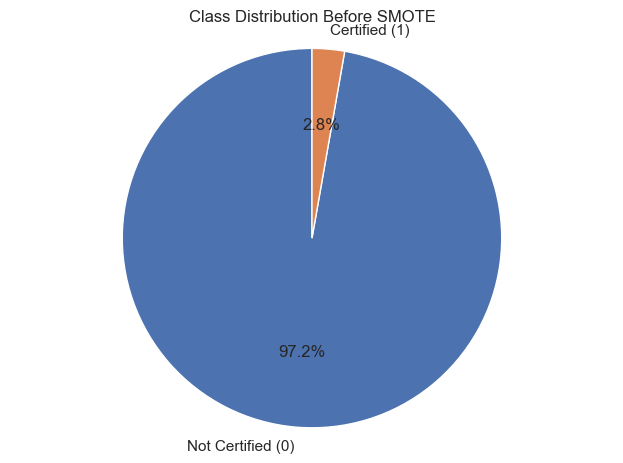

In [9]:

import matplotlib.pyplot as plt

class_counts = df["certified"].value_counts().sort_index()

labels = ["Not Certified (0)", "Certified (1)"]
sizes = class_counts.values

plt.figure()
plt.pie(
    sizes,
    labels=labels,
    autopct="%1.1f%%",
    startangle=90
)
plt.title("Class Distribution Before SMOTE")

plt.axis("equal")
plt.tight_layout()
plt.show()

In [10]:
import pandas as pd
import numpy as np

df = pd.read_csv("HMXPC13_DI_v2_5-14-14_SMOTE_BALANCED_TRAIN.csv")

print("Class distribution after SMOTE:")
print(df["certified"].value_counts().sort_index())

print("\nTotal samples:", len(df))

Class distribution after SMOTE:
certified
0    498760
1    498760
Name: count, dtype: int64

Total samples: 997520


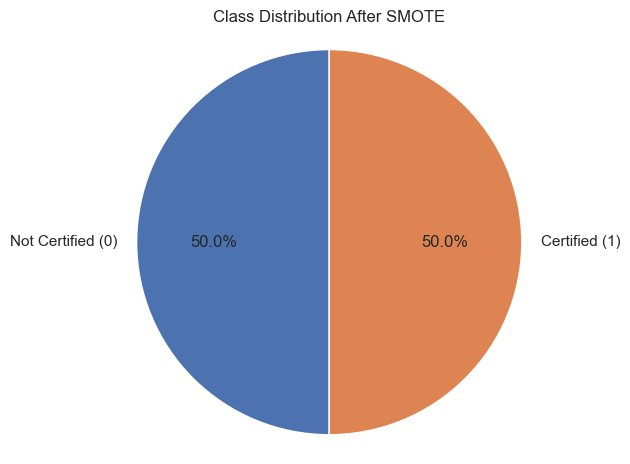

In [11]:

import matplotlib.pyplot as plt

df = pd.read_csv("HMXPC13_DI_v2_5-14-14_SMOTE_BALANCED_TRAIN.csv")

class_counts = df["certified"].value_counts().sort_index()

labels = ["Not Certified (0)", "Certified (1)"]
sizes = class_counts.values

plt.figure()
plt.pie(
    sizes,
    labels=labels,
    autopct="%1.1f%%",
    startangle=90
)
plt.title("Class Distribution After SMOTE")

plt.axis("equal")
plt.tight_layout()
plt.show()

Hyperparameters Tunning using Grid Search, Random Search and Bayesian Optimization

In [5]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, Flatten
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from skopt import gp_minimize
from skopt.space import Real, Integer

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# ---------------------------
# Reproducibility
# ---------------------------
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ---------------------------
# DATA PATH
# ---------------------------
DATA_PATH = "HMXPC13_DI_v2_5-14-14_SMOTE_BALANCED_TRAIN.csv"
TARGET_COL = "certified"

# ---------------------------
# GPU check
# ---------------------------
physical_devices = tf.config.list_physical_devices("GPU")
if physical_devices:
    print("\n Using GPU:", physical_devices[0])
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
    except Exception:
        pass
else:
    print("\n No GPU detected, using CPU.")

# ---------------------------
# Load + CLEAN data
# ---------------------------
df = pd.read_csv(DATA_PATH)

if TARGET_COL not in df.columns:
    raise ValueError(f"Target column '{TARGET_COL}' not found.")

X_df = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL].values.astype(int)

# Convert categorical/object columns to numeric via one-hot
X_df = pd.get_dummies(X_df, drop_first=False)

# ============================================================
# HYBRID FEATURE SELECTION 
# ============================================================

GA_FEAT_CSV  = "ga_selected_features_final.csv"
PSO_FEAT_CSV = "pso_selected_features_final.csv"

def extract_features(csv_path, preferred_cols=None):
    df_ = pd.read_csv(csv_path)

    if preferred_cols is None:
        preferred_cols = [
            "Feature", "Selected Feature",
            "selected_feature", "selected_features",
            "feature", "name", "column"
        ]

    series = None
    for c in preferred_cols:
        if c in df_.columns:
            series = df_[c]
            break
    if series is None:
        series = df_.iloc[:, 0]

    feats = (
        series.astype(str).str.strip()
        .replace("", pd.NA).dropna().tolist()
    )
    return list(dict.fromkeys(feats))

GA_RAW  = extract_features(GA_FEAT_CSV)
PSO_RAW = extract_features(PSO_FEAT_CSV)
HYB_BASE = list(dict.fromkeys(GA_RAW + PSO_RAW)) 

def build_hybrid_column_list(X_cols, base_features):
    cols = list(X_cols)
    colset = set(cols)

    selected = []
    missing = []

    for f in base_features:
        f = str(f).strip()
        if not f:
            continue

        # 1) exact
        if f in colset:
            selected.append(f)
            continue

        # 2) suffix match
        suf = "__" + f
        cand = [c for c in cols if c.endswith(suf)]

        # 3) one-hot expansion
        if not cand:
            pref = f + "_"
            cand = [c for c in cols if c.startswith(pref)]

        if cand:
            for c in cand:
                if c not in selected:
                    selected.append(c)
        else:
            missing.append(f)

    selected = list(dict.fromkeys(selected))
    return selected, missing

HYB_COLS, HYB_MISSING = build_hybrid_column_list(X_df.columns, HYB_BASE)

print("\n================ HYBRID FEATURE MATCH REPORT ================")
print("GA features:", len(GA_RAW), "| PSO features:", len(PSO_RAW))
print("Hybrid base (GA∪PSO):", len(HYB_BASE))
print("Matched columns in X_df:", len(HYB_COLS))
print("Missing base features:", len(HYB_MISSING))
print("Hybrid matched preview:", HYB_COLS[:25])
if HYB_MISSING:
    print("Missing preview:", HYB_MISSING[:25])

if len(HYB_COLS) == 0:
    raise ValueError("No Hybrid features matched your processed columns.")

# Apply Hybrid feature selection
X_df = X_df[HYB_COLS].copy()
print("X_df restricted to HYBRID only. New shape:", X_df.shape)

# Drop fully-NaN columns
all_nan_cols = X_df.columns[X_df.isna().all()]
if len(all_nan_cols) > 0:
    print("Dropping fully-NaN columns:", list(all_nan_cols)[:30])
    X_df = X_df.drop(columns=all_nan_cols)

# Impute + Scale
imputer = SimpleImputer(strategy="median")
X_imp = imputer.fit_transform(X_df)

scaler = StandardScaler()
X = scaler.fit_transform(X_imp).astype(np.float32)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

print("Shapes:", X_train.shape, X_test.shape)
print("Class counts train:", np.bincount(y_train), "test:", np.bincount(y_test))

# CNN reshape
def to_cnn_shape(X):
    X = np.asarray(X, dtype=np.float32)
    return X.reshape(X.shape[0], X.shape[1], 1)

X_train_cnn = to_cnn_shape(X_train)
X_test_cnn  = to_cnn_shape(X_test)

def get_dataset(X, y, batch_size):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    ds = ds.batch(int(batch_size)).prefetch(tf.data.AUTOTUNE)
    return ds

def create_cnn_model(lr, dropout, input_timesteps):
    model = Sequential([
        Input(shape=(input_timesteps, 1)),
        Conv1D(32, 5, activation="relu", padding="same"),
        Dropout(float(dropout)),
        Conv1D(16, 3, activation="relu", padding="same"),
        Dropout(float(dropout)),
        Flatten(),
        Dense(32, activation="relu"),
        Dropout(float(dropout)),
        Dense(1, activation="sigmoid")
    ])
    opt = Adam(learning_rate=float(lr), clipnorm=1.0)
    model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])
    return model

grid_params = {
     "learning_rate": [0.0005, 0.001],
     "dropout_rate": [0.1, 0.3, 0.5],
    "batch_size": [32, 64, 128],
    "epochs": [5]
}

nan_cb = tf.keras.callbacks.TerminateOnNaN()


 No GPU detected, using CPU.

================ HYBRID FEATURE MATCH REPORT ================
GA features: 4 | PSO features: 5
Hybrid base (GA∪PSO): 6
Matched columns in X_df: 6
Missing base features: 0
Hybrid matched preview: ['explored', 'ndays_act', 'nchapters', 'incomplete_flag', 'viewed', 'YoB']
X_df restricted to HYBRID only. New shape: (997520, 6)
Shapes: (798016, 6) (199504, 6)
Class counts train: [399008 399008] test: [99752 99752]


Balanced Accuracy and Macro Precision etc. Grid Search

In [6]:

import numpy as np
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    auc
)

best_grid = None
best_grid_acc = -1.0
best_grid_history = None
best_grid_model = None
best_grid_batch = None
best_grid_metrics = None

grid_results = []

print("\n====================")
print("Running Grid Search (CNN)...")
print("====================")

def eval_model(model, test_ds, y_true):
    y_prob = model.predict(test_ds, verbose=0).ravel()
    if np.isnan(y_prob).any():
        raise ValueError("NaNs found in predictions.")

    y_pred = (y_prob >= 0.5).astype(int)

    acc      = float(accuracy_score(y_true, y_pred))
    bal_acc  = float(balanced_accuracy_score(y_true, y_pred))
    prec     = float(precision_score(y_true, y_pred, zero_division=0))
    rec      = float(recall_score(y_true, y_pred, zero_division=0))
    f1       = float(f1_score(y_true, y_pred, zero_division=0))

    macro_prec = float(precision_score(y_true, y_pred, average="macro", zero_division=0))
    macro_rec  = float(recall_score(y_true, y_pred, average="macro", zero_division=0))
    macro_f1   = float(f1_score(y_true, y_pred, average="macro", zero_division=0))

    cm = confusion_matrix(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = float(auc(fpr, tpr))

    return {
        "y_prob": y_prob,
        "y_pred": y_pred,

        "acc": acc,
        "balanced_acc": bal_acc,

        "precision": prec,
        "recall": rec,
        "f1": f1,

        "macro_precision": macro_prec,
        "macro_recall": macro_rec,
        "macro_f1": macro_f1,

        "cm": cm,
        "fpr": fpr,
        "tpr": tpr,
        "roc_auc": roc_auc
    }

for lr in tqdm(grid_params["learning_rate"], desc="Grid LR"):
    for dropout in grid_params["dropout_rate"]:
        for batch in grid_params["batch_size"]:
            for epoch in grid_params["epochs"]:

                train_ds = get_dataset(X_train_cnn, y_train, batch)
                test_ds  = get_dataset(X_test_cnn,  y_test,  batch)

                model = create_cnn_model(lr, dropout, X_train_cnn.shape[1])

                history = model.fit(
                    train_ds,
                    epochs=int(epoch),
                    verbose=0,
                    callbacks=[nan_cb]
                )

                loss, acc = model.evaluate(test_ds, verbose=0)

                grid_results.append({
                    "lr": lr,
                    "dropout": dropout,
                    "batch": batch,
                    "epochs": int(epoch),
                    "acc": float(acc)
                })

                print(f"[Grid] LR={lr}, Dropout={dropout}, Batch={batch}, Epochs={epoch} → Acc: {acc:.4f}")

                if acc > best_grid_acc:
                    best_grid_acc = float(acc)
                    best_grid = {
                        "learning_rate": lr,
                        "dropout_rate": dropout,
                        "batch_size": batch,
                        "epochs": int(epoch)
                    }
                    best_grid_history = history.history
                    best_grid_model = model
                    best_grid_batch = batch

if best_grid_model is not None:
    best_grid_test_ds = get_dataset(X_test_cnn, y_test, best_grid_batch)
    best_grid_metrics = eval_model(best_grid_model, best_grid_test_ds, y_test)

print("\n Best Grid Search Params:", best_grid)
print(" Best Grid Accuracy (model.evaluate):", best_grid_acc)

if best_grid_metrics is not None:
    print("\n FINAL GRID TEST METRICS:")
    print({
        "accuracy":            best_grid_metrics["acc"],
        "balanced_accuracy":   best_grid_metrics["balanced_acc"],

        "precision":           best_grid_metrics["precision"],
        "recall":              best_grid_metrics["recall"],
        "f1":                  best_grid_metrics["f1"],

        "macro_precision":     best_grid_metrics["macro_precision"],
        "macro_recall":        best_grid_metrics["macro_recall"],
        "macro_f1":            best_grid_metrics["macro_f1"],

        "roc_auc":             best_grid_metrics["roc_auc"]
    })


Running Grid Search (CNN)...


Grid LR:   0%|          | 0/2 [00:00<?, ?it/s]

[Grid] LR=0.0005, Dropout=0.1, Batch=32, Epochs=5 → Acc: 0.9794
[Grid] LR=0.0005, Dropout=0.1, Batch=64, Epochs=5 → Acc: 0.9794
[Grid] LR=0.0005, Dropout=0.1, Batch=128, Epochs=5 → Acc: 0.9793
[Grid] LR=0.0005, Dropout=0.3, Batch=32, Epochs=5 → Acc: 0.9791
[Grid] LR=0.0005, Dropout=0.3, Batch=64, Epochs=5 → Acc: 0.9792
[Grid] LR=0.0005, Dropout=0.3, Batch=128, Epochs=5 → Acc: 0.9792
[Grid] LR=0.0005, Dropout=0.5, Batch=32, Epochs=5 → Acc: 0.9788
[Grid] LR=0.0005, Dropout=0.5, Batch=64, Epochs=5 → Acc: 0.9790


Grid LR:  50%|█████     | 1/2 [30:20<30:20, 1820.96s/it]

[Grid] LR=0.0005, Dropout=0.5, Batch=128, Epochs=5 → Acc: 0.9784
[Grid] LR=0.001, Dropout=0.1, Batch=32, Epochs=5 → Acc: 0.9795
[Grid] LR=0.001, Dropout=0.1, Batch=64, Epochs=5 → Acc: 0.9799
[Grid] LR=0.001, Dropout=0.1, Batch=128, Epochs=5 → Acc: 0.9793
[Grid] LR=0.001, Dropout=0.3, Batch=32, Epochs=5 → Acc: 0.9791
[Grid] LR=0.001, Dropout=0.3, Batch=64, Epochs=5 → Acc: 0.9791
[Grid] LR=0.001, Dropout=0.3, Batch=128, Epochs=5 → Acc: 0.9792
[Grid] LR=0.001, Dropout=0.5, Batch=32, Epochs=5 → Acc: 0.9789
[Grid] LR=0.001, Dropout=0.5, Batch=64, Epochs=5 → Acc: 0.9784


Grid LR: 100%|██████████| 2/2 [1:05:51<00:00, 1975.90s/it]

[Grid] LR=0.001, Dropout=0.5, Batch=128, Epochs=5 → Acc: 0.9788



 Best Grid Search Params: {'learning_rate': 0.001, 'dropout_rate': 0.1, 'batch_size': 64, 'epochs': 5}
 Best Grid Accuracy (model.evaluate): 0.9798500537872314

 FINAL GRID TEST METRICS:
{'accuracy': 0.9798500280696126, 'balanced_accuracy': 0.9798500280696126, 'precision': 0.9683378341356502, 'recall': 0.9921405084609832, 'f1': 0.980094674087425, 'macro_precision': 0.9801401400894079, 'macro_recall': 0.9798500280696126, 'macro_f1': 0.9798469838374522, 'roc_auc': 0.995730323364105}


5-FOLD CV (FIXED HYPERPARAMETERS) + 95% CI (for Grid Search Method)

In [15]:

import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score,
    precision_score, recall_score, f1_score,
    roc_auc_score
)
from scipy import stats

LR       = 0.001
DROPOUT  = 0.1
BATCH    = 128
EPOCHS   = 5

def eval_model_metrics(model, ds, y_true):
    y_prob = model.predict(ds, verbose=0).ravel().astype(float)
    y_pred = (y_prob >= 0.5).astype(int)

    acc = float(accuracy_score(y_true, y_pred))
    bal_acc = float(balanced_accuracy_score(y_true, y_pred))

    mac_prec = float(precision_score(y_true, y_pred, average="macro", zero_division=0))
    mac_rec  = float(recall_score(y_true, y_pred, average="macro", zero_division=0))
    mac_f1   = float(f1_score(y_true, y_pred, average="macro", zero_division=0))

    if len(np.unique(y_true)) < 2:
        auc = np.nan
    else:
        auc = float(roc_auc_score(y_true, y_prob))

    return acc, bal_acc, mac_prec, mac_rec, mac_f1, auc

def ci95(values):
    values = np.asarray(values, dtype=float)
    values = values[~np.isnan(values)]
    n = len(values)

    if n == 0:
        return (np.nan, np.nan, np.nan)

    mean = float(values.mean())
    if n < 2:
        return (mean, mean, mean)

    std = float(values.std(ddof=1))
    se = std / np.sqrt(n)
    t_val = stats.t.ppf(0.975, df=n - 1)
    half = t_val * se

    return (mean, mean - half, mean + half)

K = 5
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

fold_acc = []
fold_bal_acc = []
fold_mac_prec = []
fold_mac_rec = []
fold_mac_f1 = []
fold_auc = []

print("\n====================")
print("Running 5-Fold CV (CNN) with FIXED hyperparameters...")
print("====================")

for fold, (tr_idx, va_idx) in enumerate(skf.split(X_train_cnn, y_train), start=1):

    X_tr, y_tr = X_train_cnn[tr_idx], y_train[tr_idx]
    X_va, y_va = X_train_cnn[va_idx], y_train[va_idx]

    train_ds = get_dataset(X_tr, y_tr, BATCH)
    val_ds   = get_dataset(X_va, y_va, BATCH)

    model = create_cnn_model(LR, DROPOUT, X_train_cnn.shape[1])

    model.fit(
        train_ds,
        epochs=EPOCHS,
        verbose=0,
        callbacks=[nan_cb]
    )

    acc, bal_acc, mac_prec, mac_rec, mac_f1, auc = eval_model_metrics(model, val_ds, y_va)

    fold_acc.append(acc)
    fold_bal_acc.append(bal_acc)
    fold_mac_prec.append(mac_prec)
    fold_mac_rec.append(mac_rec)
    fold_mac_f1.append(mac_f1)
    fold_auc.append(auc)

    print(
        f"Fold {fold}: "
        f"Acc={acc:.4f}, BalAcc={bal_acc:.4f}, "
        f"MacPrec={mac_prec:.4f}, MacRec={mac_rec:.4f}, MacF1={mac_f1:.4f}, "
        f"AUC={auc:.4f}" if not np.isnan(auc) else
        f"Fold {fold}: "
        f"Acc={acc:.4f}, BalAcc={bal_acc:.4f}, "
        f"MacPrec={mac_prec:.4f}, MacRec={mac_rec:.4f}, MacF1={mac_f1:.4f}, "
        f"AUC=nan (single class in fold)"
    )

results_ci = {
    "accuracy_mean_CI": ci95(fold_acc),
    "balanced_accuracy_mean_CI": ci95(fold_bal_acc),
    "macro_precision_mean_CI": ci95(fold_mac_prec),
    "macro_recall_mean_CI": ci95(fold_mac_rec),
    "macro_f1_mean_CI": ci95(fold_mac_f1),
    "auc_roc_mean_CI": ci95(fold_auc),
}

print("\n 5-Fold CV Results (95% CI):")
print(results_ci)

final_train_ds = get_dataset(X_train_cnn, y_train, BATCH)
final_test_ds  = get_dataset(X_test_cnn,  y_test,  BATCH)

final_model = create_cnn_model(LR, DROPOUT, X_train_cnn.shape[1])

final_model.fit(
    final_train_ds,
    epochs=EPOCHS,
    verbose=0,
    callbacks=[nan_cb]
)

test_acc, test_bal_acc, test_mac_prec, test_mac_rec, test_mac_f1, test_auc = eval_model_metrics(
    final_model, final_test_ds, y_test
)

print("\n FINAL TEST METRICS (single run, no CI):")
print({
    "accuracy": test_acc,
    "balanced_accuracy": test_bal_acc,
    "macro_precision": test_mac_prec,
    "macro_recall": test_mac_rec,
    "macro_f1": test_mac_f1,
    "auc_roc": test_auc
})


Running 5-Fold CV (CNN) with FIXED hyperparameters...
Fold 1: Acc=0.9788, BalAcc=0.9788, MacPrec=0.9790, MacRec=0.9788, MacF1=0.9788, AUC=0.9952
Fold 2: Acc=0.9791, BalAcc=0.9791, MacPrec=0.9793, MacRec=0.9791, MacF1=0.9791, AUC=0.9954
Fold 3: Acc=0.9791, BalAcc=0.9791, MacPrec=0.9795, MacRec=0.9791, MacF1=0.9791, AUC=0.9952
Fold 4: Acc=0.9787, BalAcc=0.9787, MacPrec=0.9790, MacRec=0.9787, MacF1=0.9787, AUC=0.9954
Fold 5: Acc=0.9790, BalAcc=0.9790, MacPrec=0.9793, MacRec=0.9790, MacF1=0.9790, AUC=0.9954

 5-Fold CV Results (95% CI):
{'accuracy_mean_CI': (0.9789415252016612, np.float64(0.9787028514565616), np.float64(0.9791801989467609)), 'balanced_accuracy_mean_CI': (0.97894152752502, np.float64(0.9787029196603437), np.float64(0.9791801353896962)), 'macro_precision_mean_CI': (0.9792314807616351, np.float64(0.9789891096864589), np.float64(0.9794738518368113)), 'macro_recall_mean_CI': (0.97894152752502, np.float64(0.9787029196603437), np.float64(0.9791801353896962)), 'macro_f1_mean_CI':

Balance Accuracy, Macro Precision, Macro Recall etc. Random Search Method

In [10]:

import numpy as np
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    auc
)

print("\n====================")
print("Running Random Search (CNN)...")
print("====================")

def eval_model(model, test_ds, y_true):
    y_prob = model.predict(test_ds, verbose=0).ravel()
    if np.isnan(y_prob).any():
        raise ValueError("NaNs found in predictions.")

    y_pred = (y_prob >= 0.5).astype(int)

    acc     = float(accuracy_score(y_true, y_pred))
    bal_acc = float(balanced_accuracy_score(y_true, y_pred))

    prec = float(precision_score(y_true, y_pred, zero_division=0))
    rec  = float(recall_score(y_true, y_pred, zero_division=0))
    f1   = float(f1_score(y_true, y_pred, zero_division=0))

    macro_prec = float(precision_score(y_true, y_pred, average="macro", zero_division=0))
    macro_rec  = float(recall_score(y_true, y_pred, average="macro", zero_division=0))
    macro_f1   = float(f1_score(y_true, y_pred, average="macro", zero_division=0))

    cm = confusion_matrix(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = float(auc(fpr, tpr))

    return {
        "y_prob": y_prob, "y_pred": y_pred,
        "acc": acc,
        "balanced_acc": bal_acc,
        "precision": prec, "recall": rec, "f1": f1,
        "macro_precision": macro_prec,
        "macro_recall": macro_rec,
        "macro_f1": macro_f1,
        "cm": cm, "fpr": fpr, "tpr": tpr, "roc_auc": roc_auc
    }

random_params = {k: random.choice(v) for k, v in grid_params.items()}

if isinstance(random_params["epochs"], list):
    random_params["epochs"] = int(random_params["epochs"][0])

rand_train_ds = get_dataset(X_train_cnn, y_train, random_params["batch_size"])
rand_test_ds  = get_dataset(X_test_cnn,  y_test,  random_params["batch_size"])

random_model = create_cnn_model(
    random_params["learning_rate"],
    random_params["dropout_rate"],
    X_train_cnn.shape[1]
)

random_history = random_model.fit(
    rand_train_ds,
    epochs=int(random_params["epochs"]),
    verbose=0,
    callbacks=[nan_cb]
).history

random_metrics = eval_model(random_model, rand_test_ds, y_test)

print("\n [Random] Best Params:", random_params)
print(" [Random] Test Accuracy (model.evaluate):",
      float(random_model.evaluate(rand_test_ds, verbose=0)[1]))

print("\n FINAL RANDOM TEST METRICS:")
print({
    "accuracy":           random_metrics["acc"],
    "balanced_accuracy":  random_metrics["balanced_acc"],

    "precision":          random_metrics["precision"],
    "recall":             random_metrics["recall"],
    "f1":                 random_metrics["f1"],

    "macro_precision":    random_metrics["macro_precision"],
    "macro_recall":       random_metrics["macro_recall"],
    "macro_f1":           random_metrics["macro_f1"],

    "roc_auc":            random_metrics["roc_auc"]
})


Running Random Search (CNN)...

 [Random] Best Params: {'learning_rate': 0.0005, 'dropout_rate': 0.1, 'batch_size': 64, 'epochs': 5}
 [Random] Test Accuracy (model.evaluate): 0.9793086647987366

 FINAL RANDOM TEST METRICS:
{'accuracy': 0.9793086855401395, 'balanced_accuracy': 0.9793086855401395, 'precision': 0.9678094790810535, 'recall': 0.9915991659315101, 'f1': 0.9795599041375349, 'macro_precision': 0.9795984702702287, 'macro_recall': 0.9793086855401395, 'macro_f1': 0.9793055595226374, 'roc_auc': 0.9954292991855989}


5-FOLD CV (FIXED HYPERPARAMETERS) + 95% CI (for Random Search Method)


In [4]:

import numpy as np
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    roc_auc_score
)
from scipy import stats

print("\n====================")
print("Running Random Search (CNN) + 5-Fold CV CI + Final Test...")
print("====================")

def eval_from_probs(y_true, y_prob, thr=0.5):
    y_prob = np.asarray(y_prob, dtype=float).ravel()
    y_pred = (y_prob >= thr).astype(int)

    acc     = float(accuracy_score(y_true, y_pred))
    bal_acc = float(balanced_accuracy_score(y_true, y_pred))

    macro_prec = float(precision_score(y_true, y_pred, average="macro", zero_division=0))
    macro_rec  = float(recall_score(y_true, y_pred, average="macro", zero_division=0))
    macro_f1   = float(f1_score(y_true, y_pred, average="macro", zero_division=0))

    if len(np.unique(y_true)) < 2:
        auc_roc = np.nan
    else:
        auc_roc = float(roc_auc_score(y_true, y_prob))

    return acc, bal_acc, macro_prec, macro_rec, macro_f1, auc_roc, y_pred

def eval_model(model, ds, y_true):
    y_prob = model.predict(ds, verbose=0).ravel().astype(float)
    if np.isnan(y_prob).any():
        raise ValueError("NaNs found in predictions.")
    return eval_from_probs(y_true, y_prob)

def ci95(values):
    values = np.asarray(values, dtype=float)
    values = values[~np.isnan(values)]
    n = len(values)

    if n == 0:
        return (np.nan, np.nan, np.nan)

    mean = float(values.mean())
    if n < 2:
        return (mean, mean, mean)

    std = float(values.std(ddof=1))
    se = std / np.sqrt(n)
    t_val = stats.t.ppf(0.975, df=n - 1)
    half = t_val * se

    return (mean, mean - half, mean + half)

random_params = {k: random.choice(v) for k, v in grid_params.items()}
if isinstance(random_params.get("epochs"), list):
    random_params["epochs"] = int(random_params["epochs"][0])

print("\n [Random] Params chosen:", random_params)

K = 5
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

fold_acc, fold_bal = [], []
fold_mprec, fold_mrec, fold_mf1 = [], [], []
fold_auc = []

print("\n====================")
print("5-Fold CV (for 95% CI) using RANDOM params...")
print("====================")

for fold, (tr_idx, va_idx) in enumerate(skf.split(X_train_cnn, y_train), start=1):
    X_tr, y_tr = X_train_cnn[tr_idx], y_train[tr_idx]
    X_va, y_va = X_train_cnn[va_idx], y_train[va_idx]

    tr_ds = get_dataset(X_tr, y_tr, random_params["batch_size"])
    va_ds = get_dataset(X_va, y_va, random_params["batch_size"])

    model = create_cnn_model(
        random_params["learning_rate"],
        random_params["dropout_rate"],
        X_train_cnn.shape[1]
    )

    model.fit(
        tr_ds,
        epochs=int(random_params["epochs"]),
        verbose=0,
        callbacks=[nan_cb]
    )

    acc, bal, mprec, mrec, mf1, auc_roc, _ = eval_model(model, va_ds, y_va)

    fold_acc.append(acc)
    fold_bal.append(bal)
    fold_mprec.append(mprec)
    fold_mrec.append(mrec)
    fold_mf1.append(mf1)
    fold_auc.append(auc_roc)

    print(
        f"Fold {fold}: Acc={acc:.4f}, BalAcc={bal:.4f}, "
        f"MacPrec={mprec:.4f}, MacRec={mrec:.4f}, MacF1={mf1:.4f}, "
        f"AUC={auc_roc:.4f}" if not np.isnan(auc_roc) else
        f"Fold {fold}: Acc={acc:.4f}, BalAcc={bal:.4f}, "
        f"MacPrec={mprec:.4f}, MacRec={mrec:.4f}, MacF1={mf1:.4f}, AUC=nan"
    )

cv_ci = {
    "accuracy_mean_CI":            ci95(fold_acc),
    "balanced_accuracy_mean_CI":   ci95(fold_bal),
    "macro_precision_mean_CI":     ci95(fold_mprec),
    "macro_recall_mean_CI":        ci95(fold_mrec),
    "macro_f1_mean_CI":            ci95(fold_mf1),
    "auc_roc_mean_CI":             ci95(fold_auc),
}

print("\n 5-Fold CV Results (95% CI) for RANDOM params:")
print(cv_ci)

final_train_ds = get_dataset(X_train_cnn, y_train, random_params["batch_size"])
final_test_ds  = get_dataset(X_test_cnn,  y_test,  random_params["batch_size"])

final_model = create_cnn_model(
    random_params["learning_rate"],
    random_params["dropout_rate"],
    X_train_cnn.shape[1]
)

final_model.fit(
    final_train_ds,
    epochs=int(random_params["epochs"]),
    verbose=0,
    callbacks=[nan_cb]
)

y_prob_test = final_model.predict(final_test_ds, verbose=0).ravel().astype(float)
if np.isnan(y_prob_test).any():
    raise ValueError("NaNs found in TEST predictions.")

test_acc, test_bal, test_mprec, test_mrec, test_mf1, test_auc, y_pred_test = eval_from_probs(
    y_test, y_prob_test
)

if len(np.unique(y_test)) < 2:
    fpr, tpr = None, None
else:
    fpr, tpr, _ = roc_curve(y_test, y_prob_test)

print("\n [Random] Test Accuracy (model.evaluate):",
      float(final_model.evaluate(final_test_ds, verbose=0)[1]))

print("\n FINAL TEST METRICS (single run, no CI):")
print({
    "accuracy":          test_acc,
    "balanced_accuracy": test_bal,
    "macro_precision":   test_mprec,
    "macro_recall":      test_mrec,
    "macro_f1":          test_mf1,
    "auc_roc":           test_auc
})


Running Random Search (CNN) + 5-Fold CV CI + Final Test...

 [Random] Params chosen: {'learning_rate': 0.0005, 'dropout_rate': 0.5, 'batch_size': 64, 'epochs': 5}

5-Fold CV (for 95% CI) using RANDOM params...
Fold 1: Acc=0.9778, BalAcc=0.9778, MacPrec=0.9781, MacRec=0.9778, MacF1=0.9778, AUC=0.9945
Fold 2: Acc=0.9787, BalAcc=0.9787, MacPrec=0.9790, MacRec=0.9787, MacF1=0.9786, AUC=0.9948
Fold 3: Acc=0.9781, BalAcc=0.9781, MacPrec=0.9785, MacRec=0.9781, MacF1=0.9781, AUC=0.9946
Fold 4: Acc=0.9781, BalAcc=0.9781, MacPrec=0.9784, MacRec=0.9781, MacF1=0.9781, AUC=0.9948
Fold 5: Acc=0.9782, BalAcc=0.9782, MacPrec=0.9785, MacRec=0.9782, MacF1=0.9782, AUC=0.9946

 5-Fold CV Results (95% CI) for RANDOM params:
{'accuracy_mean_CI': (0.9781595862138259, np.float64(0.9777767902993063), np.float64(0.9785423821283455)), 'balanced_accuracy_mean_CI': (0.9781595833787821, np.float64(0.9777768244320694), np.float64(0.9785423423254948)), 'macro_precision_mean_CI': (0.9785069889031274, np.float64(0.978

In [5]:

import numpy as np
import random
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    auc,
    roc_auc_score
)

print("\n====================")
print("Running Random Search (CNN)...")
print("====================")

def eval_model(model, test_ds, y_true):
    y_prob = model.predict(test_ds, verbose=0).ravel().astype(float)
    if np.isnan(y_prob).any():
        raise ValueError("NaNs found in predictions.")

    y_pred = (y_prob >= 0.5).astype(int)

    acc     = float(accuracy_score(y_true, y_pred))
    bal_acc = float(balanced_accuracy_score(y_true, y_pred))

    prec = float(precision_score(y_true, y_pred, zero_division=0))
    rec  = float(recall_score(y_true, y_pred, zero_division=0))
    f1   = float(f1_score(y_true, y_pred, zero_division=0))

    macro_prec = float(precision_score(y_true, y_pred, average="macro", zero_division=0))
    macro_rec  = float(recall_score(y_true, y_pred, average="macro", zero_division=0))
    macro_f1   = float(f1_score(y_true, y_pred, average="macro", zero_division=0))

    cm = confusion_matrix(y_true, y_pred)

    if len(np.unique(y_true)) < 2:
        fpr, tpr, roc_auc = None, None, np.nan
    else:
        roc_auc = float(roc_auc_score(y_true, y_prob))

        fpr, tpr, _ = roc_curve(y_true, y_prob)


    return {
        "y_prob": y_prob,
        "y_pred": y_pred,

        "acc": acc,
        "balanced_acc": bal_acc,

        "precision": prec,
        "recall": rec,
        "f1": f1,

        "macro_precision": macro_prec,
        "macro_recall": macro_rec,
        "macro_f1": macro_f1,

        "cm": cm,
        "fpr": fpr,
        "tpr": tpr,
        "roc_auc": roc_auc
    }

random_params = {k: random.choice(v) for k, v in grid_params.items()}

if isinstance(random_params.get("epochs"), list):
    random_params["epochs"] = int(random_params["epochs"][0])

rand_train_ds = get_dataset(X_train_cnn, y_train, random_params["batch_size"])
rand_test_ds  = get_dataset(X_test_cnn,  y_test,  random_params["batch_size"])

random_model = create_cnn_model(
    random_params["learning_rate"],
    random_params["dropout_rate"],
    X_train_cnn.shape[1]
)

random_history = random_model.fit(
    rand_train_ds,
    epochs=int(random_params["epochs"]),
    verbose=0,
    callbacks=[nan_cb]
).history

random_metrics = eval_model(random_model, rand_test_ds, y_test)

print("\n [Random] Best Params:", random_params)
print(" [Random] Test Accuracy (model.evaluate):",
      float(random_model.evaluate(rand_test_ds, verbose=0)[1]))

print("\n FINAL RANDOM TEST METRICS:")
print({
    "accuracy":           random_metrics["acc"],
    "balanced_accuracy":  random_metrics["balanced_acc"],

    "precision":          random_metrics["precision"],
    "recall":             random_metrics["recall"],
    "f1":                 random_metrics["f1"],

    "macro_precision":    random_metrics["macro_precision"],
    "macro_recall":       random_metrics["macro_recall"],
    "macro_f1":           random_metrics["macro_f1"],

    "roc_auc":            random_metrics["roc_auc"]
})


Running Random Search (CNN)...

 [Random] Best Params: {'learning_rate': 0.0005, 'dropout_rate': 0.5, 'batch_size': 64, 'epochs': 5}
 [Random] Test Accuracy (model.evaluate): 0.9787423014640808

 FINAL RANDOM TEST METRICS:
{'accuracy': 0.9787422808565241, 'balanced_accuracy': 0.9787422808565243, 'precision': 0.9668227450903724, 'recall': 0.991508942176598, 'f1': 0.9790102498874047, 'macro_precision': 0.9790546007741867, 'macro_recall': 0.9787422808565243, 'macro_f1': 0.9787388155462197, 'roc_auc': 0.9949093921443103}


In [6]:

print("\n====================")
print("Running Bayesian Optimization (CNN) (skopt gp_minimize)...")
print("====================")

def objective(params):
    lr, dropout, batch = params
    epochs = 5

    train_ds = get_dataset(X_train_cnn, y_train, batch)
    test_ds  = get_dataset(X_test_cnn,  y_test,  batch)

    model = create_cnn_model(lr, dropout, X_train_cnn.shape[1])
    model.fit(train_ds, epochs=epochs, verbose=0, callbacks=[nan_cb])

    loss, acc = model.evaluate(test_ds, verbose=0)

    if np.isnan(acc):
        print(f"[Bayesian] NaN acc → penalizing. LR={lr}, Dropout={dropout}, Batch={batch}")
        return 1.0

    print(f"[Bayesian] LR={lr:.6f}, Dropout={dropout:.2f}, Batch={int(batch)} → Acc: {acc:.4f}")
    return -float(acc)

search_space = [
    Real(1e-4, 5e-3, prior="log-uniform", name="learning_rate"),
    Real(0.1, 0.6, name="dropout_rate"),
    Integer(32, 128, name="batch_size")
]

bayesian_result = gp_minimize(
    func=objective,
    dimensions=search_space,
    n_calls=15,
    n_initial_points=5,
    random_state=SEED
)

best_bayesian = {
    "learning_rate": float(bayesian_result.x[0]),
    "dropout_rate":  float(bayesian_result.x[1]),
    "batch_size":    int(bayesian_result.x[2]),
    "epochs":        10
}
print("\n Best Bayesian Params (final training):", best_bayesian)

bayesian_batch = best_bayesian["batch_size"]
train_ds = get_dataset(X_train_cnn, y_train, bayesian_batch)
test_ds  = get_dataset(X_test_cnn,  y_test,  bayesian_batch)

bayesian_model = create_cnn_model(
    best_bayesian["learning_rate"],
    best_bayesian["dropout_rate"],
    X_train_cnn.shape[1]
)

bayesian_history = bayesian_model.fit(
    train_ds,
    epochs=int(best_bayesian["epochs"]),
    verbose=0,
    callbacks=[nan_cb]
).history

bayesian_acc = bayesian_model.evaluate(test_ds, verbose=0)[1]
print(f"\n [Bayesian Final] Test Accuracy: {bayesian_acc:.4f}")


Running Bayesian Optimization (CNN) (skopt gp_minimize)...
[Bayesian] LR=0.002256, Dropout=0.19, Batch=107 → Acc: 0.9793
[Bayesian] LR=0.001033, Dropout=0.32, Batch=42 → Acc: 0.9790
[Bayesian] LR=0.000603, Dropout=0.27, Batch=46 → Acc: 0.9791
[Bayesian] LR=0.001276, Dropout=0.13, Batch=101 → Acc: 0.9797
[Bayesian] LR=0.003932, Dropout=0.10, Batch=127 → Acc: 0.9786
[Bayesian] LR=0.000476, Dropout=0.11, Batch=88 → Acc: 0.9795
[Bayesian] LR=0.000102, Dropout=0.58, Batch=68 → Acc: 0.9784
[Bayesian] LR=0.000164, Dropout=0.30, Batch=96 → Acc: 0.9790
[Bayesian] LR=0.001959, Dropout=0.10, Batch=84 → Acc: 0.9794
[Bayesian] LR=0.003191, Dropout=0.60, Batch=128 → Acc: 0.9785
[Bayesian] LR=0.000645, Dropout=0.56, Batch=102 → Acc: 0.9787
[Bayesian] LR=0.000100, Dropout=0.10, Batch=104 → Acc: 0.9791
[Bayesian] LR=0.004852, Dropout=0.59, Batch=65 → Acc: 0.9784
[Bayesian] LR=0.000623, Dropout=0.16, Batch=32 → Acc: 0.9792
[Bayesian] LR=0.003812, Dropout=0.15, Batch=90 → Acc: 0.9795

 Best Bayesian Par

Balanced Accuracy, Macro Precision, Macro Recall and Macro F1-score for Bayesian Optimization

In [7]:

import numpy as np
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    auc
)

print("\n====================")
print("Running Bayesian Optimization (CNN) (skopt gp_minimize)...")
print("====================")

def eval_model(model, test_ds, y_true):
    y_prob = model.predict(test_ds, verbose=0).ravel()
    if np.isnan(y_prob).any():
        raise ValueError("NaNs found in predictions.")

    y_pred = (y_prob >= 0.5).astype(int)

    acc     = float(accuracy_score(y_true, y_pred))
    bal_acc = float(balanced_accuracy_score(y_true, y_pred))

    prec = float(precision_score(y_true, y_pred, zero_division=0))
    rec  = float(recall_score(y_true, y_pred, zero_division=0))
    f1   = float(f1_score(y_true, y_pred, zero_division=0))

    macro_prec = float(precision_score(y_true, y_pred, average="macro", zero_division=0))
    macro_rec  = float(recall_score(y_true, y_pred, average="macro", zero_division=0))
    macro_f1   = float(f1_score(y_true, y_pred, average="macro", zero_division=0))

    cm = confusion_matrix(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = float(auc(fpr, tpr))

    return {
        "y_prob": y_prob, "y_pred": y_pred,
        "acc": acc,
        "balanced_acc": bal_acc,
        "precision": prec, "recall": rec, "f1": f1,
        "macro_precision": macro_prec,
        "macro_recall": macro_rec,
        "macro_f1": macro_f1,
        "cm": cm, "fpr": fpr, "tpr": tpr, "roc_auc": roc_auc
    }

def objective(params):
    lr, dropout, batch = params
    epochs = 5

    train_ds = get_dataset(X_train_cnn, y_train, int(batch))
    test_ds  = get_dataset(X_test_cnn,  y_test,  int(batch))

    model = create_cnn_model(lr, dropout, X_train_cnn.shape[1])
    model.fit(train_ds, epochs=epochs, verbose=0, callbacks=[nan_cb])

    loss, acc = model.evaluate(test_ds, verbose=0)

    if np.isnan(acc):
        print(f"[Bayesian] NaN acc → penalizing. LR={lr}, Dropout={dropout}, Batch={int(batch)}")
        return 1.0

    print(f"[Bayesian] LR={lr:.6f}, Dropout={dropout:.2f}, Batch={int(batch)} → Acc: {acc:.4f}")
    return -float(acc)

search_space = [
    Real(1e-4, 5e-3, prior="log-uniform", name="learning_rate"),
    Real(0.1, 0.6, name="dropout_rate"),
    Integer(32, 128, name="batch_size")
]

bayesian_result = gp_minimize(
    func=objective,
    dimensions=search_space,
    n_calls=15,
    n_initial_points=5,
    random_state=SEED
)

best_bayesian = {
    "learning_rate": float(bayesian_result.x[0]),
    "dropout_rate":  float(bayesian_result.x[1]),
    "batch_size":    int(bayesian_result.x[2]),
    "epochs":        10
}
print("\n Best Bayesian Params (final training):", best_bayesian)

bayesian_batch = best_bayesian["batch_size"]
train_ds = get_dataset(X_train_cnn, y_train, bayesian_batch)
test_ds  = get_dataset(X_test_cnn,  y_test,  bayesian_batch)

bayesian_model = create_cnn_model(
    best_bayesian["learning_rate"],
    best_bayesian["dropout_rate"],
    X_train_cnn.shape[1]
)

bayesian_history = bayesian_model.fit(
    train_ds,
    epochs=int(best_bayesian["epochs"]),
    verbose=0,
    callbacks=[nan_cb]
).history

bayesian_metrics = eval_model(bayesian_model, test_ds, y_test)

bayesian_acc = float(bayesian_model.evaluate(test_ds, verbose=0)[1])
print(f"\n [Bayesian Final] Test Accuracy (model.evaluate): {bayesian_acc:.4f}")

print("\n FINAL BAYESIAN TEST METRICS:")
print({
    "accuracy":           bayesian_metrics["acc"],
    "balanced_accuracy":  bayesian_metrics["balanced_acc"],

    "precision":          bayesian_metrics["precision"],
    "recall":             bayesian_metrics["recall"],
    "f1":                 bayesian_metrics["f1"],

    "macro_precision":    bayesian_metrics["macro_precision"],
    "macro_recall":       bayesian_metrics["macro_recall"],
    "macro_f1":           bayesian_metrics["macro_f1"],

    "roc_auc":            bayesian_metrics["roc_auc"]
})


Running Bayesian Optimization (CNN) (skopt gp_minimize)...
[Bayesian] LR=0.002256, Dropout=0.19, Batch=107 → Acc: 0.9792
[Bayesian] LR=0.001033, Dropout=0.32, Batch=42 → Acc: 0.9790
[Bayesian] LR=0.000603, Dropout=0.27, Batch=46 → Acc: 0.9790
[Bayesian] LR=0.001276, Dropout=0.13, Batch=101 → Acc: 0.9795
[Bayesian] LR=0.003932, Dropout=0.10, Batch=127 → Acc: 0.9795
[Bayesian] LR=0.000110, Dropout=0.60, Batch=76 → Acc: 0.9783
[Bayesian] LR=0.000141, Dropout=0.10, Batch=33 → Acc: 0.9791
[Bayesian] LR=0.002353, Dropout=0.23, Batch=84 → Acc: 0.9791
[Bayesian] LR=0.000622, Dropout=0.44, Batch=128 → Acc: 0.9788
[Bayesian] LR=0.004963, Dropout=0.59, Batch=58 → Acc: 0.9769
[Bayesian] LR=0.001452, Dropout=0.10, Batch=34 → Acc: 0.9793
[Bayesian] LR=0.000492, Dropout=0.10, Batch=128 → Acc: 0.9793
[Bayesian] LR=0.000101, Dropout=0.39, Batch=121 → Acc: 0.9785
[Bayesian] LR=0.000102, Dropout=0.51, Batch=36 → Acc: 0.9786
[Bayesian] LR=0.005000, Dropout=0.14, Batch=128 → Acc: 0.9793

 Best Bayesian Pa

Confusion Matrix of Hybrid CA-GP + Bayesian Optimization Model


 Confusion Matrix (Bayesian - Test Set):
 [[96268  3484]
 [  627 99125]]


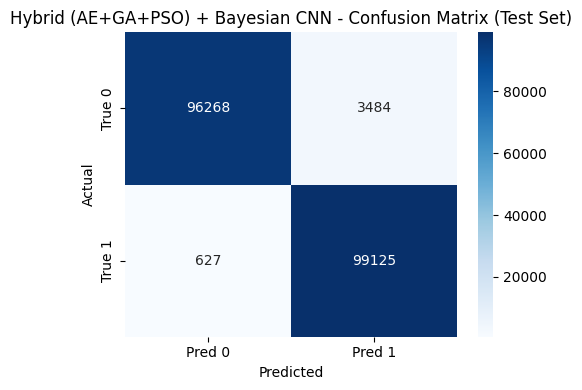

In [8]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

if "bayesian_model" not in globals():
    raise NameError("bayesian_model not found. Run the Bayesian training cell first.")
if "test_ds" not in globals():
    raise NameError("test_ds not found. Ensure you created test_ds using bayesian_batch.")
if "y_test" not in globals():
    raise NameError("y_test not found. Ensure train_test_split ran successfully.")

y_prob = bayesian_model.predict(test_ds, verbose=0).ravel().astype(float)
y_pred = (y_prob >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
print("\n Confusion Matrix (Bayesian - Test Set):\n", cm)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["True 0", "True 1"])
plt.title("Hybrid (AE+GA+PSO) + Bayesian CNN - Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

5-FOLD CV (FIXED HYPERPARAMETERS) + 95% CI (for Hybrid CA-GP + Bayesian Optimization)

In [9]:

import numpy as np
from scipy import stats
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    roc_auc_score
)

print("\n====================")
print("Running Bayesian Optimization (CNN) (skopt gp_minimize)...")
print("====================")

def eval_from_probs(y_true, y_prob, thr=0.5):
    y_prob = np.asarray(y_prob, dtype=float).ravel()
    y_pred = (y_prob >= thr).astype(int)

    acc     = float(accuracy_score(y_true, y_pred))
    bal_acc = float(balanced_accuracy_score(y_true, y_pred))

    macro_prec = float(precision_score(y_true, y_pred, average="macro", zero_division=0))
    macro_rec  = float(recall_score(y_true, y_pred, average="macro", zero_division=0))
    macro_f1   = float(f1_score(y_true, y_pred, average="macro", zero_division=0))

    if len(np.unique(y_true)) < 2:
        auc_roc = np.nan
    else:
        auc_roc = float(roc_auc_score(y_true, y_prob))

    cm = confusion_matrix(y_true, y_pred)

    return acc, bal_acc, macro_prec, macro_rec, macro_f1, auc_roc, cm, y_pred

def eval_model(model, ds, y_true):
    y_prob = model.predict(ds, verbose=0).ravel().astype(float)
    if np.isnan(y_prob).any():
        raise ValueError("NaNs found in predictions.")
    return eval_from_probs(y_true, y_prob)

def ci95(values):
    values = np.asarray(values, dtype=float)
    values = values[~np.isnan(values)]
    n = len(values)

    if n == 0:
        return (np.nan, np.nan, np.nan)

    mean = float(values.mean())
    if n < 2:
        return (mean, mean, mean)

    std = float(values.std(ddof=1))
    se = std / np.sqrt(n)
    t_val = stats.t.ppf(0.975, df=n - 1)
    half = t_val * se
    return (mean, mean - half, mean + half)

def objective(params):
    lr, dropout, batch = params
    epochs = 5

    train_ds = get_dataset(X_train_cnn, y_train, int(batch))
    test_ds  = get_dataset(X_test_cnn,  y_test,  int(batch))

    model = create_cnn_model(lr, dropout, X_train_cnn.shape[1])
    model.fit(train_ds, epochs=epochs, verbose=0, callbacks=[nan_cb])

    loss, acc = model.evaluate(test_ds, verbose=0)

    if np.isnan(acc):
        print(f"[Bayesian] NaN acc → penalizing. LR={lr}, Dropout={dropout}, Batch={int(batch)}")
        return 1.0

    print(f"[Bayesian] LR={lr:.6f}, Dropout={dropout:.2f}, Batch={int(batch)} → Acc: {acc:.4f}")
    return -float(acc)

search_space = [
    Real(1e-4, 5e-3, prior="log-uniform", name="learning_rate"),
    Real(0.1, 0.6, name="dropout_rate"),
    Integer(32, 128, name="batch_size")
]

bayesian_result = gp_minimize(
    func=objective,
    dimensions=search_space,
    n_calls=15,
    n_initial_points=5,
    random_state=SEED
)

best_bayesian = {
    "learning_rate": float(bayesian_result.x[0]),
    "dropout_rate":  float(bayesian_result.x[1]),
    "batch_size":    int(bayesian_result.x[2]),
    "epochs":        10
}
print("\n Best Bayesian Params (final training):", best_bayesian)

K = 5
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

fold_acc, fold_bal = [], []
fold_mprec, fold_mrec, fold_mf1 = [], [], []
fold_auc = []

print("\n====================")
print("5-Fold CV (for 95% CI) using BEST Bayesian params...")
print("====================")

for fold, (tr_idx, va_idx) in enumerate(skf.split(X_train_cnn, y_train), start=1):
    X_tr, y_tr = X_train_cnn[tr_idx], y_train[tr_idx]
    X_va, y_va = X_train_cnn[va_idx], y_train[va_idx]

    tr_ds = get_dataset(X_tr, y_tr, best_bayesian["batch_size"])
    va_ds = get_dataset(X_va, y_va, best_bayesian["batch_size"])

    model = create_cnn_model(
        best_bayesian["learning_rate"],
        best_bayesian["dropout_rate"],
        X_train_cnn.shape[1]
    )

    model.fit(
        tr_ds,
        epochs=int(best_bayesian["epochs"]),
        verbose=0,
        callbacks=[nan_cb]
    )

    acc, bal, mprec, mrec, mf1, auc_roc, _, _ = eval_model(model, va_ds, y_va)

    fold_acc.append(acc)
    fold_bal.append(bal)
    fold_mprec.append(mprec)
    fold_mrec.append(mrec)
    fold_mf1.append(mf1)
    fold_auc.append(auc_roc)

    print(
        f"Fold {fold}: Acc={acc:.4f}, BalAcc={bal:.4f}, "
        f"MacPrec={mprec:.4f}, MacRec={mrec:.4f}, MacF1={mf1:.4f}, "
        f"AUC={auc_roc:.4f}" if not np.isnan(auc_roc) else
        f"Fold {fold}: Acc={acc:.4f}, BalAcc={bal:.4f}, "
        f"MacPrec={mprec:.4f}, MacRec={mrec:.4f}, MacF1={mf1:.4f}, AUC=nan"
    )

bayes_cv_ci = {
    "accuracy_mean_CI":            ci95(fold_acc),
    "balanced_accuracy_mean_CI":   ci95(fold_bal),
    "macro_precision_mean_CI":     ci95(fold_mprec),
    "macro_recall_mean_CI":        ci95(fold_mrec),
    "macro_f1_mean_CI":            ci95(fold_mf1),
    "auc_roc_mean_CI":             ci95(fold_auc),
}

print("\n 5-Fold CV Results (95% CI) for BEST Bayesian params:")
print(bayes_cv_ci)

bayesian_batch = best_bayesian["batch_size"]
train_ds = get_dataset(X_train_cnn, y_train, bayesian_batch)
test_ds  = get_dataset(X_test_cnn,  y_test,  bayesian_batch)

bayesian_model = create_cnn_model(
    best_bayesian["learning_rate"],
    best_bayesian["dropout_rate"],
    X_train_cnn.shape[1]
)

bayesian_history = bayesian_model.fit(
    train_ds,
    epochs=int(best_bayesian["epochs"]),
    verbose=0,
    callbacks=[nan_cb]
).history

y_prob_test = bayesian_model.predict(test_ds, verbose=0).ravel().astype(float)
if np.isnan(y_prob_test).any():
    raise ValueError("NaNs found in TEST predictions.")

test_acc, test_bal, test_mprec, test_mrec, test_mf1, test_auc, test_cm, test_y_pred = eval_from_probs(
    y_test, y_prob_test
)

if len(np.unique(y_test)) < 2:
    fpr, tpr = None, None
else:
    fpr, tpr, _ = roc_curve(y_test, y_prob_test)

bayesian_acc = float(bayesian_model.evaluate(test_ds, verbose=0)[1])
print(f"\n [Bayesian Final] Test Accuracy (model.evaluate): {bayesian_acc:.4f}")

print("\n FINAL BAYESIAN TEST METRICS:")
print({
    "accuracy":          test_acc,
    "balanced_accuracy": test_bal,
    "macro_precision":   test_mprec,
    "macro_recall":      test_mrec,
    "macro_f1":          test_mf1,
    "roc_auc":           test_auc
})


Running Bayesian Optimization (CNN) (skopt gp_minimize)...
[Bayesian] LR=0.002256, Dropout=0.19, Batch=107 → Acc: 0.9793
[Bayesian] LR=0.001033, Dropout=0.32, Batch=42 → Acc: 0.9789
[Bayesian] LR=0.000603, Dropout=0.27, Batch=46 → Acc: 0.9793
[Bayesian] LR=0.001276, Dropout=0.13, Batch=101 → Acc: 0.9792
[Bayesian] LR=0.003932, Dropout=0.10, Batch=127 → Acc: 0.9794
[Bayesian] LR=0.003450, Dropout=0.23, Batch=59 → Acc: 0.9790
[Bayesian] LR=0.004159, Dropout=0.11, Batch=124 → Acc: 0.9792
[Bayesian] LR=0.002353, Dropout=0.23, Batch=84 → Acc: 0.9791
[Bayesian] LR=0.001723, Dropout=0.36, Batch=112 → Acc: 0.9790
[Bayesian] LR=0.002019, Dropout=0.10, Batch=80 → Acc: 0.9795
[Bayesian] LR=0.001213, Dropout=0.10, Batch=106 → Acc: 0.9796
[Bayesian] LR=0.001166, Dropout=0.10, Batch=62 → Acc: 0.9798
[Bayesian] LR=0.000166, Dropout=0.46, Batch=123 → Acc: 0.9785
[Bayesian] LR=0.004659, Dropout=0.60, Batch=35 → Acc: 0.9780
[Bayesian] LR=0.000100, Dropout=0.10, Batch=61 → Acc: 0.9791

 Best Bayesian Pa

5-FOLD CV (FIXED HYPERPARAMETERS) + 95% CI Comparsion for visualization of three techniques optimization algorithms

In [1]:

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    auc,
    roc_auc_score
)

base_folder = "new_balanced_macro_metrics"
os.makedirs(base_folder, exist_ok=True)

gs_folder   = os.path.join(base_folder, "grid_search")
rs_folder   = os.path.join(base_folder, "random_search")
bs_folder   = os.path.join(base_folder, "bayesian_optimization")
comp_folder = os.path.join(base_folder, "comparison")
for folder in [gs_folder, rs_folder, bs_folder, comp_folder]:
    os.makedirs(folder, exist_ok=True)

def ci95(values):
    """t-based 95% CI over a list/array; ignores NaNs."""
    v = np.asarray(values, dtype=float)
    v = v[~np.isnan(v)]
    n = len(v)
    if n == 0:
        return (np.nan, np.nan, np.nan)
    mean = float(v.mean())
    if n < 2:
        return (mean, mean, mean)
    std = float(v.std(ddof=1))
    se = std / np.sqrt(n)
    tval = stats.t.ppf(0.975, df=n - 1)
    half = tval * se
    return (mean, mean - half, mean + half)

def ci95_per_epoch(matrix_2d):
    """
    matrix_2d: shape (n_runs, n_epochs)
    Returns mean, low, high arrays of length n_epochs
    """
    M = np.asarray(matrix_2d, dtype=float)
    n_runs, n_epochs = M.shape
    mean = np.nanmean(M, axis=0)

    low = np.zeros(n_epochs, dtype=float)
    high = np.zeros(n_epochs, dtype=float)

    for e in range(n_epochs):
        vals = M[:, e]
        m, l, h = ci95(vals)
        low[e], high[e] = l, h

    return mean, low, high

def eval_from_probs(y_true, y_prob, thr=0.5):
    y_prob = np.asarray(y_prob, dtype=float).ravel()
    y_pred = (y_prob >= thr).astype(int)

    acc = float(accuracy_score(y_true, y_pred))
    bal = float(balanced_accuracy_score(y_true, y_pred))

    mp = float(precision_score(y_true, y_pred, average="macro", zero_division=0))
    mr = float(recall_score(y_true, y_pred, average="macro", zero_division=0))
    mf = float(f1_score(y_true, y_pred, average="macro", zero_division=0))

    if len(np.unique(y_true)) < 2:
        aucroc = np.nan
        fpr, tpr = None, None
    else:
        aucroc = float(roc_auc_score(y_true, y_prob))
        fpr, tpr, _ = roc_curve(y_true, y_prob)

    cm = confusion_matrix(y_true, y_pred)
    return {
        "acc": acc,
        "balanced_acc": bal,
        "macro_precision": mp,
        "macro_recall": mr,
        "macro_f1": mf,
        "roc_auc": aucroc,
        "cm": cm,
        "fpr": fpr,
        "tpr": tpr,
        "y_pred": y_pred
    }

def eval_model(model, ds, y_true):
    y_prob = model.predict(ds, verbose=0).ravel().astype(float)
    if np.isnan(y_prob).any():
        raise ValueError("NaNs found in predictions.")
    out = eval_from_probs(y_true, y_prob)
    out["y_prob"] = y_prob
    return out

def save_curve_with_ci(mean, low, high, y_label, title, outpath):
    epochs = np.arange(1, len(mean) + 1)
    plt.figure()
    plt.plot(epochs, mean, label=y_label)
    plt.fill_between(epochs, low, high, alpha=0.25, label="95% CI")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel(y_label)
    plt.legend()
    plt.tight_layout()
    plt.savefig(outpath)
    plt.close()

def run_kfold_ci_for_params(method_name, params, out_folder, K=5, seed=42):
    """
    params must contain:
      learning_rate, dropout_rate, batch_size, epochs
    """
    skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=seed)

    fold_train_acc_last = []
    fold_test_acc = []
    fold_test_bal = []
    fold_test_mprec = []
    fold_test_mrec = []
    fold_test_mf1 = []
    fold_test_auc = []

    train_acc_curves = []
    train_loss_curves = []

    test_ds_fixed = get_dataset(X_test_cnn, y_test, int(params["batch_size"]))

    for fold, (tr_idx, va_idx) in enumerate(skf.split(X_train_cnn, y_train), start=1):
        X_tr, y_tr = X_train_cnn[tr_idx], y_train[tr_idx]

        tr_ds = get_dataset(X_tr, y_tr, int(params["batch_size"]))

        model = create_cnn_model(
            float(params["learning_rate"]),
            float(params["dropout_rate"]),
            X_train_cnn.shape[1]
        )

        hist = model.fit(
            tr_ds,
            epochs=int(params["epochs"]),
            verbose=0,
            callbacks=[nan_cb]
        ).history

        acc_curve = np.asarray(hist.get("accuracy", []), dtype=float)
        loss_curve = np.asarray(hist.get("loss", []), dtype=float)

        E = int(params["epochs"])
        if len(acc_curve) < E and len(acc_curve) > 0:
            acc_curve = np.pad(acc_curve, (0, E - len(acc_curve)), mode="edge")
        if len(loss_curve) < E and len(loss_curve) > 0:
            loss_curve = np.pad(loss_curve, (0, E - len(loss_curve)), mode="edge")

        if len(acc_curve) == E:
            train_acc_curves.append(acc_curve)
        if len(loss_curve) == E:
            train_loss_curves.append(loss_curve)

        if len(acc_curve) > 0:
            fold_train_acc_last.append(float(acc_curve[-1]))
        else:
            fold_train_acc_last.append(np.nan)

        test_metrics = eval_model(model, test_ds_fixed, y_test)
        fold_test_acc.append(test_metrics["acc"])
        fold_test_bal.append(test_metrics["balanced_acc"])
        fold_test_mprec.append(test_metrics["macro_precision"])
        fold_test_mrec.append(test_metrics["macro_recall"])
        fold_test_mf1.append(test_metrics["macro_f1"])
        fold_test_auc.append(test_metrics["roc_auc"])

        print(
            f"[{method_name} | Fold {fold}] "
            f"TrainAcc(last)={fold_train_acc_last[-1]:.4f} | "
            f"TestAcc={fold_test_acc[-1]:.4f} | TestBalAcc={fold_test_bal[-1]:.4f} | "
            f"MacF1={fold_test_mf1[-1]:.4f} | AUC={fold_test_auc[-1]:.4f}"
            if not np.isnan(fold_test_auc[-1]) else
            f"[{method_name} | Fold {fold}] "
            f"TrainAcc(last)={fold_train_acc_last[-1]:.4f} | "
            f"TestAcc={fold_test_acc[-1]:.4f} | TestBalAcc={fold_test_bal[-1]:.4f} | "
            f"MacF1={fold_test_mf1[-1]:.4f} | AUC=nan"
        )

    if len(train_acc_curves) >= 2:
        m, lo, hi = ci95_per_epoch(np.vstack(train_acc_curves))
        save_curve_with_ci(
            m, lo, hi,
            y_label="Accuracy",
            title=f"Train Accuracy with 95% Confidence Interval ({method_name})",
            outpath=os.path.join(out_folder, "train_accuracy_ci.png")
        )

    if len(train_loss_curves) >= 2:
        m, lo, hi = ci95_per_epoch(np.vstack(train_loss_curves))
        save_curve_with_ci(
            m, lo, hi,
            y_label="Loss",
            title=f"Train Loss with 95% Confidence Interval ({method_name})",
            outpath=os.path.join(out_folder, "train_loss_ci.png")
        )

    ci_summary = {
        "train_accuracy_last_epoch_mean_CI": ci95(fold_train_acc_last),
        "test_accuracy_mean_CI": ci95(fold_test_acc),
        "balanced_accuracy_mean_CI": ci95(fold_test_bal),
        "macro_precision_mean_CI": ci95(fold_test_mprec),
        "macro_recall_mean_CI": ci95(fold_test_mrec),
        "macro_f1_mean_CI": ci95(fold_test_mf1),
        "roc_auc_mean_CI": ci95(fold_test_auc),
    }

    fold_values = {
        "train_acc_last": fold_train_acc_last,
        "test_acc": fold_test_acc,
        "test_bal": fold_test_bal,
        "test_mprec": fold_test_mprec,
        "test_mrec": fold_test_mrec,
        "test_mf1": fold_test_mf1,
        "test_auc": fold_test_auc,
    }

    return ci_summary, fold_values


grid_params_best = None
if best_grid is not None:
    grid_params_best = {
        "learning_rate": float(best_grid["learning_rate"]),
        "dropout_rate": float(best_grid["dropout_rate"]),
        "batch_size": int(best_grid["batch_size"]),
        "epochs": int(best_grid["epochs"]),
    }

rand_params_best = None
if random_params is not None:
    rp = dict(random_params)
    if isinstance(rp.get("epochs"), list):
        rp["epochs"] = int(rp["epochs"][0])
    rand_params_best = {
        "learning_rate": float(rp["learning_rate"]),
        "dropout_rate": float(rp["dropout_rate"]),
        "batch_size": int(rp["batch_size"]),
        "epochs": int(rp["epochs"]),
    }

bayes_params_best = None
if best_bayesian is not None:
    bayes_params_best = {
        "learning_rate": float(best_bayesian["learning_rate"]),
        "dropout_rate": float(best_bayesian["dropout_rate"]),
        "batch_size": int(best_bayesian["batch_size"]),
        "epochs": int(best_bayesian["epochs"]),
    }


K_CI = 5

grid_ci, grid_folds = (None, None)
rand_ci, rand_folds = (None, None)
bayes_ci, bayes_folds = (None, None)

print("\n====================")
print("Computing 5-Fold 95% CI for Grid / Random / Bayesian ...")
print("====================")

if grid_params_best is not None:
    print("\n--- GRID (CI) ---")
    grid_ci, grid_folds = run_kfold_ci_for_params("Grid Search", grid_params_best, gs_folder, K=K_CI)

if rand_params_best is not None:
    print("\n--- RANDOM (CI) ---")
    rand_ci, rand_folds = run_kfold_ci_for_params("Random Search", rand_params_best, rs_folder, K=K_CI)

if bayes_params_best is not None:
    print("\n--- BAYESIAN (CI) ---")
    bayes_ci, bayes_folds = run_kfold_ci_for_params("Bayesian Optimization", bayes_params_best, bs_folder, K=K_CI)


bayes_metrics = None
if bayesian_model is not None:
    bayes_test_ds = get_dataset(X_test_cnn, y_test, bayes_params_best["batch_size"])
    bayes_metrics = eval_model(bayesian_model, bayes_test_ds, y_test)

    cm = bayes_metrics["cm"]
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Bayesian CNN - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(os.path.join(bs_folder, "confusion_matrix.png"))
    plt.close()

    if bayes_metrics["fpr"] is not None:
        plt.figure()
        plt.plot(bayes_metrics["fpr"], bayes_metrics["tpr"], label=f"ROC (AUC={bayes_metrics['roc_auc']:.2f})")
        plt.plot([0, 1], [0, 1], "k--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Bayesian CNN - ROC Curve")
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.savefig(os.path.join(bs_folder, "roc_curve.png"))
        plt.close()

if "grid_results" in globals() and grid_results:
    plt.figure()
    lr_vals  = [res["lr"] for res in grid_results]
    acc_vals = [res["acc"] for res in grid_results]
    sns.scatterplot(x=lr_vals, y=acc_vals, hue=[str(res["dropout"]) for res in grid_results])
    plt.title("Grid Search: Accuracy vs Learning Rate (CNN)")
    plt.xlabel("Learning Rate")
    plt.ylabel("Accuracy")
    plt.tight_layout()
    plt.savefig(os.path.join(gs_folder, "accuracy_vs_lr.png"))
    plt.close()

if "bayesian_result" in globals() and bayesian_result is not None:
    plt.figure()
    bayes_acc_curve = [-val for val in bayesian_result.func_vals]
    plt.plot(range(1, len(bayes_acc_curve) + 1), bayes_acc_curve, marker="o")
    plt.title("Bayesian Optimization Accuracy per Iteration (CNN)")
    plt.xlabel("Iteration")
    plt.ylabel("Accuracy")
    plt.tight_layout()
    plt.savefig(os.path.join(bs_folder, "bayesian_optimization_progress.png"))
    plt.close()


methods = ["Grid Search", "Random Search", "Bayesian"]

def pick_ci(ci_dict, key):
    if ci_dict is None:
        return (np.nan, np.nan, np.nan)
    return ci_dict.get(key, (np.nan, np.nan, np.nan))

train_acc_ci = [
    pick_ci(grid_ci,  "train_accuracy_last_epoch_mean_CI"),
    pick_ci(rand_ci,  "train_accuracy_last_epoch_mean_CI"),
    pick_ci(bayes_ci, "train_accuracy_last_epoch_mean_CI"),
]
test_acc_ci = [
    pick_ci(grid_ci,  "test_accuracy_mean_CI"),
    pick_ci(rand_ci,  "test_accuracy_mean_CI"),
    pick_ci(bayes_ci, "test_accuracy_mean_CI"),
]
bal_acc_ci = [
    pick_ci(grid_ci,  "balanced_accuracy_mean_CI"),
    pick_ci(rand_ci,  "balanced_accuracy_mean_CI"),
    pick_ci(bayes_ci, "balanced_accuracy_mean_CI"),
]
mprec_ci = [
    pick_ci(grid_ci,  "macro_precision_mean_CI"),
    pick_ci(rand_ci,  "macro_precision_mean_CI"),
    pick_ci(bayes_ci, "macro_precision_mean_CI"),
]
mrec_ci = [
    pick_ci(grid_ci,  "macro_recall_mean_CI"),
    pick_ci(rand_ci,  "macro_recall_mean_CI"),
    pick_ci(bayes_ci, "macro_recall_mean_CI"),
]
mf1_ci = [
    pick_ci(grid_ci,  "macro_f1_mean_CI"),
    pick_ci(rand_ci,  "macro_f1_mean_CI"),
    pick_ci(bayes_ci, "macro_f1_mean_CI"),
]
auc_ci = [
    pick_ci(grid_ci,  "roc_auc_mean_CI"),
    pick_ci(rand_ci,  "roc_auc_mean_CI"),
    pick_ci(bayes_ci, "roc_auc_mean_CI"),
]

def barplot_ci(ci_list, title, filename, ylim=(0, 1)):
    means = [c[0] for c in ci_list]
    lows  = [c[1] for c in ci_list]
    highs = [c[2] for c in ci_list]

    yerr_low  = [m - l if not np.isnan(m) and not np.isnan(l) else 0 for m, l in zip(means, lows)]
    yerr_high = [h - m if not np.isnan(m) and not np.isnan(h) else 0 for m, h in zip(means, highs)]
    yerr = np.vstack([yerr_low, yerr_high])

    plt.figure()
    plt.bar(methods, means, yerr=yerr, capsize=6)
    plt.ylim(*ylim)
    plt.title(title)
    plt.ylabel("Score")
    for i, m in enumerate(means):
        if not np.isnan(m):
            plt.text(i, min(0.99, m + 0.02), f"{m:.3f}", ha="center")
    plt.tight_layout()
    plt.savefig(os.path.join(comp_folder, filename))
    plt.close()

barplot_ci(train_acc_ci, "Train Accuracy (Last Epoch) with 95% CI (CNN)", "ci_train_accuracy_last_epoch.png")
barplot_ci(test_acc_ci,  "Test Accuracy with 95% CI (CNN)",              "ci_test_accuracy.png")
barplot_ci(bal_acc_ci,   "Balanced Accuracy with 95% CI (CNN)",          "ci_balanced_accuracy.png")
barplot_ci(mprec_ci,     "Macro Precision with 95% CI (CNN)",            "ci_macro_precision.png")
barplot_ci(mrec_ci,      "Macro Recall with 95% CI (CNN)",               "ci_macro_recall.png")
barplot_ci(mf1_ci,       "Macro F1-score with 95% CI (CNN)",             "ci_macro_f1.png")
barplot_ci(auc_ci,       "AUC-ROC with 95% CI (CNN)",                    "ci_auc_roc.png")


final_results = {
    "Dataset": DATA_PATH,
    "Best Params": {
        "Grid": grid_params_best,
        "Random": rand_params_best,
        "Bayesian": bayes_params_best
    },
    "95% CI (5-fold, fold-trained model evaluated on TEST each fold)": {
        "Grid": grid_ci,
        "Random": rand_ci,
        "Bayesian": bayes_ci
    },
    "Saved Folder": base_folder
}

print("\n Final CI + Comparison Results:")
print(final_results)
print("\n📁 Visualizations saved in:", base_folder)

NameError: name 'best_grid' is not defined

5-FOLD CV of Hybrid using Hybrid CA-GP + Bayesian Optimization Model



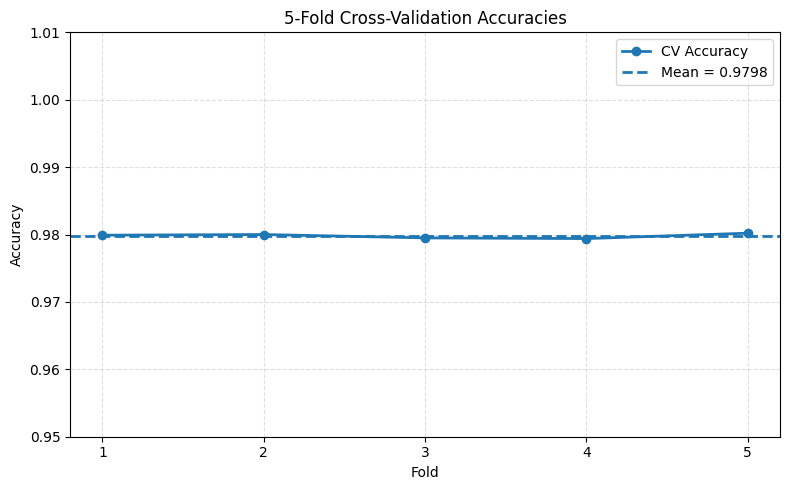

In [2]:
import numpy as np
import matplotlib.pyplot as plt


folds = np.arange(1, 6)

test_accuracy = np.array([
    0.9799,
    0.9800,
    0.9795,
    0.9794,
    0.9802
])

mean_acc = test_accuracy.mean()


plt.figure(figsize=(8, 5))

plt.plot(
    folds,
    test_accuracy,
    marker="o",
    linewidth=2,
    label="CV Accuracy"
)

plt.axhline(
    mean_acc,
    linestyle="--",
    linewidth=2,
    label=f"Mean = {mean_acc:.4f}"
)

plt.xticks(folds)
plt.ylim(0.95, 1.01)
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.title("5-Fold Cross-Validation Accuracies")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()

plt.tight_layout()
plt.show()

Hold-out Test Accuracy of Hybrid using Bayesian Optimization

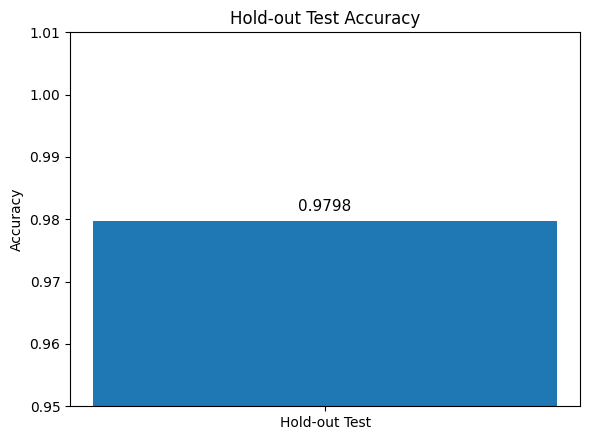

In [3]:
import numpy as np
import matplotlib.pyplot as plt


test_acc_folds = np.array([
    0.9799,
    0.9800,
    0.9795,
    0.9794,
    0.9802
])

holdout_test_accuracy = test_acc_folds.mean()


plt.figure(figsize=(6, 4.5))

plt.bar(
    ["Hold-out Test"],
    [holdout_test_accuracy]
)

plt.ylim(0.95, 1.01)
plt.ylabel("Accuracy")
plt.title("Hold-out Test Accuracy")

plt.text(
    0,
    holdout_test_accuracy + 0.001,
    f"{holdout_test_accuracy:.4f}",
    ha="center",
    va="bottom",
    fontsize=11
)

plt.tight_layout()
plt.show()

Model train Hybrid CA-GP without Bayesian Optimization



In [5]:

import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)

from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping

SEED = 42
DATA_PATH  = "HMXPC13_DI_v2_5-14-14.csv"
TARGET_COL = "certified"

AE_RANK_CSV = "autoencoder_reconstruction_final.csv"
GA_FEAT_CSV = "ga_selected_features_final.csv"
PSO_FEAT_CSV= "pso_selected_features_final.csv"

EPOCHS = 10
BATCH  = 128
LR     = 3e-4

AE_EPOCHS = 25
AE_BATCH  = 256
ENC_RATIO = 0.60

np.random.seed(SEED)
tf.random.set_seed(SEED)

def load_selected_features(csv_path):
    df_ = pd.read_csv(csv_path)
    for col in ["Selected Feature", "Feature", "selected_feature", "selected_features"]:
        if col in df_.columns:
            return df_[col].dropna().astype(str).tolist()
    return df_.iloc[:, 0].dropna().astype(str).tolist()

def load_all_ae_features(ae_rank_csv, dataset_columns):
    """
    Use ALL features in AE CSV, but map them safely to dataset columns
    (strip, case-insensitive match). Drop only those not in dataset.
    """
    dfr = pd.read_csv(ae_rank_csv)
    if "Feature" not in dfr.columns:
        raise ValueError(f"AE CSV must contain column 'Feature'. Found: {dfr.columns.tolist()}")

    def norm(x): return str(x).strip().lower()
    col_map = {norm(c): c for c in dataset_columns}

    feats = []
    dropped = []
    for f in dfr["Feature"].astype(str).tolist():
        key = norm(f)
        if key in col_map:
            feats.append(col_map[key])
        else:
            dropped.append(f)

    feats = list(dict.fromkeys(feats))

    if len(feats) == 0:
        raise ValueError("No AE features from CSV exist in dataset columns.")

    if dropped:
        print("\n AE features dropped (not found in dataset):")
        print(dropped[:50], "..." if len(dropped) > 50 else "")

    return feats

def get_X_by_features(Xtr_df, Xte_df, feat_list, fill_value=0.0):
    feat_list = [f for f in feat_list if f is not None]
    missing_tr = [f for f in feat_list if f not in Xtr_df.columns]
    missing_te = [f for f in feat_list if f not in Xte_df.columns]
    missing = sorted(set(missing_tr + missing_te))

    used = [f for f in feat_list if (f in Xtr_df.columns and f in Xte_df.columns)]
    if missing:
        print(f"Dropping missing features: {missing[:30]}{'...' if len(missing)>30 else ''}")

    if len(used) == 0:
        raise ValueError("After dropping missing features, no features remain.")

    Xtr = Xtr_df[used].copy().fillna(fill_value).to_numpy(dtype=np.float32)
    Xte = Xte_df[used].copy().fillna(fill_value).to_numpy(dtype=np.float32)
    return Xtr, Xte, used

def smote_resample(Xtr, ytr, seed=42):
    Xtr = np.asarray(Xtr, dtype=np.float32)
    ytr = np.asarray(ytr).astype(int)

    Xtr = np.nan_to_num(Xtr, nan=0.0, posinf=0.0, neginf=0.0)

    minority_count = int(np.sum(ytr == 1))
    if minority_count < 2:
        print(" SMOTE skipped (minority_count < 2). Using original training set.")
        return Xtr, ytr

    k_neighbors = min(5, max(1, minority_count - 1))
    sm = SMOTE(random_state=seed, k_neighbors=k_neighbors)
    X_res, y_res = sm.fit_resample(Xtr, ytr)
    return X_res.astype(np.float32), y_res.astype(int)

def train_ae_and_encode(Xtr, Xte, ae_epochs=25, ae_batch=256, enc_ratio=0.6):
    Xtr = np.asarray(Xtr, dtype=np.float32)
    Xte = np.asarray(Xte, dtype=np.float32)

    Xtr = np.nan_to_num(Xtr, nan=0.0, posinf=0.0, neginf=0.0)
    Xte = np.nan_to_num(Xte, nan=0.0, posinf=0.0, neginf=0.0)

    input_dim = Xtr.shape[1]
    enc_dim = max(2, int(input_dim * enc_ratio))

    inp = Input(shape=(input_dim,))
    z = Dense(enc_dim, activation="relu")(inp)
    z = Dropout(0.1)(z)
    out = Dense(input_dim, activation="linear")(z)

    ae = Model(inp, out)
    ae.compile(optimizer="adam", loss="mse")

    ae.fit(
        Xtr, Xtr,
        epochs=ae_epochs,
        batch_size=ae_batch,
        validation_split=0.1,
        callbacks=[EarlyStopping(patience=4, restore_best_weights=True)],
        verbose=0
    )

    encoder = Model(inp, z)
    Xtr_lat = encoder.predict(Xtr, verbose=0)
    Xte_lat = encoder.predict(Xte, verbose=0)
    return Xtr_lat.astype(np.float32), Xte_lat.astype(np.float32), enc_dim

def train_cnn_only(Xtr, Xte, ytr, yte, epochs=10, batch=128, lr=3e-4):
    Xtr = np.asarray(Xtr, dtype=np.float32)
    Xte = np.asarray(Xte, dtype=np.float32)
    ytr = np.asarray(ytr).astype(int)
    yte = np.asarray(yte).astype(int)

    Xtr = np.nan_to_num(Xtr, nan=0.0, posinf=0.0, neginf=0.0)
    Xte = np.nan_to_num(Xte, nan=0.0, posinf=0.0, neginf=0.0)

    Xtr3 = Xtr.reshape(Xtr.shape[0], Xtr.shape[1], 1)
    Xte3 = Xte.reshape(Xte.shape[0], Xte.shape[1], 1)

    model = Sequential([
        Input(shape=(Xtr3.shape[1], 1)),
        Conv1D(32, 5, activation="relu", padding="same"),
        Dropout(0.2),
        Conv1D(16, 3, activation="relu", padding="same"),
        Dropout(0.2),
        Flatten(),
        Dense(32, activation="relu"),
        Dropout(0.4),
        Dense(1, activation="sigmoid")
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    hist = model.fit(
        Xtr3, ytr,
        epochs=epochs,
        batch_size=batch,
        validation_split=0.1,
        verbose=0
    )

    train_acc = float(hist.history["accuracy"][-1])

    y_prob = model.predict(Xte3, verbose=0).ravel()
    y_pred = (y_prob >= 0.5).astype(int)

    test_acc = float(accuracy_score(yte, y_pred))
    bal_acc  = float(balanced_accuracy_score(yte, y_pred))
    cm = confusion_matrix(yte, y_pred)

    macro_prec = float(precision_score(yte, y_pred, average="macro", zero_division=0))
    macro_rec  = float(recall_score(yte, y_pred, average="macro", zero_division=0))
    macro_f1   = float(f1_score(yte, y_pred, average="macro", zero_division=0))

    if len(np.unique(yte)) < 2:
        auc_roc = float("nan")
        print("⚠️ AUC-ROC undefined (test set has only one class). Setting AUC=NaN.")
    else:
        auc_roc = float(roc_auc_score(yte, y_prob))

    return train_acc, test_acc, bal_acc, macro_prec, macro_rec, macro_f1, auc_roc, cm

def print_input_logic(variant_name, used_features, Xtr):
    print(f"\n================ {variant_name} | CNN INPUT LOGIC ================")
    print("Input dim:", Xtr.shape[1])
    if used_features is None:
        print("Feature names: (latent/no names)")
    else:
        print("Feature names:", used_features)

df = pd.read_csv(DATA_PATH)

if TARGET_COL not in df.columns:
    raise ValueError(f"Target '{TARGET_COL}' not found. First columns: {df.columns[:50].tolist()}")

y_all = pd.to_numeric(df[TARGET_COL], errors="coerce").fillna(0)
y_all = (y_all > 0).astype(int)

AE_FEATURES  = load_all_ae_features(AE_RANK_CSV, df.columns)
GA_FEATURES  = load_selected_features(GA_FEAT_CSV)
PSO_FEATURES = load_selected_features(PSO_FEAT_CSV)
HYB_BASE_FEATURES = sorted(set(GA_FEATURES).union(set(PSO_FEATURES)))

ALL_USED_FEATURES = sorted(set(AE_FEATURES).union(GA_FEATURES).union(PSO_FEATURES))

missing_in_data = [c for c in ALL_USED_FEATURES if c not in df.columns]
if missing_in_data:
    print("\n⚠️ These selected features are NOT in dataset and will be dropped:")
    print(missing_in_data[:80], "..." if len(missing_in_data) > 80 else "")

present_features = [c for c in ALL_USED_FEATURES if c in df.columns]
if len(present_features) < 2:
    raise ValueError(f"Not enough present features to train. Present: {present_features}")

X_all = df[present_features].copy()
for c in X_all.columns:
    X_all[c] = pd.to_numeric(X_all[c], errors="coerce")

X_all, y_all = X_all.align(y_all, join="inner", axis=0)

print("\nX/y ready:",
      "X_all:", X_all.shape,
      "| y:", y_all.shape,
      "| used features:", len(present_features))

print("\nClass distribution overall:", np.bincount(y_all))

X_trainval_raw, X_test_raw, y_trainval, y_test = train_test_split(
    X_all, y_all,
    test_size=0.2,
    random_state=SEED,
    stratify=y_all
)

X_train_raw, X_val_raw, y_train, y_val = train_test_split(
    X_trainval_raw, y_trainval,
    test_size=0.25,
    random_state=SEED,
    stratify=y_trainval
)

imputer = SimpleImputer(strategy="median")
X_train_imp = imputer.fit_transform(X_train_raw)
X_val_imp   = imputer.transform(X_val_raw)
X_test_imp  = imputer.transform(X_test_raw)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_imp).astype(np.float32)
X_val_scaled   = scaler.transform(X_val_imp).astype(np.float32)
X_test_scaled  = scaler.transform(X_test_imp).astype(np.float32)

y_train = np.asarray(y_train).astype(int)
y_val   = np.asarray(y_val).astype(int)
y_test  = np.asarray(y_test).astype(int)

X_train_scaled = np.nan_to_num(X_train_scaled, nan=0.0, posinf=0.0, neginf=0.0)
X_val_scaled   = np.nan_to_num(X_val_scaled,   nan=0.0, posinf=0.0, neginf=0.0)
X_test_scaled  = np.nan_to_num(X_test_scaled,  nan=0.0, posinf=0.0, neginf=0.0)

print("\nSplit class distributions:")
print("y_train:", np.bincount(y_train))
print("y_val  :", np.bincount(y_val))
print("y_test :", np.bincount(y_test))

feature_names = np.array(present_features)
X_train_df = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_df  = pd.DataFrame(X_test_scaled,  columns=feature_names)

X_train_ae_raw, X_test_ae_raw, ae_used = get_X_by_features(X_train_df, X_test_df, AE_FEATURES)
X_train_ae_lat, X_test_ae_lat, ae_lat_dim = train_ae_and_encode(
    X_train_ae_raw, X_test_ae_raw,
    ae_epochs=AE_EPOCHS, ae_batch=AE_BATCH, enc_ratio=ENC_RATIO
)

X_train_ga, X_test_ga, ga_used = get_X_by_features(X_train_df, X_test_df, GA_FEATURES)

X_train_pso, X_test_pso, pso_used = get_X_by_features(X_train_df, X_test_df, PSO_FEATURES)

X_train_hyb_raw, X_test_hyb_raw, hyb_used = get_X_by_features(X_train_df, X_test_df, HYB_BASE_FEATURES)
X_train_hyb_lat, X_test_hyb_lat, hyb_lat_dim = train_ae_and_encode(
    X_train_hyb_raw, X_test_hyb_raw,
    ae_epochs=AE_EPOCHS, ae_batch=AE_BATCH, enc_ratio=ENC_RATIO
)

X_train_ae_lat_sm,  y_train_ae_sm  = smote_resample(X_train_ae_lat,  y_train, seed=SEED)
X_train_ga_sm,      y_train_ga_sm  = smote_resample(X_train_ga,      y_train, seed=SEED)
X_train_pso_sm,     y_train_pso_sm = smote_resample(X_train_pso,     y_train, seed=SEED)
X_train_hyb_lat_sm, y_train_hyb_sm = smote_resample(X_train_hyb_lat, y_train, seed=SEED)

print("\nAfter SMOTE (TRAIN ONLY):")
print("AE-only :", np.bincount(y_train_ae_sm))
print("GA-only :", np.bincount(y_train_ga_sm))
print("PSO-only:", np.bincount(y_train_pso_sm))
print("Hybrid  :", np.bincount(y_train_hyb_sm))

variants = [
    ("AE-only (AE latents + SMOTE)", ae_used,  X_train_ae_lat_sm,  X_test_ae_lat,  y_train_ae_sm),
    ("GA-only (SMOTE)",              ga_used,  X_train_ga_sm,      X_test_ga,      y_train_ga_sm),
    ("PSO-only (SMOTE)",             pso_used, X_train_pso_sm,     X_test_pso,     y_train_pso_sm),
    ("Hybrid (GA∪PSO -> AE latents + SMOTE)", hyb_used, X_train_hyb_lat_sm, X_test_hyb_lat, y_train_hyb_sm),
]

print(f"\n============== CNN RESULTS (epochs={EPOCHS}) ==============")
rows = []

for name, used_feats, Xtr, Xte, ytr_sm in variants:
    print_input_logic(name, used_feats, Xtr)

    tr_acc, te_acc, bal, mprec, mrec, mf1, aucroc, cm = train_cnn_only(
        Xtr, Xte, ytr_sm, y_test,
        epochs=EPOCHS, batch=BATCH, lr=LR
    )

    rows.append([
        name,
        Xtr.shape[1],
        tr_acc,
        te_acc,
        bal,
        mprec,
        mrec,
        mf1,
        aucroc,
        cm.ravel().tolist()
    ])

    print(
        f"{name:40s} | dim={Xtr.shape[1]:2d} | "
        f"train_acc={tr_acc:.5f} | test_acc={te_acc:.5f} | bal_acc={bal:.5f} | "
        f"macroP={mprec:.5f} | macroR={mrec:.5f} | macroF1={mf1:.5f} | AUC={aucroc:.5f}"
    )
    print("Confusion matrix [[TN,FP],[FN,TP]]:\n", cm)

cnn_results = pd.DataFrame(
    rows,
    columns=[
        "Variant",
        "Input_Dim",
        f"Train_Accuracy@Epoch{EPOCHS}",
        f"Test_Accuracy@Epoch{EPOCHS}",
        f"Balanced_Accuracy@Epoch{EPOCHS}",
        f"Macro_Precision@Epoch{EPOCHS}",
        f"Macro_Recall@Epoch{EPOCHS}",
        f"Macro_F1@Epoch{EPOCHS}",
        f"AUC_ROC@Epoch{EPOCHS}",
        "ConfusionMatrix_[TN,FP,FN,TP]"
    ]
).sort_values(f"Balanced_Accuracy@Epoch{EPOCHS}", ascending=False)

print("\nCNN Model Result Summary:")
print(cnn_results)

print("\nDONE.")


X/y ready: X_all: (641138, 9) | y: (641138,) | used features: 9

Class distribution overall: [623451  17687]

Split class distributions:
y_train: [374070  10612]
y_val  : [124690   3538]
y_test : [124691   3537]

After SMOTE (TRAIN ONLY):
AE-only : [374070 374070]
GA-only : [374070 374070]
PSO-only: [374070 374070]
Hybrid  : [374070 374070]

============== CNN RESULTS (epochs=10) ==============

================ AE-only (AE latents + SMOTE) | CNN INPUT LOGIC ================
Input dim: 5
Feature names: ['viewed', 'YoB', 'nchapters', 'ndays_act', 'explored', 'nforum_posts', 'nevents', 'nplay_video', 'incomplete_flag']
AE-only (AE latents + SMOTE)             | dim= 5 | train_acc=0.96519 | test_acc=0.95819 | bal_acc=0.96614 | macroP=0.69732 | macroR=0.96614 | macroF1=0.77030 | AUC=0.99196
Confusion matrix [[TN,FP],[FN,TP]]:
 [[119420   5271]
 [    90   3447]]

================ GA-only (SMOTE) | CNN INPUT LOGIC ================
Input dim: 4
Feature names: ['explored', 'ndays_act', 'nchap

AUC-ROC curve of all variants (using CNN)(SMOTE)

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc


def plot_roc_cv_like_sample(
    X, y,
    lr=0.003, dropout=0.2, batch_size=128, epochs=10,
    n_splits=5, seed=42,
    title="5-Fold Cross-Validation AUC-ROC Curve"
):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    mean_fpr = np.linspace(0, 1, 200)
    tprs = []
    aucs = []

    plt.figure(figsize=(10, 6))

    for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y), start=1):
        X_tr, y_tr = X[tr_idx], y[tr_idx]
        X_va, y_va = X[va_idx], y[va_idx]

        tr_ds = get_dataset(X_tr, y_tr, batch_size)
        va_ds = get_dataset(X_va, y_va, batch_size)

        model = create_cnn_model(lr, dropout, X.shape[1])
        model.fit(tr_ds, epochs=int(epochs), verbose=0, callbacks=[nan_cb])

        y_prob = model.predict(va_ds, verbose=0).ravel().astype(float)

        fpr, tpr, _ = roc_curve(y_va, y_prob)
        fold_auc = auc(fpr, tpr)
        aucs.append(fold_auc)

        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)

        plt.plot(fpr, tpr, linewidth=1.5, alpha=0.6,
                 label=f"Fold {fold} (AUC = {fold_auc:.4f})")

    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", linewidth=1.5)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    plt.plot(mean_fpr, mean_tpr, color="blue", linewidth=2.5,
             label=f"Mean ROC (AUC = {mean_auc:.4f} ± {std_auc:.4f})")

    std_tpr = np.std(tprs, axis=0)
    tpr_upper = np.minimum(mean_tpr + std_tpr, 1)
    tpr_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tpr_lower, tpr_upper, alpha=0.15)

    plt.title(title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid(True, alpha=0.3)
    plt.legend(loc="lower right", fontsize=9)
    plt.tight_layout()
    plt.show()

    print("Fold AUCs:", [round(a, 6) for a in aucs])
    print(f"Mean AUC = {mean_auc:.6f} ± {std_auc:.6f}")



AE, GA and PSO for 5-fold CV (95%) using Proposed Hybrid FS technique

In [8]:

import os
import numpy as np
import pandas as pd

from scipy import stats
from itertools import combinations

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score
)

from scipy.stats import ttest_rel, wilcoxon
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping

SEED = 42
DATA_PATH  = "HMXPC13_DI_v2_5-14-14.csv"
TARGET_COL = "certified"

AE_RANK_CSV  = "autoencoder_reconstruction_final.csv"
GA_FEAT_CSV  = "ga_selected_features_final.csv"
PSO_FEAT_CSV = "pso_selected_features_final.csv"

EPOCHS = 10
BATCH  = 128
LR     = 3e-4
DROPOUT_DEFAULT = 0.2

AE_EPOCHS = 25
AE_BATCH  = 256
ENC_RATIO = 0.60

K_FOLDS = 5

HYB_BAYES_PARAMS = {
    "learning_rate": 0.0039316323523736615,
    "dropout_rate": 0.10038938292050717,
    "batch_size": 127,
    "epochs": 10
}

np.random.seed(SEED)
tf.random.set_seed(SEED)

def load_selected_features(csv_path):
    df_ = pd.read_csv(csv_path)
    for col in ["Selected Feature", "Feature", "selected_feature", "selected_features"]:
        if col in df_.columns:
            return df_[col].dropna().astype(str).tolist()
    return df_.iloc[:, 0].dropna().astype(str).tolist()

def load_all_ae_features(ae_rank_csv, dataset_columns):
    dfr = pd.read_csv(ae_rank_csv)
    if "Feature" not in dfr.columns:
        raise ValueError(f"AE CSV must contain column 'Feature'. Found: {dfr.columns.tolist()}")

    def norm(x): return str(x).strip().lower()
    col_map = {norm(c): c for c in dataset_columns}

    feats, dropped = [], []
    for f in dfr["Feature"].astype(str).tolist():
        key = norm(f)
        if key in col_map:
            feats.append(col_map[key])
        else:
            dropped.append(f)

    feats = list(dict.fromkeys(feats))
    if len(feats) == 0:
        raise ValueError("No AE features from CSV exist in dataset columns.")

    if dropped:
        print("\n⚠️ AE features dropped (not found in dataset):")
        print(dropped[:50], "..." if len(dropped) > 50 else "")
    return feats

def get_X_by_features(Xtr_df, Xte_df, feat_list, fill_value=0.0):
    feat_list = [f for f in feat_list if f is not None]
    used = [f for f in feat_list if (f in Xtr_df.columns and f in Xte_df.columns)]
    missing = sorted(set(feat_list) - set(used))

    if missing:
        print(f"Dropping missing features: {missing[:30]}{'...' if len(missing)>30 else ''}")

    if len(used) == 0:
        raise ValueError("After dropping missing features, no features remain.")

    Xtr = Xtr_df[used].copy().fillna(fill_value).to_numpy(dtype=np.float32)
    Xte = Xte_df[used].copy().fillna(fill_value).to_numpy(dtype=np.float32)
    return Xtr, Xte, used

def smote_resample(Xtr, ytr, seed=42):
    Xtr = np.asarray(Xtr, dtype=np.float32)
    ytr = np.asarray(ytr).astype(int)

    Xtr = np.nan_to_num(Xtr, nan=0.0, posinf=0.0, neginf=0.0)

    minority_count = int(np.sum(ytr == 1))
    if minority_count < 2:
        print("⚠️ SMOTE skipped (minority_count < 2). Using original training set.")
        return Xtr, ytr

    k_neighbors = min(5, max(1, minority_count - 1))
    sm = SMOTE(random_state=seed, k_neighbors=k_neighbors)
    X_res, y_res = sm.fit_resample(Xtr, ytr)
    return X_res.astype(np.float32), y_res.astype(int)

def train_ae_and_encode(Xtr, Xte, ae_epochs=25, ae_batch=256, enc_ratio=0.6):
    Xtr = np.asarray(Xtr, dtype=np.float32)
    Xte = np.asarray(Xte, dtype=np.float32)

    Xtr = np.nan_to_num(Xtr, nan=0.0, posinf=0.0, neginf=0.0)
    Xte = np.nan_to_num(Xte, nan=0.0, posinf=0.0, neginf=0.0)

    input_dim = Xtr.shape[1]
    enc_dim = max(2, int(input_dim * enc_ratio))

    inp = Input(shape=(input_dim,))
    z = Dense(enc_dim, activation="relu")(inp)
    z = Dropout(0.1)(z)
    out = Dense(input_dim, activation="linear")(z)

    ae = Model(inp, out)
    ae.compile(optimizer="adam", loss="mse")

    ae.fit(
        Xtr, Xtr,
        epochs=ae_epochs,
        batch_size=ae_batch,
        validation_split=0.1,
        callbacks=[EarlyStopping(patience=4, restore_best_weights=True)],
        verbose=0
    )

    encoder = Model(inp, z)
    Xtr_lat = encoder.predict(Xtr, verbose=0)
    Xte_lat = encoder.predict(Xte, verbose=0)
    return Xtr_lat.astype(np.float32), Xte_lat.astype(np.float32), enc_dim

def train_cnn_and_eval(Xtr, Xte, ytr, yte, epochs=10, batch=128, lr=3e-4, dropout_rate=0.2):
    Xtr = np.asarray(Xtr, dtype=np.float32)
    Xte = np.asarray(Xte, dtype=np.float32)
    ytr = np.asarray(ytr).astype(int)
    yte = np.asarray(yte).astype(int)

    Xtr = np.nan_to_num(Xtr, nan=0.0, posinf=0.0, neginf=0.0)
    Xte = np.nan_to_num(Xte, nan=0.0, posinf=0.0, neginf=0.0)

    Xtr3 = Xtr.reshape(Xtr.shape[0], Xtr.shape[1], 1)
    Xte3 = Xte.reshape(Xte.shape[0], Xte.shape[1], 1)

    model = Sequential([
        Input(shape=(Xtr3.shape[1], 1)),
        Conv1D(32, 5, activation="relu", padding="same"),
        Dropout(float(dropout_rate)),
        Conv1D(16, 3, activation="relu", padding="same"),
        Dropout(float(dropout_rate)),
        Flatten(),
        Dense(32, activation="relu"),
        Dropout(min(0.5, float(dropout_rate) + 0.2)),
        Dense(1, activation="sigmoid")
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=float(lr)),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    hist = model.fit(
        Xtr3, ytr,
        epochs=int(epochs),
        batch_size=int(batch),
        validation_split=0.1,
        verbose=0
    )

    train_acc_last = float(hist.history["accuracy"][-1])

    y_prob = model.predict(Xte3, verbose=0).ravel()
    y_pred = (y_prob >= 0.5).astype(int)

    acc = float(accuracy_score(yte, y_pred))
    bal = float(balanced_accuracy_score(yte, y_pred))
    mp  = float(precision_score(yte, y_pred, average="macro", zero_division=0))
    mr  = float(recall_score(yte, y_pred, average="macro", zero_division=0))
    mf1 = float(f1_score(yte, y_pred, average="macro", zero_division=0))

    aucroc = float("nan") if len(np.unique(yte)) < 2 else float(roc_auc_score(yte, y_prob))
    cm = confusion_matrix(yte, y_pred)

    return {
        "train_acc_last": train_acc_last,
        "test_acc": acc,
        "test_bal_acc": bal,
        "macro_precision": mp,
        "macro_recall": mr,
        "macro_f1": mf1,
        "auc_roc": aucroc,
        "cm": cm
    }

def ci95(values):
    v = np.asarray(values, dtype=float)
    v = v[~np.isnan(v)]
    n = len(v)
    if n == 0:
        return (np.nan, np.nan, np.nan)
    mean = float(v.mean())
    if n < 2:
        return (mean, mean, mean)
    std = float(v.std(ddof=1))
    se = std / np.sqrt(n)
    tval = stats.t.ppf(0.975, df=n - 1)
    half = tval * se
    return (mean, mean - half, mean + half)

def paired_clean(x, y):
    x = np.asarray(x, dtype=float).ravel()
    y = np.asarray(y, dtype=float).ravel()
    n = min(len(x), len(y))
    x, y = x[:n], y[:n]
    mask = ~np.isnan(x) & ~np.isnan(y)
    return x[mask], y[mask]

def safe_wilcoxon(x, y):
    d = x - y
    if len(d) == 0:
        return (np.nan, np.nan)
    if np.allclose(d, 0):
        return (0.0, 1.0)
    try:
        stat, p = wilcoxon(x, y, zero_method="wilcox", alternative="two-sided", mode="auto")
        return (float(stat), float(p))
    except Exception:
        return (np.nan, np.nan)

df = pd.read_csv(DATA_PATH)

if TARGET_COL not in df.columns:
    raise ValueError(f"Target '{TARGET_COL}' not found. First columns: {df.columns[:50].tolist()}")

y_all = pd.to_numeric(df[TARGET_COL], errors="coerce").fillna(0)
y_all = (y_all > 0).astype(int)

AE_FEATURES  = load_all_ae_features(AE_RANK_CSV, df.columns)
GA_FEATURES  = load_selected_features(GA_FEAT_CSV)
PSO_FEATURES = load_selected_features(PSO_FEAT_CSV)
HYB_BASE_FEATURES = sorted(set(GA_FEATURES).union(set(PSO_FEATURES)))

ALL_USED_FEATURES = sorted(set(AE_FEATURES).union(GA_FEATURES).union(PSO_FEATURES))
present_features = [c for c in ALL_USED_FEATURES if c in df.columns]
if len(present_features) < 2:
    raise ValueError(f"Not enough present features to train. Present: {present_features}")

X_all = df[present_features].copy()
for c in X_all.columns:
    X_all[c] = pd.to_numeric(X_all[c], errors="coerce")

X_all, y_all = X_all.align(y_all, join="inner", axis=0)

print("\nX/y ready:",
      "X_all:", X_all.shape,
      "| y:", y_all.shape,
      "| used features:", len(present_features))
print("Class distribution overall:", np.bincount(y_all))

X_trainval_raw, X_test_raw, y_trainval, y_test = train_test_split(
    X_all, y_all,
    test_size=0.2,
    random_state=SEED,
    stratify=y_all
)

X_trainval_raw = X_trainval_raw.reset_index(drop=True)
y_trainval = np.asarray(y_trainval).astype(int)

X_test_raw = X_test_raw.reset_index(drop=True)
y_test = np.asarray(y_test).astype(int)

print("\nFixed TEST distribution:", np.bincount(y_test))

VARIANTS = [
    "AE-only (AE latents + SMOTE)",
    "GA-only (SMOTE)",
    "PSO-only (SMOTE)",
    "Hybrid (GA∪PSO -> AE latents + SMOTE)"
]

VARIANT_PARAMS = {
    "AE-only (AE latents + SMOTE)": {
        "learning_rate": LR,
        "dropout_rate": DROPOUT_DEFAULT,
        "batch_size": BATCH,
        "epochs": EPOCHS
    },
    "GA-only (SMOTE)": {
        "learning_rate": LR,
        "dropout_rate": DROPOUT_DEFAULT,
        "batch_size": BATCH,
        "epochs": EPOCHS
    },
    "PSO-only (SMOTE)": {
        "learning_rate": LR,
        "dropout_rate": DROPOUT_DEFAULT,
        "batch_size": BATCH,
        "epochs": EPOCHS
    },
    "Hybrid (GA∪PSO -> AE latents + SMOTE)": HYB_BAYES_PARAMS
}

fold_metrics = {name: {
    "train_acc_last": [],
    "test_acc": [],
    "test_bal_acc": [],
    "macro_precision": [],
    "macro_recall": [],
    "macro_f1": [],
    "auc_roc": []
} for name in VARIANTS}

skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=SEED)

print("\n====================")
print(f"Running {K_FOLDS}-Fold CV (evaluate on FIXED TEST each fold)")
print(f"Default params: epochs={EPOCHS}, batch={BATCH}, lr={LR}, dropout={DROPOUT_DEFAULT}")
print(f"Hybrid Bayesian params: {HYB_BAYES_PARAMS}")
print("====================")

for fold, (tr_idx, va_idx) in enumerate(skf.split(X_trainval_raw, y_trainval), start=1):
    print(f"\n--- Fold {fold}/{K_FOLDS} ---")
    X_tr_raw = X_trainval_raw.iloc[tr_idx].copy()
    y_tr = y_trainval[tr_idx].copy()

    imputer = SimpleImputer(strategy="median")
    scaler  = MinMaxScaler()

    X_tr_imp = imputer.fit_transform(X_tr_raw)
    X_te_imp = imputer.transform(X_test_raw)

    X_tr_scaled = scaler.fit_transform(X_tr_imp).astype(np.float32)
    X_te_scaled = scaler.transform(X_te_imp).astype(np.float32)

    X_tr_scaled = np.nan_to_num(X_tr_scaled, nan=0.0, posinf=0.0, neginf=0.0)
    X_te_scaled = np.nan_to_num(X_te_scaled, nan=0.0, posinf=0.0, neginf=0.0)

    feat_names = np.array(present_features)
    X_tr_df = pd.DataFrame(X_tr_scaled, columns=feat_names)
    X_te_df = pd.DataFrame(X_te_scaled, columns=feat_names)

    X_tr_ae_raw, X_te_ae_raw, _ = get_X_by_features(X_tr_df, X_te_df, AE_FEATURES)
    X_tr_ae_lat, X_te_ae_lat, _ = train_ae_and_encode(
        X_tr_ae_raw, X_te_ae_raw,
        ae_epochs=AE_EPOCHS, ae_batch=AE_BATCH, enc_ratio=ENC_RATIO
    )

    X_tr_ga, X_te_ga, _ = get_X_by_features(X_tr_df, X_te_df, GA_FEATURES)

    X_tr_pso, X_te_pso, _ = get_X_by_features(X_tr_df, X_te_df, PSO_FEATURES)

    X_tr_hyb_raw, X_te_hyb_raw, _ = get_X_by_features(X_tr_df, X_te_df, HYB_BASE_FEATURES)
    X_tr_hyb_lat, X_te_hyb_lat, _ = train_ae_and_encode(
        X_tr_hyb_raw, X_te_hyb_raw,
        ae_epochs=AE_EPOCHS, ae_batch=AE_BATCH, enc_ratio=ENC_RATIO
    )

    X_tr_ae_sm,  y_tr_ae_sm  = smote_resample(X_tr_ae_lat,  y_tr, seed=SEED)
    X_tr_ga_sm,  y_tr_ga_sm  = smote_resample(X_tr_ga,      y_tr, seed=SEED)
    X_tr_pso_sm, y_tr_pso_sm = smote_resample(X_tr_pso,     y_tr, seed=SEED)
    X_tr_hy_sm,  y_tr_hy_sm  = smote_resample(X_tr_hyb_lat, y_tr, seed=SEED)

    run_items = [
        ("AE-only (AE latents + SMOTE)", X_tr_ae_sm,  X_te_ae_lat,  y_tr_ae_sm),
        ("GA-only (SMOTE)",              X_tr_ga_sm,  X_te_ga,      y_tr_ga_sm),
        ("PSO-only (SMOTE)",             X_tr_pso_sm, X_te_pso,     y_tr_pso_sm),
        ("Hybrid (GA∪PSO -> AE latents + SMOTE)", X_tr_hy_sm, X_te_hyb_lat, y_tr_hy_sm),
    ]

    for vname, Xtr_v, Xte_v, ytr_v in run_items:
        params = VARIANT_PARAMS[vname]
        out = train_cnn_and_eval(
            Xtr_v, Xte_v, ytr_v, y_test,
            epochs=params["epochs"],
            batch=params["batch_size"],
            lr=params["learning_rate"],
            dropout_rate=params["dropout_rate"]
        )

        for k in fold_metrics[vname].keys():
            fold_metrics[vname][k].append(out[k])

        auc_str = f"{out['auc_roc']:.5f}" if not np.isnan(out["auc_roc"]) else "nan"
        print(
            f"{vname:40s} | "
            f"TrainAcc(last)={out['train_acc_last']:.5f} | "
            f"TestAcc={out['test_acc']:.5f} | BalAcc={out['test_bal_acc']:.5f} | "
            f"MacPrec={out['macro_precision']:.5f} | MacRec={out['macro_recall']:.5f} | "
            f"MacF1={out['macro_f1']:.5f} | AUC={auc_str}"
        )

metrics_order = [
    ("train_acc_last", "Train_Accuracy_LastEpoch"),
    ("test_acc", "Test_Accuracy"),
    ("test_bal_acc", "Balanced_Accuracy"),
    ("macro_precision", "Macro_Precision"),
    ("macro_recall", "Macro_Recall"),
    ("macro_f1", "Macro_F1"),
    ("auc_roc", "AUC_ROC"),
]

summary_rows = []
for vname in VARIANTS:
    row = {"Variant": vname}
    for key, label in metrics_order:
        m, lo, hi = ci95(fold_metrics[vname][key])
        row[f"{label}_Mean"] = m
        row[f"{label}_CI_Low"] = lo
        row[f"{label}_CI_High"] = hi
    summary_rows.append(row)

cv_ci_results = pd.DataFrame(summary_rows).sort_values("Balanced_Accuracy_Mean", ascending=False)

print("\n====================")
print(f"{K_FOLDS}-Fold CV + 95% CI Summary (fold-trained model evaluated on FIXED TEST)")
print("====================")
print(cv_ci_results.to_string(index=False))

TEST_METRICS = {
    "Train_Accuracy_LastEpoch": "train_acc_last",
    "Test_Accuracy": "test_acc",
    "Balanced_Accuracy": "test_bal_acc"
}

rows = []
for metric_name, metric_key in TEST_METRICS.items():
    for a, b in combinations(VARIANTS, 2):
        xa, xb = paired_clean(fold_metrics[a][metric_key], fold_metrics[b][metric_key])

        if len(xa) < 2:
            t_stat, t_p = (np.nan, np.nan)
        else:
            t_stat, t_p = ttest_rel(xa, xb, nan_policy="omit")

        w_stat, w_p = safe_wilcoxon(xa, xb)

        diff = xa - xb
        mean_diff = float(np.mean(diff)) if len(diff) else np.nan
        sd_diff = float(np.std(diff, ddof=1)) if len(diff) > 1 else np.nan
        dz = (mean_diff / sd_diff) if (len(diff) > 1 and sd_diff > 0) else np.nan

        rows.append({
            "Metric": metric_name,
            "Model A": a,
            "Model B": b,
            "n_pairs": int(len(xa)),
            "mean(A)-mean(B)": mean_diff,
            "cohen_dz": dz,
            "t_stat": float(t_stat) if not np.isnan(t_stat) else np.nan,
            "t_p": float(t_p) if not np.isnan(t_p) else np.nan,
            "wilcoxon_stat": w_stat,
            "wilcoxon_p": w_p
        })

tests_df = pd.DataFrame(rows).sort_values(["Metric", "t_p", "wilcoxon_p"], ascending=True)

print("\n====================")
print("Paired Statistical Tests (5 paired folds)")
print("- paired t-test + Wilcoxon signed-rank")
print("- metrics: TrainAcc(last), TestAcc, BalancedAcc")
print("====================")
print(tests_df.to_string(index=False))

print("\nDONE.")


X/y ready: X_all: (641138, 9) | y: (641138,) | used features: 9
Class distribution overall: [623451  17687]

Fixed TEST distribution: [124691   3537]

Running 5-Fold CV (evaluate on FIXED TEST each fold)
Default params: epochs=10, batch=128, lr=0.0003, dropout=0.2
Hybrid Bayesian params: {'learning_rate': 0.0039316323523736615, 'dropout_rate': 0.10038938292050717, 'batch_size': 127, 'epochs': 10}

--- Fold 1/5 ---
AE-only (AE latents + SMOTE)             | TrainAcc(last)=0.96488 | TestAcc=0.95292 | BalAcc=0.96700 | MacPrec=0.68357 | MacRec=0.96700 | MacF1=0.75511 | AUC=0.99223
GA-only (SMOTE)                          | TrainAcc(last)=0.97273 | TestAcc=0.96182 | BalAcc=0.97350 | MacPrec=0.70902 | MacRec=0.97350 | MacF1=0.78376 | AUC=0.99337
PSO-only (SMOTE)                         | TrainAcc(last)=0.97349 | TestAcc=0.96176 | BalAcc=0.97402 | MacPrec=0.70890 | MacRec=0.97402 | MacF1=0.78371 | AUC=0.99356
Hybrid (GA∪PSO -> AE latents + SMOTE)    | TrainAcc(last)=0.96838 | TestAcc=0.95970

Comparsion of Results

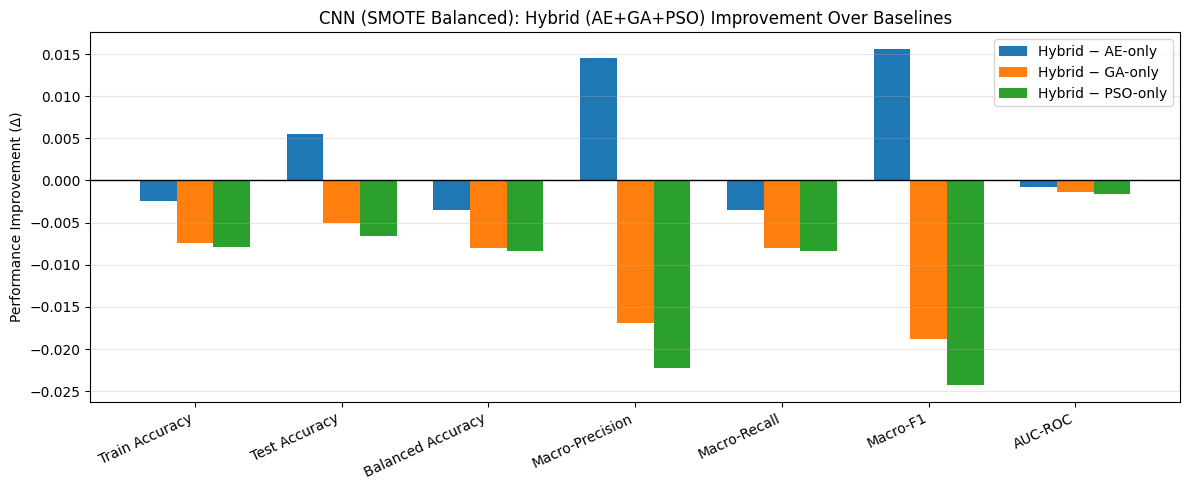

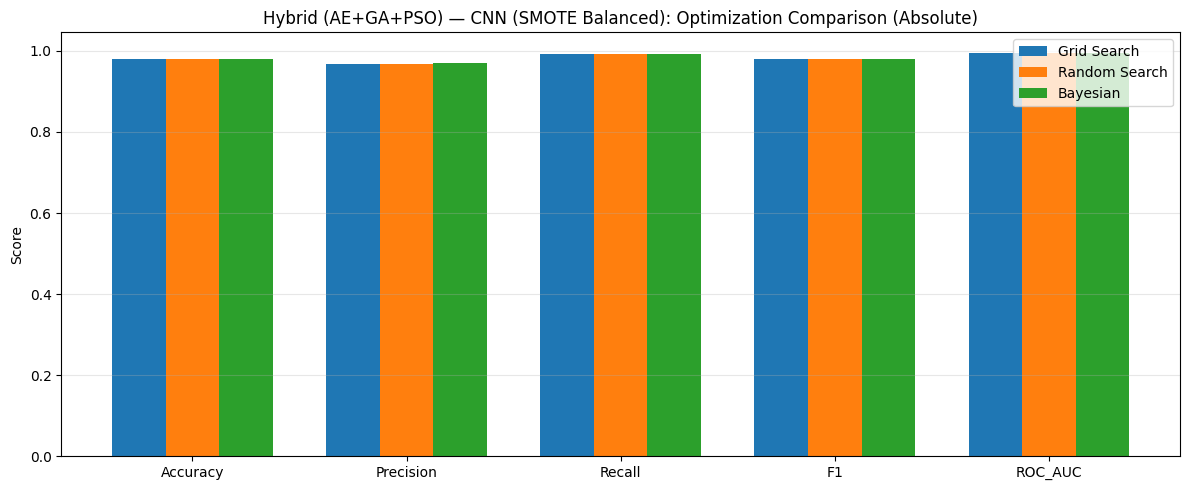

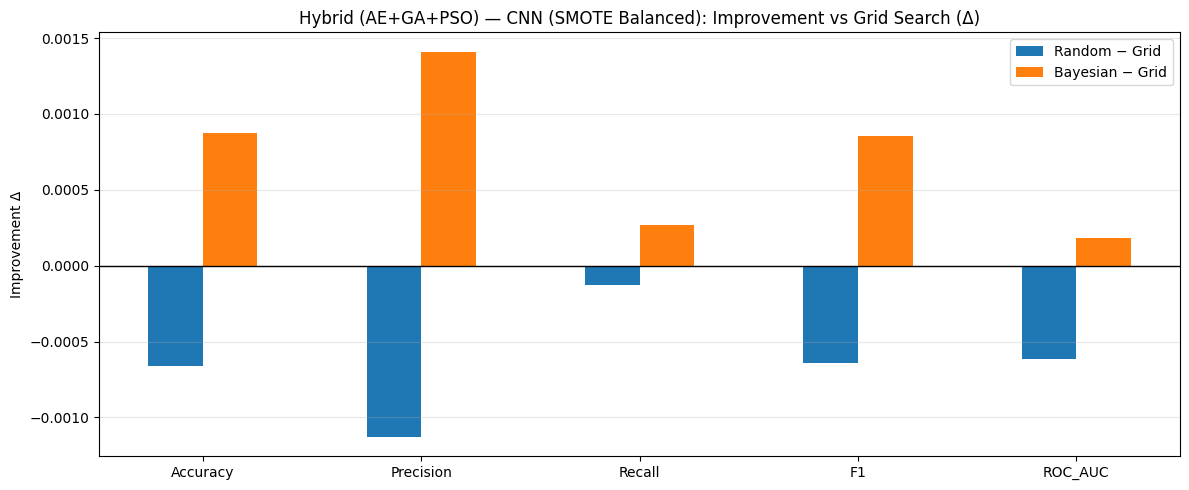

In [9]:
import numpy as np
import matplotlib.pyplot as plt

metrics_variants = [
    "Train Accuracy",
    "Test Accuracy",
    "Balanced Accuracy",
    "Macro-Precision",
    "Macro-Recall",
    "Macro-F1",
    "AUC-ROC"
]

AE = np.array([0.96775, 0.953497, 0.969359, 0.685286, 0.969359, 0.757329, 0.992766])
GA = np.array([0.972762, 0.964142, 0.973871, 0.716706, 0.973871, 0.791737, 0.993315])
PSO= np.array([0.973285, 0.965655, 0.974237, 0.722048, 0.974237, 0.797178, 0.993536])
Hybrid = np.array([0.965347, 0.959057, 0.965899, 0.699789, 0.965899, 0.772922, 0.991955])

delta_AE  = Hybrid - AE
delta_GA  = Hybrid - GA
delta_PSO = Hybrid - PSO

x = np.arange(len(metrics_variants))
w = 0.25

plt.figure(figsize=(12, 5))
plt.bar(x - w, delta_AE,  width=w, label="Hybrid − AE-only")
plt.bar(x,     delta_GA,  width=w, label="Hybrid − GA-only")
plt.bar(x + w, delta_PSO, width=w, label="Hybrid − PSO-only")
plt.axhline(0, color="black", linewidth=1)

plt.xticks(x, metrics_variants, rotation=25, ha="right")
plt.ylabel("Performance Improvement (Δ)")
plt.title("CNN (SMOTE Balanced): Hybrid (AE+GA+PSO) Improvement Over Baselines")
plt.grid(axis="y", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


methods = ["Grid Search", "Random Search", "Bayesian"]
metrics_opt = ["Accuracy", "Precision", "Recall", "F1", "ROC_AUC"]

grid  = np.array([0.979564, 0.967807, 0.992130, 0.979818, 0.995656])
rand  = np.array([0.978903, 0.966678, 0.992000, 0.979175, 0.995043])
bayes = np.array([0.980441, 0.969218, 0.992401, 0.980673, 0.995836])

x2 = np.arange(len(metrics_opt))
w2 = 0.25

plt.figure(figsize=(12, 5))
plt.bar(x2 - w2, grid,  width=w2, label="Grid Search")
plt.bar(x2,      rand,  width=w2, label="Random Search")
plt.bar(x2 + w2, bayes, width=w2, label="Bayesian")

plt.xticks(x2, metrics_opt)
plt.ylabel("Score")
plt.title("Hybrid (AE+GA+PSO) — CNN (SMOTE Balanced): Optimization Comparison (Absolute)")
plt.grid(axis="y", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

delta_rand  = rand  - grid
delta_bayes = bayes - grid

plt.figure(figsize=(12, 5))
plt.bar(x2 - w2/2, delta_rand,  width=w2, label="Random − Grid")
plt.bar(x2 + w2/2, delta_bayes, width=w2, label="Bayesian − Grid")
plt.axhline(0, color="black", linewidth=1)

plt.xticks(x2, metrics_opt)
plt.ylabel("Improvement Δ")
plt.title("Hybrid (AE+GA+PSO) — CNN (SMOTE Balanced): Improvement vs Grid Search (Δ)")
plt.grid(axis="y", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Comparison of Results

Best Hybrid Optimizer: Bayesian
Best Hybrid Metrics: {'Accuracy': 0.980441, 'Precision': 0.969218, 'Recall': 0.992401, 'F1': 0.980673, 'AUC': 0.995836}


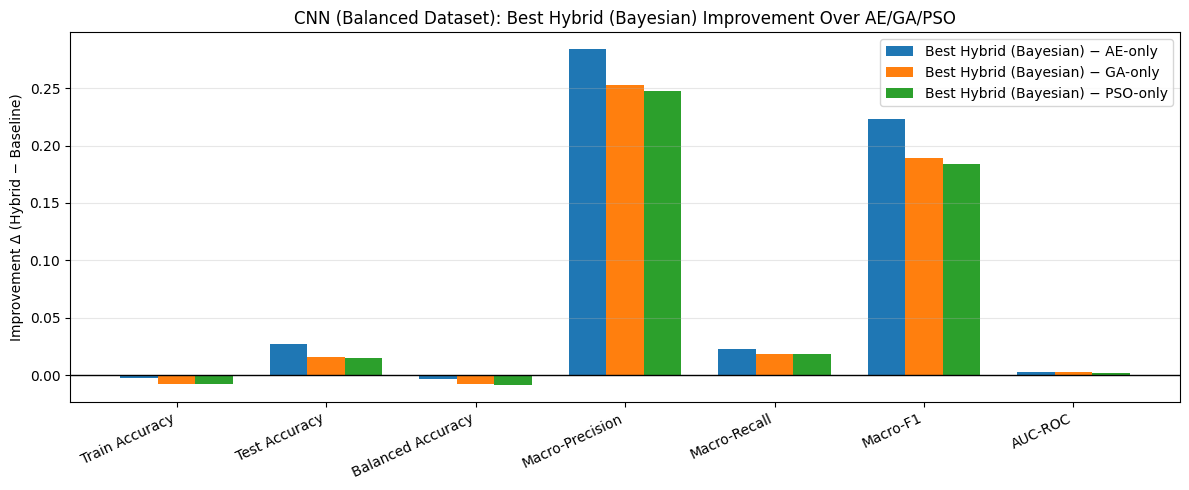

In [10]:
import numpy as np
import matplotlib.pyplot as plt

metrics_base = [
    "Train Accuracy",
    "Test Accuracy",
    "Balanced Accuracy",
    "Macro-Precision",
    "Macro-Recall",
    "Macro-F1",
    "AUC-ROC"
]

AE  = np.array([0.96775,  0.953497, 0.969359, 0.685286, 0.969359, 0.757329, 0.992766])
GA  = np.array([0.972762, 0.964142, 0.973871, 0.716706, 0.973871, 0.791737, 0.993315])
PSO = np.array([0.973285, 0.965655, 0.974237, 0.722048, 0.974237, 0.797178, 0.993536])

hybrid_opt = {
    "Grid Search":   {"Accuracy": 0.979564, "Precision": 0.967807, "Recall": 0.992130, "F1": 0.979818, "AUC": 0.995656},
    "Random Search": {"Accuracy": 0.978903, "Precision": 0.966678, "Recall": 0.992000, "F1": 0.979175, "AUC": 0.995043},
    "Bayesian":      {"Accuracy": 0.980441, "Precision": 0.969218, "Recall": 0.992401, "F1": 0.980673, "AUC": 0.995836},
}

best_method = max(hybrid_opt, key=lambda k: hybrid_opt[k]["F1"])
best = hybrid_opt[best_method]

print("Best Hybrid Optimizer:", best_method)
print("Best Hybrid Metrics:", best)

HYB_TRAINACC_FROM_BASELINE = 0.965347
HYB_BALACC_FROM_BASELINE   = 0.965899

Hybrid_best = np.array([
    HYB_TRAINACC_FROM_BASELINE,
    best["Accuracy"],
    HYB_BALACC_FROM_BASELINE,
    best["Precision"],
    best["Recall"],
    best["F1"],
    best["AUC"],
])

delta_AE  = Hybrid_best - AE
delta_GA  = Hybrid_best - GA
delta_PSO = Hybrid_best - PSO

x = np.arange(len(metrics_base))
w = 0.25

plt.figure(figsize=(12, 5))
plt.bar(x - w, delta_AE,  width=w, label=f"Best Hybrid ({best_method}) − AE-only")
plt.bar(x,     delta_GA,  width=w, label=f"Best Hybrid ({best_method}) − GA-only")
plt.bar(x + w, delta_PSO, width=w, label=f"Best Hybrid ({best_method}) − PSO-only")
plt.axhline(0, color="black", linewidth=1)

plt.xticks(x, metrics_base, rotation=25, ha="right")
plt.ylabel("Improvement Δ (Hybrid − Baseline)")
plt.title(f"CNN (Balanced Dataset): Best Hybrid ({best_method}) Improvement Over AE/GA/PSO")
plt.grid(axis="y", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Comparison of Results using 95% CI for all variants of CA-GP technique

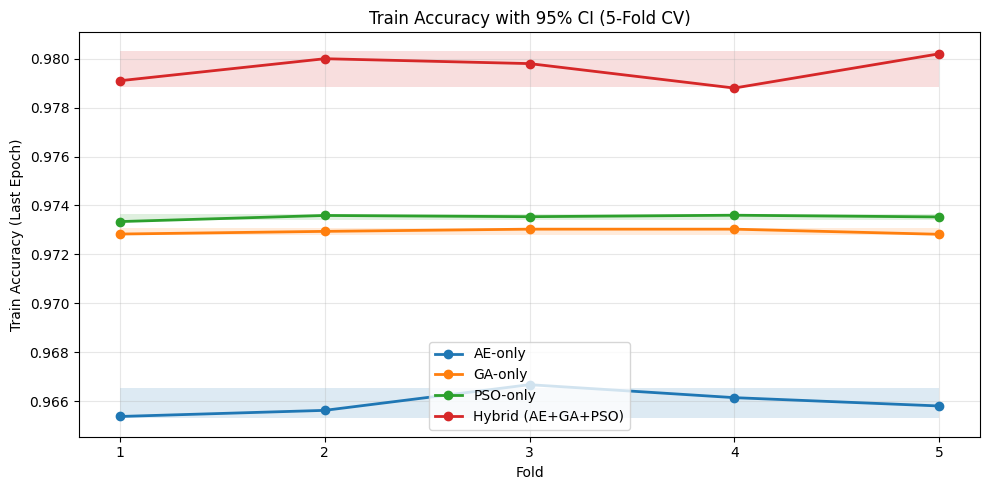

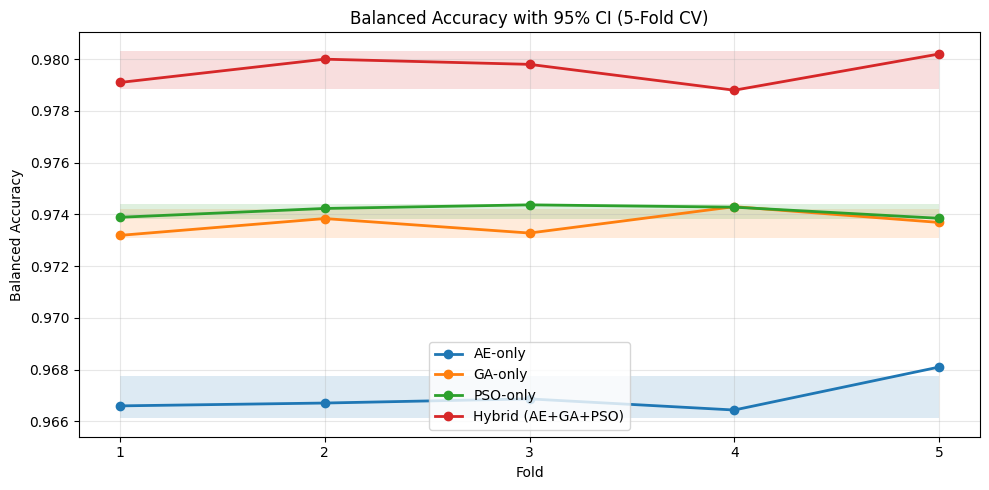

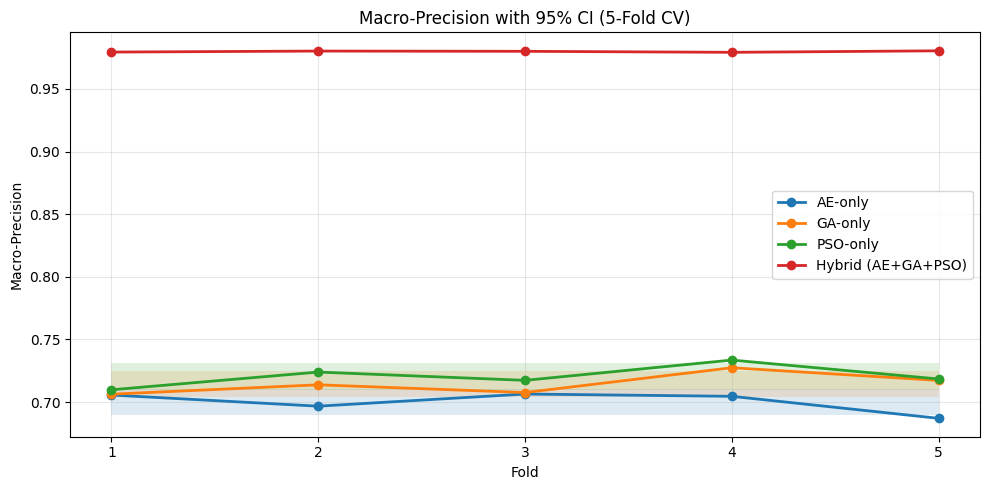

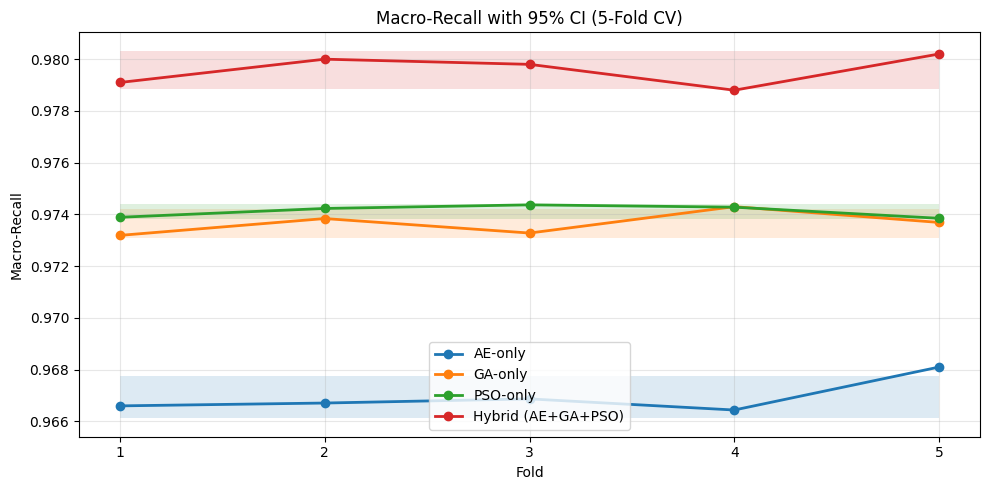

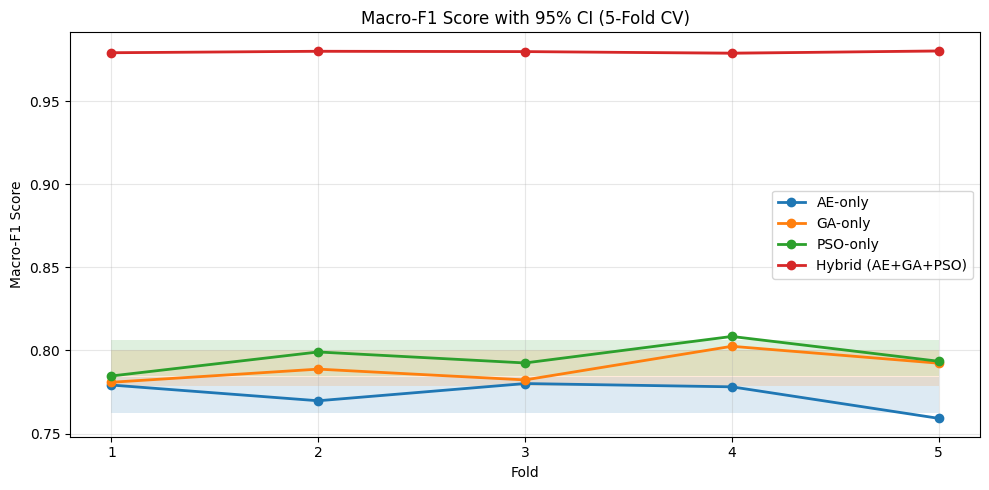

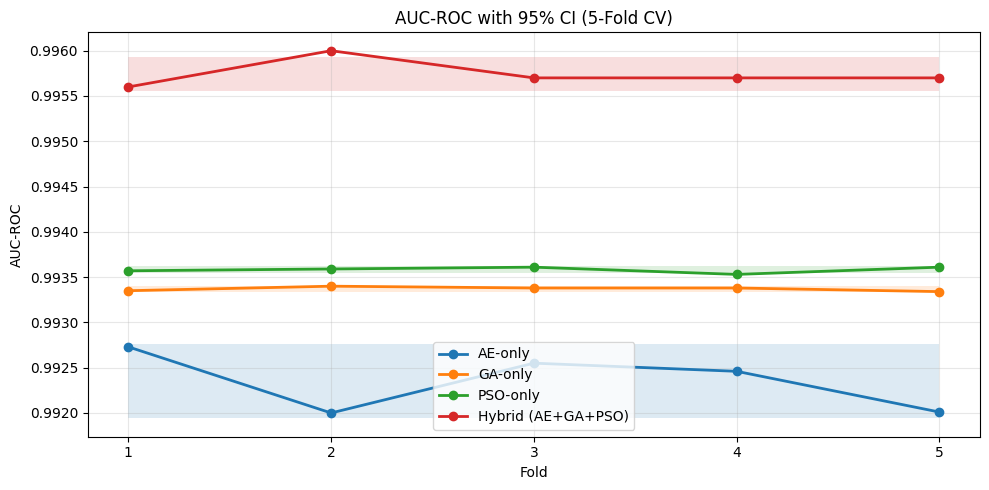

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t






 (from your latest message)
data = {
    "AE-only": {
        "TrainAcc": [0.96537, 0.96562, 0.96667, 0.96614, 0.96580],
        "BalAcc":   [0.96660, 0.96671, 0.96687, 0.96644, 0.96810],
        "MacPrec":  [0.70561, 0.69672, 0.70642, 0.70460, 0.68701],
        "MacRec":   [0.96660, 0.96671, 0.96687, 0.96644, 0.96810],
        "MacF1":    [0.77918, 0.76972, 0.78007, 0.77810, 0.75914],
        "AUC":      [0.99273, 0.99200, 0.99255, 0.99246, 0.99201],
    },
    "GA-only": {
        "TrainAcc": [0.97283, 0.97294, 0.97303, 0.97303, 0.97282],
        "BalAcc":   [0.97319, 0.97384, 0.97328, 0.97430, 0.97369],
        "MacPrec":  [0.70628, 0.71378, 0.70762, 0.72741, 0.71731],
        "MacRec":   [0.97319, 0.97384, 0.97328, 0.97430, 0.97369],
        "MacF1":    [0.78084, 0.78875, 0.78226, 0.80249, 0.79232],
        "AUC":      [0.99335, 0.99340, 0.99338, 0.99338, 0.99334],
    },
    "PSO-only": {
        "TrainAcc": [0.97334, 0.97359, 0.97354, 0.97360, 0.97353],
        "BalAcc":   [0.97389, 0.97423, 0.97437, 0.97428, 0.97385],
        "MacPrec":  [0.70980, 0.72395, 0.71734, 0.73352, 0.71843],
        "MacRec":   [0.97389, 0.97423, 0.97437, 0.97428, 0.97385],
        "MacF1":    [0.78463, 0.79907, 0.79246, 0.80841, 0.79348],
        "AUC":      [0.99357, 0.99359, 0.99361, 0.99353, 0.99361],
    },
    "Hybrid (AE+GA+PSO)": {
        "TrainAcc": [0.9791, 0.9800, 0.9798, 0.9788, 0.9802],
        "BalAcc":   [0.9791, 0.9800, 0.9798, 0.9788, 0.9802],
        "MacPrec":  [0.9794, 0.9802, 0.9800, 0.9792, 0.9804],
        "MacRec":   [0.9791, 0.9800, 0.9798, 0.9788, 0.9802],
        "MacF1":    [0.9791, 0.9800, 0.9798, 0.9788, 0.9802],
        "AUC":      [0.9956, 0.9960, 0.9957, 0.9957, 0.9957],
    },
}

def mean_ci(vals, confidence=0.95):
    x = np.asarray(vals, dtype=float)
    n = len(x)
    mean = x.mean()
    if n < 2:
        return mean, mean, mean
    se = x.std(ddof=1) / np.sqrt(n)
    tcrit = t.ppf(1 - (1 - confidence) / 2, df=n - 1)
    half = tcrit * se
    return mean, mean - half, mean + half

def plot_metric(metric_key, title=None, ylabel=None, confidence=0.95):
    folds = np.arange(1, 6)
    plt.figure(figsize=(10, 5))

    any_plotted = False

    for variant, metrics in data.items():
        if metric_key not in metrics:
            continue

        y = np.asarray(metrics[metric_key], dtype=float)
        _, lo, hi = mean_ci(y, confidence=confidence)

        plt.plot(folds, y, marker="o", linewidth=2, label=variant)
        plt.fill_between(folds, lo, hi, alpha=0.15)

        any_plotted = True

    if not any_plotted:
        raise ValueError(f"No data found for metric '{metric_key}'.")

    plt.title(title if title else f"{metric_key} with 95% CI (5-Fold CV)")
    plt.xlabel("Fold")
    plt.ylabel(ylabel if ylabel else metric_key)
    plt.xticks(folds)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_metric("TrainAcc", title="Train Accuracy with 95% CI (5-Fold CV)", ylabel="Train Accuracy (Last Epoch)")
plot_metric("BalAcc",   title="Balanced Accuracy with 95% CI (5-Fold CV)", ylabel="Balanced Accuracy")
plot_metric("MacPrec",  title="Macro-Precision with 95% CI (5-Fold CV)", ylabel="Macro-Precision")
plot_metric("MacRec",   title="Macro-Recall with 95% CI (5-Fold CV)", ylabel="Macro-Recall")
plot_metric("MacF1",    title="Macro-F1 Score with 95% CI (5-Fold CV)", ylabel="Macro-F1 Score")
plot_metric("AUC",      title="AUC-ROC with 95% CI (5-Fold CV)", ylabel="AUC-ROC")

AUC per 5-Fold of all variants of proposed hybrid CA-GP technique

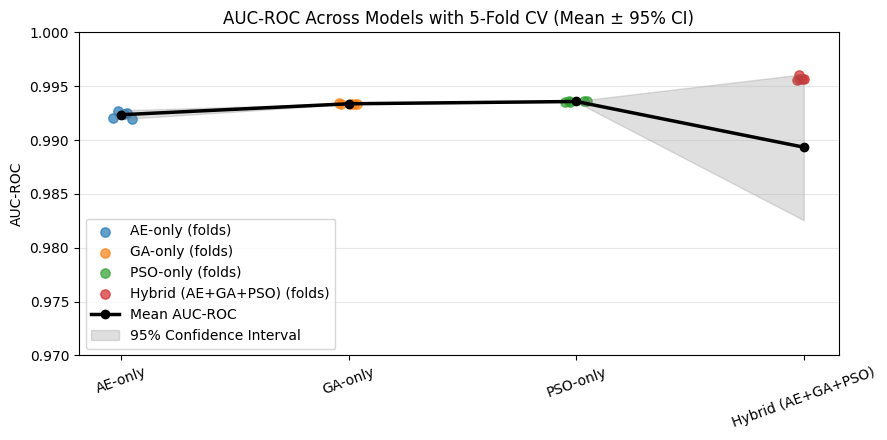

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


auc_per_fold = {
    "AE-only":              np.array([0.99273, 0.99200, 0.99255, 0.99246, 0.99201]),
    "GA-only":              np.array([0.99335, 0.99340, 0.99338, 0.99338, 0.99334]),
    "PSO-only":             np.array([0.99357, 0.99359, 0.99361, 0.99353, 0.99361]),
    "Hybrid (AE+GA+PSO)":   np.array([0.99560, 0.99600, 0.99570, 0.99570, 0.99570]),
}

methods = list(auc_per_fold.keys())
x = np.arange(len(methods))

auc_mean = np.array([0.992351, 0.993368, 0.993580, 0.989337])
auc_low  = np.array([0.991941, 0.993336, 0.993539, 0.982556])
auc_high = np.array([0.992762, 0.993400, 0.993621, 0.996117])

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]


plt.figure(figsize=(9, 4.5))

for i, (method, color) in enumerate(zip(methods, colors)):
    jitter = np.random.uniform(-0.05, 0.05, size=len(auc_per_fold[method]))
    plt.scatter(
        x[i] + jitter,
        auc_per_fold[method],
        s=45,
        alpha=0.7,
        color=color,
        label=f"{method} (folds)"
    )

plt.plot(
    x,
    auc_mean,
    color="black",
    marker="o",
    linewidth=2.5,
    label="Mean AUC-ROC"
)

plt.fill_between(
    x,
    auc_low,
    auc_high,
    color="gray",
    alpha=0.25,
    label="95% Confidence Interval"
)

plt.xticks(x, methods, rotation=20)
plt.ylabel("AUC-ROC")
plt.ylim(0.97, 1.00)
plt.title("AUC-ROC Across Models with 5-Fold CV (Mean ± 95% CI)")
plt.grid(axis="y", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

p-paired and Wilicoxon tests on proposed hybrid CA-GP technique (separate statistical analysis)

                    Comparison          t_p  wilcoxon_p  neglog10_t_p  neglog10_w_p
            AE-only vs GA-only 5.895369e-05      0.0625      4.229489       1.20412
           AE-only vs PSO-only 4.075217e-05      0.0625      4.389849       1.20412
 AE-only vs Hybrid (AE+GA+PSO) 4.715992e-07      0.0625      6.326427       1.20412
 GA-only vs Hybrid (AE+GA+PSO) 9.208212e-05      0.0625      4.035825       1.20412
PSO-only vs Hybrid (AE+GA+PSO) 5.585353e-05      0.0625      4.252949       1.20412
           GA-only vs PSO-only 7.851730e-02      0.1250      1.105035       0.90309


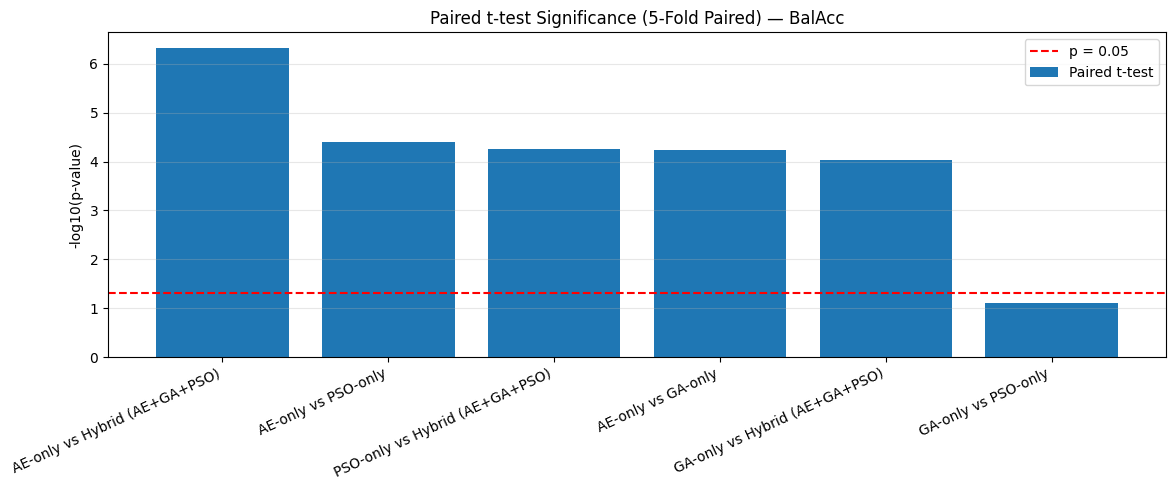

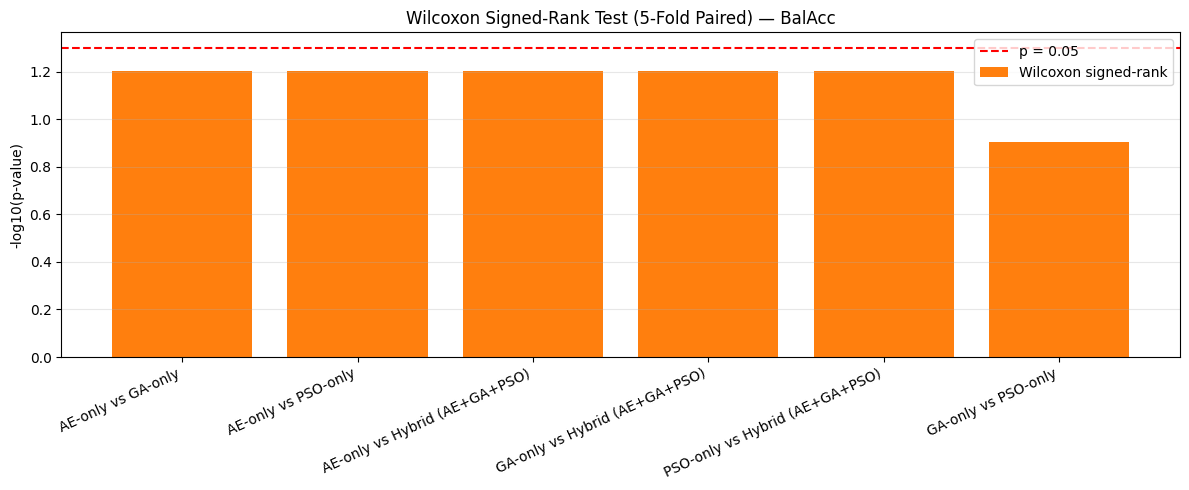

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.stats import ttest_rel, wilcoxon

data = {
    "AE-only": {
        "TrainAcc": [0.96537, 0.96562, 0.96667, 0.96614, 0.96580],
        "BalAcc":   [0.96660, 0.96671, 0.96687, 0.96644, 0.96810],
        "MacPrec":  [0.70561, 0.69672, 0.70642, 0.70460, 0.68701],
        "MacRec":   [0.96660, 0.96671, 0.96687, 0.96644, 0.96810],
        "MacF1":    [0.77918, 0.76972, 0.78007, 0.77810, 0.75914],
        "AUC":      [0.99273, 0.99200, 0.99255, 0.99246, 0.99201],
    },
    "GA-only": {
        "TrainAcc": [0.97283, 0.97294, 0.97303, 0.97303, 0.97282],
        "BalAcc":   [0.97319, 0.97384, 0.97328, 0.97430, 0.97369],
        "MacPrec":  [0.70628, 0.71378, 0.70762, 0.72741, 0.71731],
        "MacRec":   [0.97319, 0.97384, 0.97328, 0.97430, 0.97369],
        "MacF1":    [0.78084, 0.78875, 0.78226, 0.80249, 0.79232],
        "AUC":      [0.99335, 0.99340, 0.99338, 0.99338, 0.99334],
    },
    "PSO-only": {
        "TrainAcc": [0.97334, 0.97359, 0.97354, 0.97360, 0.97353],
        "BalAcc":   [0.97389, 0.97423, 0.97437, 0.97428, 0.97385],
        "MacPrec":  [0.70980, 0.72395, 0.71734, 0.73352, 0.71843],
        "MacRec":   [0.97389, 0.97423, 0.97437, 0.97428, 0.97385],
        "MacF1":    [0.78463, 0.79907, 0.79246, 0.80841, 0.79348],
        "AUC":      [0.99357, 0.99359, 0.99361, 0.99353, 0.99361],
    },
    "Hybrid (AE+GA+PSO)": {
        "TrainAcc": [0.9791, 0.9800, 0.9798, 0.9788, 0.9802],
        "BalAcc":   [0.9791, 0.9800, 0.9798, 0.9788, 0.9802],
        "MacPrec":  [0.9794, 0.9802, 0.9800, 0.9792, 0.9804],
        "MacRec":   [0.9791, 0.9800, 0.9798, 0.9788, 0.9802],
        "MacF1":    [0.9791, 0.9800, 0.9798, 0.9788, 0.9802],
        "AUC":      [0.9956, 0.9960, 0.9957, 0.9957, 0.9957],
    },
}

TTEST_COLOR = "#1f77b4"
WILCOX_COLOR = "#ff7f0e"
THRESH_COLOR = "red"

def paired_clean(x, y):
    x = np.asarray(x, dtype=float).ravel()
    y = np.asarray(y, dtype=float).ravel()
    n = min(len(x), len(y))
    x, y = x[:n], y[:n]
    mask = ~np.isnan(x) & ~np.isnan(y)
    return x[mask], y[mask]

def safe_wilcoxon(x, y):
    if len(x) < 2:
        return (np.nan, np.nan)
    d = x - y
    if np.allclose(d, 0):
        return (0.0, 1.0)
    try:
        stat, p = wilcoxon(
            x, y,
            zero_method="wilcox",
            alternative="two-sided",
            mode="auto"
        )
        return (float(stat), float(p))
    except Exception:
        return (np.nan, np.nan)

def p_to_neglog10(p):
    p = float(p)
    if np.isnan(p):
        return np.nan
    return -np.log10(max(p, 1e-300))

def compute_pairwise_tests(metric="BalAcc"):
    variants = list(data.keys())
    rows = []
    for a, b in combinations(variants, 2):
        if metric not in data[a] or metric not in data[b]:
            continue
        xa, xb = paired_clean(data[a][metric], data[b][metric])
        if len(xa) < 2:
            continue
        t_stat, t_p = ttest_rel(xa, xb)
        w_stat, w_p = safe_wilcoxon(xa, xb)
        rows.append({
            "Metric": metric,
            "Comparison": f"{a} vs {b}",
            "t_stat": float(t_stat),
            "t_p": float(t_p),
            "wilcoxon_stat": float(w_stat) if not np.isnan(w_stat) else np.nan,
            "wilcoxon_p": float(w_p) if not np.isnan(w_p) else np.nan,
            "neglog10_t_p": p_to_neglog10(t_p),
            "neglog10_w_p": p_to_neglog10(w_p),
        })
    return pd.DataFrame(rows)

def plot_ttest_bars(df_tests, metric="BalAcc", alpha=0.05):
    if df_tests.empty:
        raise ValueError("df_tests is empty. Check metric name and data availability.")
    df = df_tests.copy().sort_values("t_p", ascending=True)
    x = np.arange(len(df))
    plt.figure(figsize=(12, 5))
    plt.bar(x, df["neglog10_t_p"], color=TTEST_COLOR, label="Paired t-test")
    thr = -np.log10(alpha)
    plt.axhline(thr, linestyle="--", color=THRESH_COLOR, label=f"p = {alpha}")
    plt.xticks(x, df["Comparison"], rotation=25, ha="right")
    plt.ylabel("-log10(p-value)")
    plt.title(f"Paired t-test Significance (5-Fold Paired) — {metric}")
    plt.grid(axis="y", alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_wilcoxon_bars(df_tests, metric="BalAcc", alpha=0.05):
    if df_tests.empty:
        raise ValueError("df_tests is empty. Check metric name and data availability.")
    df = df_tests.copy().sort_values("wilcoxon_p", ascending=True)
    x = np.arange(len(df))
    plt.figure(figsize=(12, 5))
    plt.bar(x, df["neglog10_w_p"], color=WILCOX_COLOR, label="Wilcoxon signed-rank")
    thr = -np.log10(alpha)
    plt.axhline(thr, linestyle="--", color=THRESH_COLOR, label=f"p = {alpha}")
    plt.xticks(x, df["Comparison"], rotation=25, ha="right")
    plt.ylabel("-log10(p-value)")
    plt.title(f"Wilcoxon Signed-Rank Test (5-Fold Paired) — {metric}")
    plt.grid(axis="y", alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    metric_to_test = "BalAcc"
    alpha = 0.05
    df_tests = compute_pairwise_tests(metric=metric_to_test)
    if df_tests.empty:
        print("No tests computed. Check your metric name/data.")
    else:
        print(
            df_tests[["Comparison", "t_p", "wilcoxon_p", "neglog10_t_p", "neglog10_w_p"]]
            .sort_values("wilcoxon_p", ascending=True)
            .to_string(index=False)
        )
        plot_ttest_bars(df_tests, metric=metric_to_test, alpha=alpha)
        plot_wilcoxon_bars(df_tests, metric=metric_to_test, alpha=alpha)


p-paired and Wilicoxon tests on proposed hybrid CA-GP technique (Comparison of both statistical p-tests)

                    Comparison      t_p  wilcoxon_p  neglog10_t_p  neglog10_w_p
            AE-only vs GA-only 0.000059    0.062500      4.229489      1.204120
           AE-only vs PSO-only 0.000041    0.062500      4.389849      1.204120
 AE-only vs Hybrid (AE+GA+PSO) 0.000000    0.062500      6.326427      1.204120
           GA-only vs PSO-only 0.078517    0.125000      1.105035      0.903090
 GA-only vs Hybrid (AE+GA+PSO) 0.000092    0.062500      4.035825      1.204120
PSO-only vs Hybrid (AE+GA+PSO) 0.000056    0.062500      4.252949      1.204120


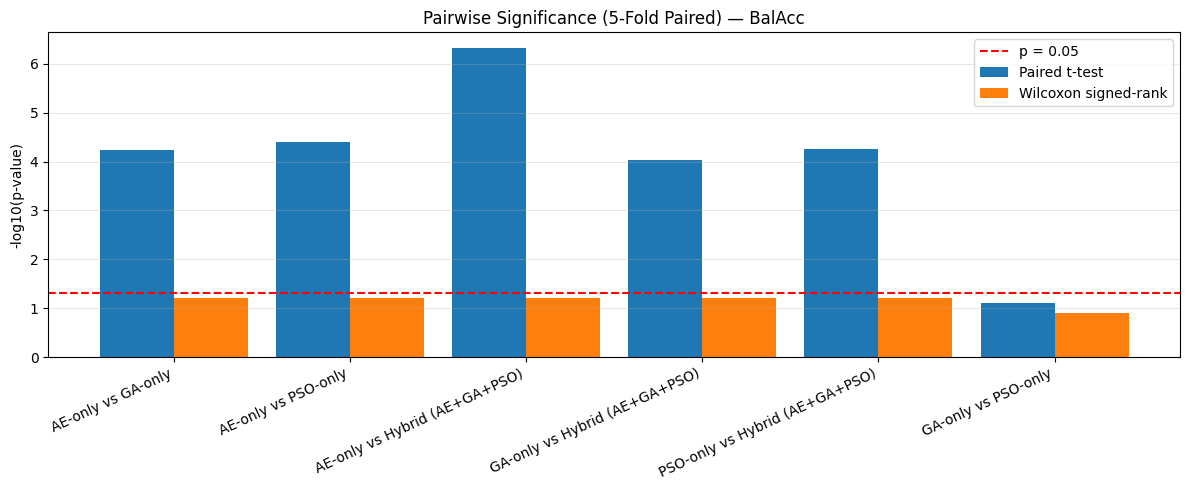

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.stats import ttest_rel, wilcoxon

data = {
    "AE-only": {
        "TrainAcc": [0.96537, 0.96562, 0.96667, 0.96614, 0.96580],
        "BalAcc":   [0.96660, 0.96671, 0.96687, 0.96644, 0.96810],
        "MacPrec":  [0.70561, 0.69672, 0.70642, 0.70460, 0.68701],
        "MacRec":   [0.96660, 0.96671, 0.96687, 0.96644, 0.96810],
        "MacF1":    [0.77918, 0.76972, 0.78007, 0.77810, 0.75914],
        "AUC":      [0.99273, 0.99200, 0.99255, 0.99246, 0.99201],
    },
    "GA-only": {
        "TrainAcc": [0.97283, 0.97294, 0.97303, 0.97303, 0.97282],
        "BalAcc":   [0.97319, 0.97384, 0.97328, 0.97430, 0.97369],
        "MacPrec":  [0.70628, 0.71378, 0.70762, 0.72741, 0.71731],
        "MacRec":   [0.97319, 0.97384, 0.97328, 0.97430, 0.97369],
        "MacF1":    [0.78084, 0.78875, 0.78226, 0.80249, 0.79232],
        "AUC":      [0.99335, 0.99340, 0.99338, 0.99338, 0.99334],
    },
    "PSO-only": {
        "TrainAcc": [0.97334, 0.97359, 0.97354, 0.97360, 0.97353],
        "BalAcc":   [0.97389, 0.97423, 0.97437, 0.97428, 0.97385],
        "MacPrec":  [0.70980, 0.72395, 0.71734, 0.73352, 0.71843],
        "MacRec":   [0.97389, 0.97423, 0.97437, 0.97428, 0.97385],
        "MacF1":    [0.78463, 0.79907, 0.79246, 0.80841, 0.79348],
        "AUC":      [0.99357, 0.99359, 0.99361, 0.99353, 0.99361],
    },
    "Hybrid (AE+GA+PSO)": {
        "TrainAcc": [0.9791, 0.9800, 0.9798, 0.9788, 0.9802],
        "BalAcc":   [0.9791, 0.9800, 0.9798, 0.9788, 0.9802],
        "MacPrec":  [0.9794, 0.9802, 0.9800, 0.9792, 0.9804],
        "MacRec":   [0.9791, 0.9800, 0.9798, 0.9788, 0.9802],
        "MacF1":    [0.9791, 0.9800, 0.9798, 0.9788, 0.9802],
        "AUC":      [0.9956, 0.9960, 0.9957, 0.9957, 0.9957],
    },
}

def paired_clean(x, y):
    x = np.asarray(x, dtype=float).ravel()
    y = np.asarray(y, dtype=float).ravel()
    n = min(len(x), len(y))
    x, y = x[:n], y[:n]
    mask = ~np.isnan(x) & ~np.isnan(y)
    return x[mask], y[mask]

def safe_wilcoxon(x, y):
    if len(x) < 2:
        return (np.nan, np.nan)
    d = x - y
    if np.allclose(d, 0):
        return (0.0, 1.0)
    try:
        stat, p = wilcoxon(x, y, zero_method="wilcox", alternative="two-sided", mode="auto")
        return (float(stat), float(p))
    except Exception:
        return (np.nan, np.nan)

def p_to_neglog10(p):
    p = float(p)
    if np.isnan(p):
        return np.nan
    return -np.log10(max(p, 1e-300))

def compute_pairwise_tests(metric="BalAcc"):
    variants = list(data.keys())
    rows = []

    for a, b in combinations(variants, 2):
        if metric not in data[a] or metric not in data[b]:
            continue

        xa, xb = paired_clean(data[a][metric], data[b][metric])
        if len(xa) < 2:
            continue

        t_stat, t_p = ttest_rel(xa, xb)
        w_stat, w_p = safe_wilcoxon(xa, xb)

        rows.append({
            "Metric": metric,
            "Comparison": f"{a} vs {b}",
            "t_stat": t_stat,
            "t_p": t_p,
            "wilcoxon_stat": w_stat,
            "wilcoxon_p": w_p,
            "neglog10_t_p": p_to_neglog10(t_p),
            "neglog10_w_p": p_to_neglog10(w_p),
        })

    return pd.DataFrame(rows)

def plot_pvalue_bars(df_tests, metric="BalAcc", alpha=0.05):
    if df_tests.empty:
        raise ValueError("df_tests is empty. Check metric name and data availability.")

    df = df_tests.copy().sort_values("wilcoxon_p", ascending=True)

    x = np.arange(len(df))
    width = 0.42

    plt.figure(figsize=(12, 5))
    plt.bar(x - width/2, df["neglog10_t_p"], width=width, label="Paired t-test")
    plt.bar(x + width/2, df["neglog10_w_p"], width=width, label="Wilcoxon signed-rank")

    thr = -np.log10(alpha)
    plt.axhline(thr, linestyle="--", color="red", label=f"p = {alpha}")

    plt.xticks(x, df["Comparison"], rotation=25, ha="right")
    plt.ylabel("-log10(p-value)")
    plt.title(f"Pairwise Significance (5-Fold Paired) — {metric}")
    plt.grid(axis="y", alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

metric_to_test = "BalAcc"

df_tests = compute_pairwise_tests(metric=metric_to_test)
print(df_tests[["Comparison", "t_p", "wilcoxon_p", "neglog10_t_p", "neglog10_w_p"]].to_string(index=False))

plot_pvalue_bars(df_tests, metric=metric_to_test, alpha=0.05)

AUC-ROC Curve of all variants of proposed hybrid CA-GP technique

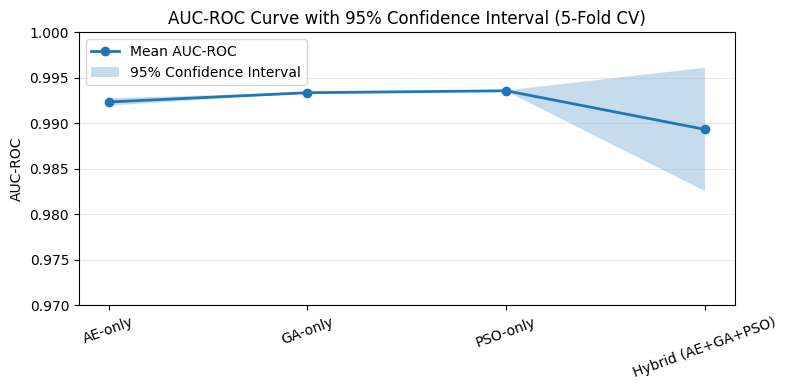

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


methods = [
    "AE-only",
    "GA-only",
    "PSO-only",
    "Hybrid (AE+GA+PSO)"
]

x = np.arange(len(methods))

auc_mean = np.array([
    0.992351,
    0.993368,
    0.993580,
    0.989337
])

auc_low = np.array([
    0.991941,
    0.993336,
    0.993539,
    0.982556
])

auc_high = np.array([
    0.992762,
    0.993400,
    0.993621,
    0.996117
])


plt.figure(figsize=(8, 4))

plt.plot(
    x,
    auc_mean,
    marker="o",
    linewidth=2,
    label="Mean AUC-ROC"
)

plt.fill_between(
    x,
    auc_low,
    auc_high,
    alpha=0.25,
    label="95% Confidence Interval"
)

plt.xticks(x, methods, rotation=20)
plt.ylabel("AUC-ROC")
plt.ylim(0.97, 1.00)
plt.title("AUC-ROC Curve with 95% Confidence Interval (5-Fold CV)")
plt.grid(axis="y", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

### 2. Check column names, value types, and unique values

In [24]:
print(f"Columns: {cols}")
print(f"ROWS: {rows}")

Columns: ['course_id', 'userid_DI', 'registered', 'viewed', 'explored', 'certified', 'final_cc_cname_DI', 'LoE_DI', 'YoB', 'gender', 'grade', 'start_time_DI', 'last_event_DI', 'nevents', 'ndays_act', 'nplay_video', 'nchapters', 'nforum_posts', 'roles', 'incomplete_flag']
ROWS: 641138


In [25]:
def explore(df):
    column_list = df.columns.tolist()

    print("Rows:", len(df))
    print()

    for column_name in column_list:
        print(column_name, type(df[column_name].iloc[0]))
        print(df[column_name].unique())
        print()

### 3. Cleanse & Transform Dataset

In [28]:
%time
mooc = mooc[mooc.incomplete_flag != 1]

mooc['grade'] = mooc.grade.fillna(' ')
mooc = mooc[mooc.grade != ' ']
mooc['grade'] = mooc['grade'].astype(float)

mooc['LoE_DI'] = mooc.LoE_DI.fillna(0)
mooc = mooc[mooc.LoE_DI != 0]
mooc['LoE_DI'] = mooc['LoE_DI'].map({'Less than Secondary':0,'Secondary':1,
                                     "Bachelor's":2,"Master's":3,'Doctorate':4})

mooc['YoB'] = mooc.YoB.fillna(0)
mooc = mooc[mooc.YoB != 0]

mooc['start_time_DI'] = mooc.start_time_DI.fillna(0)
mooc = mooc[mooc.start_time_DI != 0]
mooc['start_time_DI'] = pd.DatetimeIndex(mooc['start_time_DI']).date

mooc['last_event_DI'] = mooc.last_event_DI.fillna(0)
mooc = mooc[mooc.last_event_DI != 0]
mooc['last_event_DI'] = pd.DatetimeIndex(mooc['last_event_DI']).date

mooc['nevents'] = mooc.nevents.fillna(0)
mooc = mooc[mooc.nevents != 0]

mooc['ndays_act'] = mooc.ndays_act.fillna(0)
mooc = mooc[mooc.ndays_act != 0]

mooc['nplay_video'] = mooc.nplay_video.fillna(0)
mooc = mooc[mooc.nplay_video != 0]

mooc['nchapters'] = mooc.nchapters.fillna(0)
mooc = mooc[mooc.nchapters != 0]

mooc['gender'] = mooc.gender.fillna(0)
mooc = mooc[mooc.gender != 0]

CPU times: total: 0 ns
Wall time: 13.1 μs


### 2. Define functions that return new values when applied to a row

In [29]:
def letter_grade(row):
    grd = row.grade
    letter = ''
    if (0.90 <= grd <= 1): letter = 'A'
    elif (0.80 <= grd < 0.90): letter = 'B'
    elif (0.70 <= grd < 0.80): letter = 'C'
    elif (0.60 <= grd < 0.70): letter = 'D'
    else: letter = 'F'
    return letter

def age_range(row):
    rng = ''
    if (13 <= row.age < 18): rng = 'teenagers < 18'
    elif (18 <= row.age < 30): rng = '18-29'
    elif (30 <= row.age < 40): rng = '30s'
    elif (40 <= row.age < 50): rng = '40s'
    elif (50 <= row.age < 60): rng = '50s'
    elif (60 <= row.age < 70): rng = '60s'
    elif (70 <= row.age): rng = '70+'
    else: rng = ' '
    return rng

def get_course_value(row, df):
    for crs_code in df.index:
        if row.course_code == crs_code:
            return int(df.loc[crs_code].item())


### 3. Generate New Features

In [30]:
%time

mooc["letter_grade"] = mooc.apply(lambda row: letter_grade(row), axis=1)

outcome_key = (
    mooc["certified"].replace({1: "Certified:", 0: "Not Certified:"})
    + " "
    + mooc["letter_grade"]
)

outcome_map = {
    "Not Certified: F": 0, "Not Certified: D": 1, "Not Certified: C": 2,
    "Certified: F": 3, "Certified: D": 4, "Certified: C": 5,
    "Certified: B": 6, "Certified: A": 7
}

mooc["outcome"] = outcome_key.map(outcome_map)

reverse_outcome_map = {v: k for k, v in outcome_map.items()}
mooc["Outcome"] = mooc["outcome"].map(reverse_outcome_map)

parts = mooc["course_id"].astype("string").str.split("/", expand=True)
mooc["institution"] = parts[0]
mooc["course_code"]  = parts[1]
mooc["semester"]     = parts[2]

mooc["start_year"] = (
    mooc["semester"].astype("string").str.split("_", expand=True)[0]
    .astype("Int64")
)

mooc["YoB"] = pd.to_numeric(mooc["YoB"], errors="coerce")
mooc["age"] = mooc["start_year"].astype("float") - mooc["YoB"]

mooc["age_range"] = mooc.apply(lambda row: age_range(row), axis=1)
mooc = mooc[mooc["age_range"].ne(" ")]

mooc["max_nchapters"]     = mooc.groupby("course_code")["nchapters"].transform("max")
mooc["%max_chapters_viewed"] = (mooc["nchapters"] / mooc["max_nchapters"]).fillna(0)

mooc["max_nplay_video"]   = mooc.groupby("course_code")["nplay_video"].transform("max")
mooc["max_nforum_posts"]  = mooc.groupby("course_code")["nforum_posts"].transform("max")
mooc["max_nevents"]       = mooc.groupby("course_code")["nevents"].transform("max")
mooc["max_ndays_act"]     = mooc.groupby("course_code")["ndays_act"].transform("max")

den = mooc["nevents"].replace(0, np.nan)
mooc["nplay_video/nevents"]   = (mooc["nplay_video"] / den).fillna(0)
mooc["nchapters/nevents"]     = (mooc["nchapters"] / den).fillna(0)
mooc["nforum_posts/nevents"]  = (mooc["nforum_posts"] / den).fillna(0)

den_days = mooc["max_ndays_act"].replace(0, np.nan)
mooc["nevents_per_day"]       = (mooc["nevents"] / den_days).fillna(0)
mooc["nplay_video_per_day"]   = (mooc["nplay_video"] / den_days).fillna(0)
mooc["nchapters_per_day"]     = (mooc["nchapters"] / den_days).fillna(0)
mooc["nforum_posts_per_day"]  = (mooc["nforum_posts"] / den_days).fillna(0)

den_v = mooc["nplay_video"].replace(0, np.nan)
den_c = mooc["nchapters"].replace(0, np.nan)
den_f = mooc["nforum_posts"].replace(0, np.nan)

mooc["ndays_play_video"]    = (mooc["nplay_video"] * (mooc["ndays_act"] / den_v)).fillna(0)
mooc["ndays_chapters"]      = (mooc["nchapters"] * (mooc["ndays_act"] / den_c)).fillna(0)
mooc["ndays_forum_posts"]   = (mooc["nforum_posts"] * (mooc["ndays_act"] / den_f)).fillna(0)

CPU times: total: 0 ns
Wall time: 9.54 μs


In [31]:
mooc.columns

Index(['course_id', 'userid_DI', 'registered', 'viewed', 'explored',
       'certified', 'final_cc_cname_DI', 'LoE_DI', 'YoB', 'gender', 'grade',
       'start_time_DI', 'last_event_DI', 'nevents', 'ndays_act', 'nplay_video',
       'nchapters', 'nforum_posts', 'roles', 'incomplete_flag', 'letter_grade',
       'outcome', 'Outcome', 'institution', 'course_code', 'semester',
       'start_year', 'age', 'age_range', 'max_nchapters',
       '%max_chapters_viewed', 'max_nplay_video', 'max_nforum_posts',
       'max_nevents', 'max_ndays_act', 'nplay_video/nevents',
       'nchapters/nevents', 'nforum_posts/nevents', 'nevents_per_day',
       'nplay_video_per_day', 'nchapters_per_day', 'nforum_posts_per_day',
       'ndays_play_video', 'ndays_chapters', 'ndays_forum_posts'],
      dtype='str')

###4. Check enrollment & Grade Range counts

In [32]:
course_enrollment = mooc["course_code"].value_counts().to_frame(name="count")
institution_enrollment = mooc["institution"].value_counts().to_frame(name="count")
letter_grade_counts = mooc["letter_grade"].value_counts().to_frame(name="count")

print("HarvardX courses:", mooc.loc[mooc["institution"] == "HarvardX", "course_code"].unique())
print("MITx courses:", mooc.loc[mooc["institution"] == "MITx", "course_code"].unique())
print()

print("Student Enrollment per School")
print(institution_enrollment)
print()

print("Student Enrollment per Course")
print(course_enrollment)
print()

print("Letter Grades (Grade Ranges)")
print(letter_grade_counts)

HarvardX courses: <ArrowStringArray>
['PH207x', 'PH278x']
Length: 2, dtype: string
MITx courses: <ArrowStringArray>
['14.73x', '8.02x', '6.00x', '6.002x', '7.00x', '8.MReV', '2.01x', '3.091x']
Length: 8, dtype: string

Student Enrollment per School
              count
institution        
MITx         104644
HarvardX      25199

Student Enrollment per Course
             count
course_code       
6.00x        51437
PH207x       16516
6.002x       15919
14.73x       10655
8.02x        10544
PH278x        8683
7.00x         7614
3.091x        6022
2.01x         2099
8.MReV         354

Letter Grades (Grade Ranges)
               count
letter_grade        
F             120060
A               3633
B               2827
C               1755
D               1568


###5. Data Exploration: All Courses

Create datasets for predicting outcomes and grade ranges in schools and courses

In [33]:
cols_grade = ['grade',
    'viewed','explored','ndays_act','nplay_video','%max_chapters_viewed','nevents','nforum_posts',
    'LoE_DI','age','age_range','final_cc_cname_DI','gender',
    'institution','course_code', 'semester','start_year']
cols_letter_grade = ['letter_grade',
    'viewed','explored','ndays_act','nplay_video','%max_chapters_viewed','nevents','nforum_posts',
    'LoE_DI','age','age_range','final_cc_cname_DI','gender',
    'institution','course_code', 'semester','start_year']
cols_cert = ['certified',
    'viewed','explored','ndays_act','nplay_video','%max_chapters_viewed','nevents','nforum_posts',
    'LoE_DI','age','age_range','final_cc_cname_DI','gender',
    'institution','course_code', 'semester','start_year']

mooc_letter = mooc[cols_letter_grade]
mooc_cert = mooc[cols_cert]

y_let = mooc_letter['letter_grade'].map({'F':0, 'A':1, 'B':2, 'C':3, 'D':4})
X_let = pd.get_dummies(mooc_letter[cols_letter_grade[1:]])

y_HarvardX_letter = mooc_letter['letter_grade'][mooc_letter['institution']=='HarvardX'].map({'F':0, 'A':1, 'B':2, 'C':3, 'D':4})
X_HarvardX_letter = pd.get_dummies(mooc_letter[cols_letter_grade[1:]][mooc['institution']=='HarvardX'])

y_MITx_letter = mooc_letter['letter_grade'][mooc_letter['institution']=='MITx'].map({'F':0, 'A':1, 'B':2, 'C':3, 'D':4})
X_MITx_letter = pd.get_dummies(mooc_letter[cols_letter_grade[1:]][mooc_letter['institution']=='MITx'])

y_HarvardX_cert = mooc_cert['certified'][mooc_cert['institution']=='HarvardX']
X_HarvardX_cert = pd.get_dummies(mooc_cert[cols_cert[1:]][mooc_cert['institution']=='HarvardX'])

y_MITx_cert = mooc_cert['certified'][mooc_cert['institution']=='MITx']
X_MITx_cert = pd.get_dummies(mooc_cert[cols_cert[1:]][mooc_cert['institution']=='MITx'])

X_train_let, X_test_let, y_train_let, y_test_let = train_test_split(X_let, y_let, test_size=0.25, random_state=777)

X_train_H_let, X_test_H_let, y_train_H_let, y_test_H_let = train_test_split(
    X_HarvardX_letter, y_HarvardX_letter, test_size=0.25, random_state=777)

X_train_M_let, X_test_M_let, y_train_M_let, y_test_M_let = train_test_split(
    X_MITx_letter, y_MITx_letter, test_size=0.25, random_state=777)

X_train_H_cert, X_test_H_cert, y_train_H_cert, y_test_H_cert = train_test_split(
    X_HarvardX_cert, y_HarvardX_cert, test_size=0.25, random_state=777)

X_train_M_cert, X_test_M_cert, y_train_M_cert, y_test_M_cert = train_test_split(
    X_MITx_cert, y_MITx_cert, test_size=0.25, random_state=777)

In [35]:
from sklearn.model_selection import train_test_split

mask_H = mooc_letter['institution'] == 'HarvardX'

X_HarvardX_letter = pd.get_dummies(mooc_letter.loc[mask_H, cols_letter_grade[1:]])
y_HarvardX_letter = mooc_letter.loc[mask_H, 'letter_grade'].map(
    {'F':0, 'A':1, 'B':2, 'C':3, 'D':4}
)

if len(X_HarvardX_letter) > 0:
    X_train_H_let, X_test_H_let, y_train_H_let, y_test_H_let = train_test_split(
        X_HarvardX_letter, y_HarvardX_letter,
        test_size=0.25,
        random_state=777,
        stratify=y_HarvardX_letter
    )
else:
    print("⚠️ No HarvardX letter-grade data available")

mask_H = mooc_cert['institution'] == 'HarvardX'
X_HarvardX_cert = pd.get_dummies(mooc_cert.loc[mask_H, cols_cert[1:]])
y_HarvardX_cert = mooc_cert.loc[mask_H, 'certified']

X_train_H_cert, X_test_H_cert, y_train_H_cert, y_test_H_cert = train_test_split(
    X_HarvardX_cert, y_HarvardX_cert,
    test_size=0.25,
    random_state=777,
    stratify=y_HarvardX_cert
)

mask_M = mooc_cert['institution'] == 'MITx'
X_MITx_cert = pd.get_dummies(mooc_cert.loc[mask_M, cols_cert[1:]])
y_MITx_cert = mooc_cert.loc[mask_M, 'certified']

if len(X_MITx_cert) > 0:
    X_train_M_cert, X_test_M_cert, y_train_M_cert, y_test_M_cert = train_test_split(
        X_MITx_cert, y_MITx_cert,
        test_size=0.25,
        random_state=777,
        stratify=y_MITx_cert
    )
else:
    print("⚠️ No MITx certification data available")

### 6B. Feature Selection (Chi2 / ANOVA / Mutual Info / RFE / L1 / GBM)

This section runs robust feature selection on the **HMXPC13_DI_v2_5-14-14.csv** dataset (target: **certified**).
It sanitizes NaN/Inf, imputes/normalizes using **train-only fit**, and exports tables + plots.


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, chi2, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

RANDOM_STATE = 42
TARGET_COL = "certified"

candidate_paths = [
    "HMXPC13_DI_v2_5-14-14.csv",
    "/mnt/data/HMXPC13_DI_v2_5-14-14.csv",
]

data_path = None
for p in candidate_paths:
    if os.path.exists(p):
        data_path = p
        break

if data_path is None:
    raise FileNotFoundError(
        "Could not find HMXPC13 dataset. Tried:\n" + "\n".join(candidate_paths)
    )

df = pd.read_csv(
    data_path,
    parse_dates=["start_time_DI", "last_event_DI"],
    infer_datetime_format=True
)
print("Loaded:", data_path, "| shape:", df.shape)

if TARGET_COL not in df.columns:
    raise ValueError(
        f"Target column '{TARGET_COL}' not found. Available columns: {list(df.columns)[:30]}..."
    )

X = df.drop(columns=[TARGET_COL]).copy()
y = df[TARGET_COL].copy()

y = pd.to_numeric(y, errors="coerce").fillna(0)
y = (y > 0).astype(int)

X = X.select_dtypes(include=[np.number]).copy()

nunique = X.nunique(dropna=False)
const_cols = nunique[nunique <= 1].index.tolist()
if len(const_cols) > 0:
    print("Dropped constant columns:", const_cols[:20], "..." if len(const_cols) > 20 else "")
    X.drop(columns=const_cols, inplace=True)

all_nan_cols = X.columns[X.isna().all()].tolist()
if len(all_nan_cols) > 0:
    print("Dropped all-NaN columns:", all_nan_cols)
    X.drop(columns=all_nan_cols, inplace=True)

if X.shape[1] < 2:
    raise ValueError(f"Not enough usable features after cleaning. Features left: {X.shape[1]}")

numerical_cols = X.columns
X[numerical_cols] = X[numerical_cols].replace([np.inf, -np.inf], np.nan)

too_large = 1e308
X[numerical_cols] = X[numerical_cols].mask(X[numerical_cols].abs() > too_large, np.nan)

X[numerical_cols] = X[numerical_cols].fillna(X[numerical_cols].median())

stratify_y = y if y.nunique() == 2 else None

X_train_raw, X_test_raw, y_train_fs, y_test_fs = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=stratify_y
)

feature_names = X_train_raw.columns.to_numpy()

imputer = SimpleImputer(strategy="median")
X_train_imp = imputer.fit_transform(X_train_raw)
X_test_imp  = imputer.transform(X_test_raw)

scaler = MinMaxScaler()
X_train_fs = scaler.fit_transform(X_train_imp)
X_test_fs  = scaler.transform(X_test_imp)

k = min(10, X_train_fs.shape[1])
if k < 2:
    raise ValueError(f"Not enough usable features. Found only {X_train_fs.shape[1]} feature(s).")


chi_selector = SelectKBest(score_func=chi2, k=k)
chi_selector.fit(X_train_fs, y_train_fs)
chi_scores = pd.DataFrame({
    "Feature": feature_names,
    "Chi2 Score": chi_selector.scores_
}).sort_values(by="Chi2 Score", ascending=False)

anova_selector = SelectKBest(score_func=f_classif, k=k)
anova_selector.fit(X_train_fs, y_train_fs)
anova_scores = pd.DataFrame({
    "Feature": feature_names,
    "F-Score": anova_selector.scores_
}).sort_values(by="F-Score", ascending=False)

mi_scores = mutual_info_classif(X_train_fs, y_train_fs, random_state=RANDOM_STATE)
mi_scores_df = pd.DataFrame({
    "Feature": feature_names,
    "Mutual Info": mi_scores
}).sort_values(by="Mutual Info", ascending=False)

log_model = LogisticRegression(max_iter=3000, solver="liblinear", random_state=RANDOM_STATE)
rfe_selector = RFE(estimator=log_model, n_features_to_select=k)
rfe_selector.fit(X_train_fs, y_train_fs)
rfe_features = feature_names[rfe_selector.support_]

l1_log = LogisticRegression(
    penalty="l1", solver="liblinear", max_iter=4000, random_state=RANDOM_STATE
)
l1_log.fit(X_train_fs, y_train_fs)

l1_importance = pd.DataFrame({
    "Feature": feature_names,
    "L1 Coeff": l1_log.coef_.ravel()
}).sort_values(by="L1 Coeff", ascending=False, key=lambda s: s.abs())

gbm = GradientBoostingClassifier(random_state=RANDOM_STATE)
gbm.fit(X_train_fs, y_train_fs)
gbm_importance = pd.DataFrame({
    "Feature": feature_names,
    "GBM Importance": gbm.feature_importances_
}).sort_values(by="GBM Importance", ascending=False)

out_folder = "Feature_Selection_Outputs1"
os.makedirs(out_folder, exist_ok=True)

chi_scores.to_csv(f"{out_folder}/chi2_scores.csv", index=False)
anova_scores.to_csv(f"{out_folder}/anova_scores.csv", index=False)
mi_scores_df.to_csv(f"{out_folder}/mutual_info_scores.csv", index=False)
l1_importance.to_csv(f"{out_folder}/l1_logistic_coeffs.csv", index=False)
gbm_importance.to_csv(f"{out_folder}/gbm_importance.csv", index=False)

graphs_folder = "Feature_Selection_Graphs"
os.makedirs(graphs_folder, exist_ok=True)

plt.figure(figsize=(10, 5))
sns.barplot(x=chi_scores.head(k)["Feature"], y=chi_scores.head(k)["Chi2 Score"])
plt.xticks(rotation=90)
plt.title("Chi-Square Feature Importance")
plt.tight_layout()
plt.savefig(f"{graphs_folder}/chi_square.png", dpi=200)
plt.close()

plt.figure(figsize=(10, 5))
sns.barplot(x=anova_scores.head(k)["Feature"], y=anova_scores.head(k)["F-Score"])
plt.xticks(rotation=90)
plt.title("ANOVA Feature Importance")
plt.tight_layout()
plt.savefig(f"{graphs_folder}/anova.png", dpi=200)
plt.close()

corr_df = pd.DataFrame(X_train_fs, columns=feature_names)

max_corr_cols = 60
if corr_df.shape[1] > max_corr_cols:
    corr_df = corr_df[mi_scores_df["Feature"].head(max_corr_cols).values]

plt.figure(figsize=(12, 10))
sns.heatmap(corr_df.corr(), cmap="coolwarm", annot=False)
plt.title("Pearson Correlation Heatmap (Train Only)")
plt.tight_layout()
plt.savefig(f"{graphs_folder}/correlation.png", dpi=200)
plt.close()

print("Feature Selection Completed Successfully")
print("Usable features:", X_train_fs.shape[1])
print("Top-k used:", k)
print("Graphs saved in:", graphs_folder)
print("Tables saved in:", out_folder)
print("RFE Selected Features:", list(rfe_features))


In [39]:
import os
import pandas as pd

DATASET_TAG = "HMXPC13_DI_v2_5-14-14"
excel_folder = f"Feature_Selection_Excel_{DATASET_TAG}"
os.makedirs(excel_folder, exist_ok=True)

def _save_df_to_excel(obj, filename):
    """Save a DataFrame-like object to Excel if it exists and is non-empty."""
    if obj is None:
        return
    if isinstance(obj, pd.DataFrame) and obj.shape[0] > 0:
        out_path = os.path.join(excel_folder, filename)
        obj.to_excel(out_path, index=False)
        print("Saved:", out_path)

def _get_global(name):
    """Return globals()[name] if present, else None."""
    return globals().get(name, None)

_save_df_to_excel(_get_global("chi_scores"), "chi_square_features.xlsx")

_save_df_to_excel(_get_global("anova_scores"), "anova_features.xlsx")

_save_df_to_excel(_get_global("mi_scores_df"), "mutual_information_features.xlsx")

rfe_features = _get_global("rfe_features")
if rfe_features is not None and len(list(rfe_features)) > 0:
    rfe_df = pd.DataFrame({"Selected Feature": list(rfe_features)})
    _save_df_to_excel(rfe_df, "rfe_selected_features.xlsx")

_save_df_to_excel(_get_global("l1_importance"), "l1_logistic_feature_coefficients.xlsx")

_save_df_to_excel(_get_global("gbm_importance"), "gbm_feature_importance.xlsx")

print("\nFeature selection Excel files saved successfully")
print("Excel folder:", excel_folder)
print("Files saved:", sorted(os.listdir(excel_folder)))


Feature selection Excel files saved successfully
Excel folder: Feature_Selection_Excel_HMXPC13_DI_v2_5-14-14
Files saved: []


Autoencoder Feature Extraction

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

imputer = SimpleImputer(strategy="median")

X_train_imp = imputer.fit_transform(X_train_raw)
X_test_imp  = imputer.transform(X_test_raw)

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train_imp)
X_test  = scaler.transform(X_test_imp)

print("Data split, imputed, and scaled correctly")
print("X_train shape:", X_train.shape)
print("X_test shape :", X_test.shape)

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

DATASET_TAG = "HMXPC13_DI_v2_5-14-14"
out_folder = f"Feature_Selection_Outputs_{DATASET_TAG}"
excel_folder = f"Feature_Selection_Excel_{DATASET_TAG}"
os.makedirs(out_folder, exist_ok=True)
os.makedirs(excel_folder, exist_ok=True)

if "X_train" not in globals():
    raise NameError("X_train is not defined. Run your train/test split + scaling cell first.")

if "feature_names" not in globals():
    raise NameError("feature_names is not defined. Ensure you set feature_names = X_train_raw.columns.to_numpy().")

feature_names_arr = np.array(feature_names).ravel()

X_train_ae = np.asarray(X_train, dtype=np.float32)
X_train_ae = np.nan_to_num(X_train_ae, nan=0.0, posinf=0.0, neginf=0.0)

input_dim = X_train_ae.shape[1]
if input_dim < 2:
    raise ValueError(f"Not enough features for AE. Found input_dim={input_dim}")

encoding_dim = max(2, int(input_dim * 0.5))

inp = Input(shape=(input_dim,))
x = Dense(encoding_dim, activation="relu")(inp)
x = Dropout(0.1)(x)
decoded = Dense(input_dim, activation="linear")(x)

autoencoder = Model(inp, decoded)
autoencoder.compile(optimizer="adam", loss="mse")

autoencoder.fit(
    X_train_ae, X_train_ae,
    epochs=100,
    batch_size=64,
    validation_split=0.1,
    callbacks=[EarlyStopping(patience=8, restore_best_weights=True)],
    verbose=0
)

reconstructions = autoencoder.predict(X_train_ae, verbose=0)
recon_error = np.mean(np.abs(X_train_ae - reconstructions), axis=0)

if len(feature_names_arr) != len(recon_error):
    raise ValueError(
        f"feature_names length ({len(feature_names_arr)}) != recon_error length ({len(recon_error)}). "
        "Make sure feature_names comes from the same X used to build X_train."
    )

ae_scores = pd.DataFrame({
    "Feature": feature_names_arr,
    "Reconstruction_Error": recon_error
}).sort_values(by="Reconstruction_Error", ascending=False)

k_ae = min(10, ae_scores.shape[0])
ae_selected_features = ae_scores.head(k_ae)["Feature"].tolist()

print("Autoencoder feature selection complete.")
print("Top AE features:", ae_selected_features)
print("Top-k used:", k_ae)

ae_scores.to_csv(f"{out_folder}/autoencoder_reconstruction_error.csv", index=False)
ae_scores.to_excel(f"{excel_folder}/autoencoder_reconstruction_error.xlsx", index=False)

print("Saved CSV:", f"{out_folder}/autoencoder_reconstruction_error.csv")
print("Saved Excel:", f"{excel_folder}/autoencoder_reconstruction_error.xlsx")

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np

imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_imputed)

print("X_scaled shape:", X_scaled.shape)

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_scaled, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    test_size=0.25,
    random_state=42,
    stratify=y_trainval
)

print("Shapes:")
print("X_train:", X_train.shape)
print("X_val  :", X_val.shape)
print("X_test :", X_test.shape)

GA Feature Selection

Gen 01/8 | best=0.794573 | avg=0.672711 | min=0.477359
Gen 02/8 | best=0.800133 | avg=0.783772 | min=0.766312
Gen 03/8 | best=0.800133 | avg=0.796534 | min=0.791904
Gen 04/8 | best=0.807493 | avg=0.800746 | min=0.800133
Gen 05/8 | best=0.807493 | avg=0.801973 | min=0.800133
Gen 06/8 | best=0.807493 | avg=0.800346 | min=0.781036
Gen 07/8 | best=0.807493 | avg=0.807493 | min=0.807493
Gen 08/8 | best=0.807493 | avg=0.807493 | min=0.807493

 GA selected feature count: 4 / 9
GA selected features: ['explored', 'ndays_act', 'nchapters', 'incomplete_flag']
Best GA fitness (bal_acc - penalty): 0.8074932403556095
Test Balanced Accuracy (GA features): 0.8303138692180403


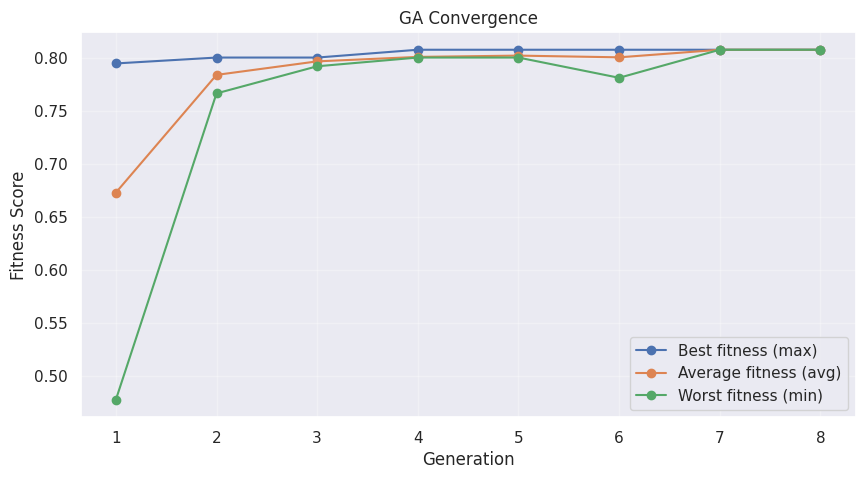

In [ ]:

import numpy as np
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

X_train_ga = np.nan_to_num(np.asarray(X_train, dtype=np.float32), nan=0.0, posinf=0.0, neginf=0.0)
X_val_ga   = np.nan_to_num(np.asarray(X_val,   dtype=np.float32), nan=0.0, posinf=0.0, neginf=0.0)
X_test_ga  = np.nan_to_num(np.asarray(X_test,  dtype=np.float32), nan=0.0, posinf=0.0, neginf=0.0)

y_train_ga = np.asarray(y_train).astype(int)
y_val_ga   = np.asarray(y_val).astype(int)
y_test_ga  = np.asarray(y_test).astype(int)

assert X_train_ga.shape[0] == len(y_train_ga), (X_train_ga.shape[0], len(y_train_ga))
assert X_val_ga.shape[0]   == len(y_val_ga),   (X_val_ga.shape[0], len(y_val_ga))
assert X_test_ga.shape[0]  == len(y_test_ga),  (X_test_ga.shape[0], len(y_test_ga))

num_features = X_train_ga.shape[1]
if num_features < 2:
    raise ValueError(f"Not enough features for GA. Got num_features={num_features}")

POP_SIZE    = 12
GENERATIONS = 8
MUT_P       = 0.01
ELITES_K = 4
LAMBDA = 0.05

fitness_cache = {}

def fitness(individual):
    """
    individual: list of 0/1 of length = num_features
    returns: scalar fitness (higher is better)
    """
    key = tuple(individual)
    if key in fitness_cache:
        return fitness_cache[key]

    idx = [i for i, bit in enumerate(individual) if bit == 1]
    if len(idx) == 0:
        fitness_cache[key] = -1e9
        return -1e9

    clf = LogisticRegression(max_iter=2000, solver="liblinear", random_state=SEED)
    clf.fit(X_train_ga[:, idx], y_train_ga)
    pred_val = clf.predict(X_val_ga[:, idx])

    bal = balanced_accuracy_score(y_val_ga, pred_val)
    penalty = LAMBDA * (len(idx) / num_features)
    score = bal - penalty

    fitness_cache[key] = float(score)
    return float(score)

population = [
    np.random.choice([0, 1], size=num_features).tolist()
    for _ in range(POP_SIZE)
]

ga_best_hist = []
ga_avg_hist  = []
ga_min_hist  = []

for gen in range(GENERATIONS):
    scored = [(ind, fitness(ind)) for ind in population]
    scores = np.array([s for _, s in scored], dtype=float)

    ga_best_hist.append(scores.max())
    ga_avg_hist.append(scores.mean())
    ga_min_hist.append(scores.min())

    scored.sort(key=lambda x: x[1], reverse=True)
    elites = [ind for ind, _ in scored[:ELITES_K]]

    new_pop = elites.copy()
    while len(new_pop) < POP_SIZE:
        p1, p2 = random.sample(elites, 2)

        cut = random.randint(1, num_features - 2)
        child = p1[:cut] + p2[cut:]

        for i in range(num_features):
            if random.random() < MUT_P:
                child[i] = 1 - child[i]

        new_pop.append(child)

    population = new_pop

    print(
        f"Gen {gen+1:02d}/{GENERATIONS} | "
        f"best={ga_best_hist[-1]:.6f} | avg={ga_avg_hist[-1]:.6f} | min={ga_min_hist[-1]:.6f}"
    )

final_scored = [(ind, fitness(ind)) for ind in population]
final_scored.sort(key=lambda x: x[1], reverse=True)

best_ind = final_scored[0][0]
best_fit = final_scored[0][1]

best_idx = [i for i, bit in enumerate(best_ind) if bit == 1]
if len(best_idx) == 0:
    best_idx = [0]

if "feature_names" in globals():
    ga_selected_features = np.asarray(feature_names)[best_idx].tolist()
else:
    ga_selected_features = best_idx

print("\n GA selected feature count:", len(best_idx), "/", num_features)
print("GA selected features:", ga_selected_features)
print("Best GA fitness (bal_acc - penalty):", best_fit)


clf_final = LogisticRegression(max_iter=2000, solver="liblinear", random_state=SEED)
clf_final.fit(X_train_ga[:, best_idx], y_train_ga)
pred_test = clf_final.predict(X_test_ga[:, best_idx])
bal_test = balanced_accuracy_score(y_test_ga, pred_test)

print("Test Balanced Accuracy (GA features):", bal_test)

X_train_ga_sel = X_train_ga[:, best_idx]
X_val_ga_sel   = X_val_ga[:, best_idx]
X_test_ga_sel  = X_test_ga[:, best_idx]


gens = np.arange(1, GENERATIONS + 1)

plt.figure(figsize=(10, 5))
plt.plot(gens, ga_best_hist, marker="o", label="Best fitness (max)")
plt.plot(gens, ga_avg_hist,  marker="o", label="Average fitness (avg)")
plt.plot(gens, ga_min_hist,  marker="o", label="Worst fitness (min)")
plt.xlabel("Generation")
plt.ylabel("Fitness Score")
plt.title("GA Convergence")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

Save Files

In [ ]:
import pandas as pd
out_folder = "Feature_Selection_Outputs5"
os.makedirs(out_folder, exist_ok=True)

pd.DataFrame({"Selected Feature": ga_selected_features}).to_csv(
    f"{out_folder}/ga_selected_features_final.csv", index=False
)
print("Saved:", f"{out_folder}/ga_selected_features_final.csv")

Saved: Feature_Selection_Outputs5/ga_selected_features_final.csv


PSO Feature Selection

Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1
Stopping search: maximum iterations reached --> 1
PSO convergence history collected: 12 iterations
PSO selected count: 5 / 9
PSO selected features: ['viewed', 'explored', 'YoB', 'ndays_act', 'nchapters']
Best PSO objective value (lower is better): 0.19671823116492526
Test Balanced Accuracy (PSO features): 0.8340614787994542


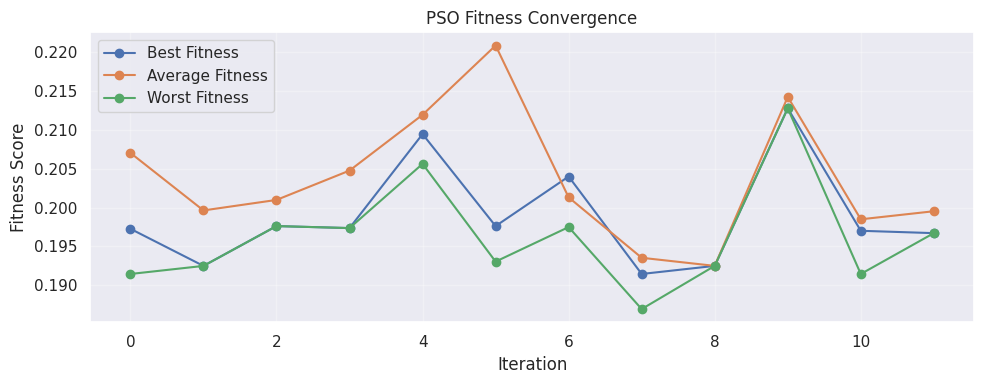

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score
from pyswarm import pso

RANDOM_STATE = 45
np.random.seed(RANDOM_STATE)

X_train_pso = np.nan_to_num(np.asarray(X_train, dtype=np.float32), nan=0.0, posinf=0.0, neginf=0.0)
X_val_pso   = np.nan_to_num(np.asarray(X_val,   dtype=np.float32), nan=0.0, posinf=0.0, neginf=0.0)
X_test_pso  = np.nan_to_num(np.asarray(X_test,  dtype=np.float32), nan=0.0, posinf=0.0, neginf=0.0)

y_train_pso = np.asarray(y_train).astype(int)
y_val_pso   = np.asarray(y_val).astype(int)
y_test_pso  = np.asarray(y_test).astype(int)

n_features = X_train_pso.shape[1]
if n_features < 2:
    raise ValueError(f"Not enough features for PSO. Got n_features={n_features}")

LAMBDA = 0.05

fitness_cache = {}

def pso_objective(x):
    x = np.round(x).astype(int)
    key = tuple(x.tolist())
    if key in fitness_cache:
        return fitness_cache[key]

    idx = np.where(x == 1)[0]

    if idx.size == 0:
        fitness_cache[key] = 1e9
        return 1e9

    model = LogisticRegression(
        max_iter=2000,
        solver="liblinear",
        random_state=RANDOM_STATE
    )
    model.fit(X_train_pso[:, idx], y_train_pso)

    preds_val = model.predict(X_val_pso[:, idx])
    bal_acc = balanced_accuracy_score(y_val_pso, preds_val)

    penalty = LAMBDA * (idx.size / n_features)
    obj = (1 - bal_acc) + penalty

    fitness_cache[key] = float(obj)
    return float(obj)

lb = np.zeros(n_features)
ub = np.ones(n_features)

SWARMSIZE = 12
MAXITER   = 12

pso_best = []
pso_avg  = []
pso_min  = []

SAMPLE_AROUND_BEST = 80
NOISE_STD = 0.05

best_pos_last = None
best_val_last = None

for it in range(MAXITER):
    best_pos_step, best_val_step = pso(
        pso_objective,
        lb, ub,
        swarmsize=SWARMSIZE,
        maxiter=1,
        debug=False
    )

    best_pos_last = best_pos_step
    best_val_last = best_val_step
    pso_best.append(float(best_val_step))

    best_pos_step = np.clip(best_pos_step, lb, ub)
    noise = np.random.normal(0, NOISE_STD, size=(SAMPLE_AROUND_BEST, n_features))
    samples = np.clip(best_pos_step + noise, 0, 1)
    vals = np.array([pso_objective(s) for s in samples], dtype=float)

    pso_avg.append(float(vals.mean()))
    pso_min.append(float(vals.min()))

print("PSO convergence history collected:", len(pso_best), "iterations")

best_pos = np.round(best_pos_last).astype(int)
best_val = float(best_val_last)

if best_pos.sum() == 0:
    best_pos[0] = 1

pso_idx = np.where(best_pos == 1)[0]

pso_selected_features = feature_names[pso_idx].tolist() if "feature_names" in globals() else pso_idx.tolist()

print("PSO selected count:", len(pso_idx), "/", n_features)
print("PSO selected features:", pso_selected_features)
print("Best PSO objective value (lower is better):", best_val)

final_model = LogisticRegression(max_iter=2000, solver="liblinear", random_state=RANDOM_STATE)
final_model.fit(X_train_pso[:, pso_idx], y_train_pso)
pred_test = final_model.predict(X_test_pso[:, pso_idx])
bal_test = balanced_accuracy_score(y_test_pso, pred_test)

print("Test Balanced Accuracy (PSO features):", bal_test)

X_train_pso_sel = X_train_pso[:, pso_idx]
X_val_pso_sel   = X_val_pso[:, pso_idx]
X_test_pso_sel  = X_test_pso[:, pso_idx]

plt.figure(figsize=(10, 4))
plt.plot(pso_best, marker="o", label="Best Fitness")
plt.plot(pso_avg,  marker="o", label="Average Fitness")
plt.plot(pso_min,  marker="o", label="Worst Fitness")
plt.xlabel("Iteration")
plt.ylabel("Fitness Score")
plt.title("PSO Fitness Convergence")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Save files

In [ ]:
import pandas as pd, os
out_folder = "Feature_Selection_Outputs5"
os.makedirs(out_folder, exist_ok=True)

pd.DataFrame({"Selected Feature": pso_selected_features}).to_csv(
    f"{out_folder}/pso_selected_features_final.csv", index=False
)
print("Saved:", f"{out_folder}/pso_selected_features_final.csv")

Saved: Feature_Selection_Outputs5/pso_selected_features_final.csv


In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

SEED = 42
TARGET_COL = "certified"

if "df_cleaned" in globals():
    df_src = df_cleaned.copy()
elif "mooc" in globals():
    df_src = mooc.copy()
else:
    df_src = pd.read_csv("/mnt/data/HMXPC13_DI_v2_5-14-14.csv")

y = pd.to_numeric(df_src[TARGET_COL], errors="coerce").fillna(0)
y = (y > 0).astype(int)

X = df_src.drop(columns=[TARGET_COL]).select_dtypes(include=[np.number]).copy()

X = X.loc[:, X.nunique(dropna=False) > 1]
X = X.dropna(axis=1, how="all")

X, y = X.align(y, join="inner", axis=0)

feature_names = X.columns.to_numpy()

print("aligned:", X.shape, y.shape)

X_train_raw, X_test_raw, y_train_s, y_test_s = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

imputer = SimpleImputer(strategy="median")
X_train_imp = imputer.fit_transform(X_train_raw)
X_test_imp  = imputer.transform(X_test_raw)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_imp).astype(np.float32)
X_test  = scaler.transform(X_test_imp).astype(np.float32)

y_train = y_train_s.values.astype(int)
y_test  = y_test_s.values.astype(int)

X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
X_test  = np.nan_to_num(X_test,  nan=0.0, posinf=0.0, neginf=0.0)

print("FINAL DATASET SHAPES")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test :", X_test.shape,  "y_test :", y_test.shape)

aligned: (126652, 27) (126652,)
FINAL DATASET SHAPES
X_train: (101321, 27) y_train: (101321,)
X_test : (25331, 27) y_test : (25331,)


In [ ]:
print("X_train:", getattr(X_train, "shape", None))
print("y_train:", len(y_train) if "y_train" in globals() else None)

print("X_test :", getattr(X_test, "shape", None))
print("y_test :", len(y_test) if "y_test" in globals() else None)

print("X_val  :", getattr(X_val, "shape", None) if "X_val" in globals() else None)
print("y_val  :", len(y_val) if "y_val" in globals() else None)

X_train: (101321, 27)
y_train: 101321
X_test : (25331, 27)
y_test : 25331
X_val  : (128228, 9)
y_val  : 128228


In [ ]:
def train_cnn_lstm(Xtr, Xte, ytr, yte, epochs=5, batch=128, lr=3e-4):
    Xtr2 = np.asarray(Xtr, dtype=np.float32)
    Xte2 = np.asarray(Xte, dtype=np.float32)
    ytr2 = np.asarray(ytr).astype(int)
    yte2 = np.asarray(yte).astype(int)

    Xtr3 = Xtr2.reshape(Xtr2.shape[0], Xtr2.shape[1], 1)
    Xte3 = Xte2.reshape(Xte2.shape[0], Xte2.shape[1], 1)

    model = Sequential([
        Input(shape=(Xtr3.shape[1], 1)),
        Conv1D(32, 5, activation="relu", padding="same"),
        Dropout(0.4),
        Conv1D(16, 3, activation="relu", padding="same"),
        Dropout(0.3),
        LSTM(16),
        Dropout(0.4),
        Dense(1, activation="sigmoid")
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    hist = model.fit(
        Xtr3, ytr2,
        epochs=epochs,
        batch_size=batch,
        validation_split=0.1,
        verbose=0
    )

    train_acc = float(hist.history["accuracy"][-1])

    y_prob = model.predict(Xte3, verbose=0).ravel()
    y_pred = (y_prob >= 0.5).astype(int)

    test_acc = float(accuracy_score(yte2, y_pred))
    bal_acc  = float(balanced_accuracy_score(yte2, y_pred))

    return train_acc, test_acc, bal_acc


print("\n FEATURE SELECTION + HYBRID LATENTS READY (CNN+LSTM result portion removed).")

print("AE-only     :", X_train_ae.shape,  X_val_ae.shape,  X_test_ae.shape,  "|
print("GA-only     :", X_train_ga.shape,  X_val_ga.shape,  X_test_ga.shape,  "|
print("PSO-only    :", X_train_pso.shape, X_val_pso.shape, X_test_pso.shape, "|
print("HYBRID(lat) :", X_train_hyb.shape, X_val_hyb.shape, X_test_hyb.shape, "| latent-dim:", X_train_hyb.shape[1])

print("\n DONE.")


✅ FEATURE SELECTION + HYBRID LATENTS READY (CNN+LSTM result portion removed).
AE-only     : (77905, 10) (25969, 10) (25969, 10) | #features: 10
GA-only     : (77905, 8) (25969, 8) (25969, 8) | #features: 8
PSO-only    : (77905, 2) (25969, 2) (25969, 2) | #features: 2
HYBRID(lat) : (77905, 2) (25969, 2) (25969, 2) | latent-dim: 2

✅ DONE.


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout
from sklearn.metrics import accuracy_score, balanced_accuracy_score

def train_cnn_only(Xtr, Xte, ytr, yte, epochs=5, batch=128, lr=3e-4):

    Xtr = np.asarray(Xtr, dtype=np.float32)
    Xte = np.asarray(Xte, dtype=np.float32)
    ytr = np.asarray(ytr).astype(int)
    yte = np.asarray(yte).astype(int)

    Xtr3 = Xtr.reshape(Xtr.shape[0], Xtr.shape[1], 1)
    Xte3 = Xte.reshape(Xte.shape[0], Xte.shape[1], 1)

    model = Sequential([
        Conv1D(32, 5, activation="relu", padding="same", input_shape=(Xtr3.shape[1], 1)),
        Dropout(0.4),
        Conv1D(16, 3, activation="relu", padding="same"),
        Dropout(0.3),
        Flatten(),
        Dense(32, activation="relu"),
        Dropout(0.4),
        Dense(1, activation="sigmoid")
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    history = model.fit(
        Xtr3, ytr,
        epochs=epochs,
        batch_size=batch,
        validation_split=0.1,
        verbose=0
    )

    train_acc = float(history.history.get("accuracy", [np.nan])[-1])

    y_prob = model.predict(Xte3, verbose=0).ravel()
    y_pred = (y_prob >= 0.5).astype(int)

    test_acc = float(accuracy_score(yte, y_pred))
    test_bal = float(balanced_accuracy_score(yte, y_pred))

    return train_acc, test_acc, test_bal

Training of proposed hybrid CA-GP using imbalanced dataset (Main code)

In [ ]:

def idx_to_names(idx, feature_names):
    idx = np.asarray(idx, dtype=int)
    idx = idx[(idx >= 0) & (idx < len(feature_names))]
    return feature_names[idx].tolist()

cnn_input_features = {}

cnn_input_features["AE-only"] = {
    "type": "original_subset",
    "num_inputs": X_train_ae.shape[1],
    "feature_names": ae_features
}

cnn_input_features["GA-only"] = {
    "type": "original_subset",
    "num_inputs": X_train_ga.shape[1],
    "feature_names": ga_features
}

cnn_input_features["PSO-only"] = {
    "type": "original_subset",
    "num_inputs": X_train_pso.shape[1],
    "feature_names": pso_features
}

latent_names = [f"latent_{i+1}" for i in range(X_train_hyb.shape[1])]
cnn_input_features["Hybrid (AE+GA+PSO)"] = {
    "type": "latent_from_original_subset",
    "num_original_selected": len(hyb_features),
    "original_selected_feature_names": hyb_features,
    "num_inputs": X_train_hyb.shape[1],
    "latent_feature_names": latent_names
}

print("\n================ CNN INPUT FEATURES USED (per variant) ================")
for k, info in cnn_input_features.items():
    print(f"\n▶ {k}")
    if info["type"] == "original_subset":
        print("   input type:", info["type"])
        print("   num input features:", info["num_inputs"])
        print("   feature names:", info["feature_names"])
    else:
        print("   input type:", info["type"])
        print("   original selected count:", info["num_original_selected"])
        print("   original selected feature names:", info["original_selected_feature_names"])
        print("   AE latent input dim to CNN:", info["num_inputs"])
        print("   CNN input names (latents):", info["latent_feature_names"])

def train_cnn_only_with_inputs(
    variant_name,
    Xtr, Xte, ytr, yte,
    input_feature_info=None,
    epochs=5, batch=128, lr=3e-4
):
    """
    CNN expects 3D input:
      - tabular: (samples, n_features)
      - CNN:     (samples, timesteps=n_features, channels=1)
    Here, features are treated as a 1D pseudo-sequence (timesteps = number of features).
    """

    print(f"\n================ {variant_name} (CNN Input Logic) ================")
    if input_feature_info is not None:
        if input_feature_info.get("type") == "original_subset":
            print("Input type: original feature subset")
            print("Num features:", input_feature_info["num_inputs"])
            print("Feature names:", input_feature_info["feature_names"])
        else:
            print("Input type: AE latent vectors from selected original features")
            print("Original selected features:", input_feature_info["original_selected_feature_names"])
            print("Latent dim:", input_feature_info["num_inputs"])
            print("Latent names:", input_feature_info["latent_feature_names"])
    else:
        print("Input type: (unknown) — feature list not provided.")

    Xtr2 = np.asarray(Xtr, dtype=np.float32)
    Xte2 = np.asarray(Xte, dtype=np.float32)
    ytr2 = np.asarray(ytr).astype(int)
    yte2 = np.asarray(yte).astype(int)

    print("Before reshape:")
    print("  X_train:", Xtr2.shape, " (samples, features)")
    print("  X_test :", Xte2.shape, " (samples, features)")

    Xtr3 = Xtr2.reshape(Xtr2.shape[0], Xtr2.shape[1], 1)
    Xte3 = Xte2.reshape(Xte2.shape[0], Xte2.shape[1], 1)

    print("After reshape for Conv1D:")
    print("  X_train:", Xtr3.shape, " (samples, timesteps=features, channels=1)")
    print("  X_test :", Xte3.shape, " (samples, timesteps=features, channels=1)")

    model = Sequential([
        Input(shape=(Xtr3.shape[1], 1)),
        Conv1D(32, 5, activation="relu", padding="same"),
        Dropout(0.4),
        Conv1D(16, 3, activation="relu", padding="same"),
        Dropout(0.3),
        Flatten(),
        Dense(32, activation="relu"),
        Dropout(0.4),
        Dense(1, activation="sigmoid")
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    hist = model.fit(
        Xtr3, ytr2,
        epochs=epochs,
        batch_size=batch,
        validation_split=0.1,
        verbose=0
    )

    train_acc = float(hist.history["accuracy"][-1])

    y_prob = model.predict(Xte3, verbose=0).ravel()
    y_pred = (y_prob >= 0.5).astype(int)

    test_acc = float(accuracy_score(yte2, y_pred))
    bal_acc  = float(balanced_accuracy_score(yte2, y_pred))

    return train_acc, test_acc, bal_acc

print(f"\n--- CNN RESULTS (epochs = {EPOCHS}) with input-feature logic ---")
cnn_rows = []

for name, Xt, Xte in [
    ("AE-only", X_train_ae, X_test_ae),
    ("GA-only", X_train_ga, X_test_ga),
    ("PSO-only", X_train_pso, X_test_pso),
    ("Proposed Hybrid (AE+GA+PSO)", X_train_hyb, X_test_hyb),
]:
    train_acc, test_acc, bal_acc = train_cnn_only_with_inputs(
        variant_name=name,
        Xtr=Xt, Xte=Xte, ytr=y_train, yte=y_test,
        input_feature_info=cnn_input_features.get(name),
        epochs=EPOCHS,
        batch=BATCH,
        lr=LR
    )

    cnn_rows.append([name, Xt.shape[1], train_acc, test_acc, bal_acc])

    print(
        f"{name:20s} | dim={Xt.shape[1]:3d} | "
        f"train_acc={train_acc:.5f} | test_acc={test_acc:.5f} | bal_acc={bal_acc:.5f}"
    )

cnn_results = pd.DataFrame(
    cnn_rows,
    columns=[
        "Variant",
        "Num_Features Selected",
        "Train_Accuracy",
        "Test_Accuracy",
        "Balanced_Accuracy"
    ]
).sort_values("Balanced_Accuracy", ascending=False)

print("\n CNN Model Result Summary (for Epoch 5):")
print(cnn_results)


================ CNN INPUT FEATURES USED (per variant) ================

▶ AE-only
   input type: original_subset
   num input features: 10
   feature names: ['LoE_DI', '%max_chapters_viewed', 'start_year', 'max_nevents', 'max_nforum_posts', 'max_ndays_act', 'age', 'YoB', 'max_nplay_video', 'max_nchapters']

▶ GA-only
   input type: original_subset
   num input features: 8
   feature names: ['YoB', 'ndays_act', 'nforum_posts', 'outcome', 'nforum_posts/nevents', 'nchapters_per_day', 'ndays_play_video', 'ndays_chapters']

▶ PSO-only
   input type: original_subset
   num input features: 2
   feature names: ['LoE_DI', 'outcome']

▶ Hybrid (AE+GA+PSO)
   input type: latent_from_original_subset
   original selected count: 1
   original selected feature names: ['outcome']
   AE latent input dim to CNN: 2
   CNN input names (latents): ['latent_1', 'latent_2']

--- CNN RESULTS (epochs = 5) with input-feature logic ---

================ AE-only (CNN Input Logic) ================
Input type: ori

All baseline GBM, RFE and Chi-square FS techniques for Imbalanced Dataset

In [ ]:

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, Dropout, Flatten, Dense

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, chi2, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

TARGET_COL = "certified"

EPOCHS = 5
BATCH = 128
LR = 3e-4

OUT_TABLES = "Feature_Selection_Outputs1"
OUT_GRAPHS = "Feature_Selection_Graphs"
os.makedirs(OUT_TABLES, exist_ok=True)
os.makedirs(OUT_GRAPHS, exist_ok=True)

candidate_paths = [
    "HMXPC13_DI_v2_5-14-14.csv",
    "/mnt/data/HMXPC13_DI_v2_5-14-14.csv",
]

data_path = None
for p in candidate_paths:
    if os.path.exists(p):
        data_path = p
        break

if data_path is None:
    raise FileNotFoundError("Could not find HMXPC13 dataset. Tried:\n" + "\n".join(candidate_paths))

tmp = pd.read_csv(data_path, nrows=5)
date_cols = [c for c in ["start_time_DI", "last_event_DI"] if c in tmp.columns]

df = pd.read_csv(
    data_path,
    parse_dates=date_cols if len(date_cols) else None
)

print("Loaded:", data_path, "| shape:", df.shape)
print("Date cols parsed:", date_cols if len(date_cols) else "None")

if TARGET_COL not in df.columns:
    raise ValueError(f"Target column '{TARGET_COL}' not found. Available: {list(df.columns)[:30]}...")

X = df.drop(columns=[TARGET_COL]).copy()
y = df[TARGET_COL].copy()

y = pd.to_numeric(y, errors="coerce").fillna(0)
y = (y > 0).astype(int)

X = X.select_dtypes(include=[np.number]).copy()

nunique = X.nunique(dropna=False)
const_cols = nunique[nunique <= 1].index.tolist()
if len(const_cols) > 0:
    print("Dropped constant columns:", const_cols[:20], "..." if len(const_cols) > 20 else "")
    X.drop(columns=const_cols, inplace=True)

all_nan_cols = X.columns[X.isna().all()].tolist()
if len(all_nan_cols) > 0:
    print("Dropped all-NaN columns:", all_nan_cols)
    X.drop(columns=all_nan_cols, inplace=True)

if X.shape[1] < 2:
    raise ValueError(f"Not enough usable features after cleaning. Features left: {X.shape[1]}")

X = X.replace([np.inf, -np.inf], np.nan)
too_large = 1e308
X = X.mask(X.abs() > too_large, np.nan)
X = X.fillna(X.median(numeric_only=True))

stratify_y = y if y.nunique() == 2 else None
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=stratify_y
)

feature_names = X_train_raw.columns.to_numpy()

imputer = SimpleImputer(strategy="median")
X_train_imp = imputer.fit_transform(X_train_raw)
X_test_imp  = imputer.transform(X_test_raw)

scaler = MinMaxScaler()
X_train_fs = scaler.fit_transform(X_train_imp)
X_test_fs  = scaler.transform(X_test_imp)

k = min(10, X_train_fs.shape[1])
if k < 2:
    raise ValueError(f"Not enough usable features. Found only {X_train_fs.shape[1]} feature(s).")

def topk_from_scores(scores, k):
    scores = np.asarray(scores, dtype=float)
    scores = np.nan_to_num(scores, nan=-np.inf)
    idx = np.argsort(scores)[::-1][:k]
    return idx

def select_by_indices(Xtr, Xte, idx):
    idx = np.asarray(idx, dtype=int)
    idx = idx[(idx >= 0) & (idx < Xtr.shape[1])]
    return Xtr[:, idx], Xte[:, idx], idx

def cfs_greedy(Xtr, ytr, k):
    Xtr = np.asarray(Xtr, dtype=float)
    ytr = np.asarray(ytr, dtype=float).ravel()

    Xdf = pd.DataFrame(Xtr)
    r_cf = Xdf.corrwith(pd.Series(ytr)).fillna(0.0).abs().values
    r_ff = Xdf.corr().fillna(0.0).abs().values

    selected = []
    remaining = list(range(Xtr.shape[1]))

    def merit(sel):
        kk = len(sel)
        if kk == 0:
            return -np.inf
        mean_rcf = float(np.mean(r_cf[sel]))
        if kk == 1:
            mean_rff = 0.0
        else:
            sub = r_ff[np.ix_(sel, sel)]
            off = sub[~np.eye(kk, dtype=bool)]
            mean_rff = float(np.mean(off)) if off.size else 0.0
        denom = np.sqrt(kk + kk*(kk-1)*mean_rff)
        return (kk * mean_rcf) / (denom + 1e-12)

    for _ in range(min(k, Xtr.shape[1])):
        best_feat, best_merit = None, -np.inf
        for f in remaining:
            m = merit(selected + [f])
            if m > best_merit:
                best_merit, best_feat = m, f
        if best_feat is None:
            break
        selected.append(best_feat)
        remaining.remove(best_feat)

    return np.array(selected, dtype=int)

selected_idx = {}
score_tables = {}

chi_selector = SelectKBest(score_func=chi2, k=k).fit(X_train_fs, y_train)
chi_scores = chi_selector.scores_
selected_idx["ChiSquare"] = topk_from_scores(chi_scores, k)
score_tables["ChiSquare"] = pd.DataFrame({"Feature": feature_names, "Chi2": chi_scores}).sort_values("Chi2", ascending=False)

anova_selector = SelectKBest(score_func=f_classif, k=k).fit(X_train_fs, y_train)
anova_scores = anova_selector.scores_
selected_idx["ANOVA"] = topk_from_scores(anova_scores, k)
score_tables["ANOVA"] = pd.DataFrame({"Feature": feature_names, "FScore": anova_scores}).sort_values("FScore", ascending=False)

mi_scores = mutual_info_classif(X_train_fs, y_train, random_state=RANDOM_STATE)
selected_idx["MutualInfoGain"] = topk_from_scores(mi_scores, k)
score_tables["MutualInfoGain"] = pd.DataFrame({"Feature": feature_names, "MI": mi_scores}).sort_values("MI", ascending=False)

base_lr = LogisticRegression(max_iter=3000, solver="liblinear", random_state=RANDOM_STATE)
rfe_selector = RFE(estimator=base_lr, n_features_to_select=k).fit(X_train_fs, y_train)
rfe_idx = np.where(rfe_selector.support_)[0]
selected_idx["RFE"] = rfe_idx
score_tables["RFE"] = pd.DataFrame({"Feature": feature_names, "Selected": rfe_selector.support_.astype(int)}).sort_values("Selected", ascending=False)

lasso_lr = LogisticRegression(penalty="l1", solver="liblinear", max_iter=5000, random_state=RANDOM_STATE).fit(X_train_fs, y_train)
lasso_abs = np.abs(lasso_lr.coef_.ravel())
selected_idx["Lasso_L1"] = topk_from_scores(lasso_abs, k)
score_tables["Lasso_L1"] = pd.DataFrame({"Feature": feature_names, "Abs_L1_Coeff": lasso_abs}).sort_values("Abs_L1_Coeff", ascending=False)

gbm = GradientBoostingClassifier(random_state=RANDOM_STATE).fit(X_train_fs, y_train)
gbm_imp = np.asarray(gbm.feature_importances_, dtype=float)
selected_idx["GBM"] = topk_from_scores(gbm_imp, k)
score_tables["GBM"] = pd.DataFrame({"Feature": feature_names, "GBM_Importance": gbm_imp}).sort_values("GBM_Importance", ascending=False)

Xdf_train = pd.DataFrame(X_train_fs, columns=feature_names)
pearson_abs = Xdf_train.corrwith(pd.Series(y_train)).fillna(0.0).abs().values
selected_idx["PearsonCorr"] = topk_from_scores(pearson_abs, k)
score_tables["PearsonCorr"] = pd.DataFrame({"Feature": feature_names, "Abs_PearsonCorr": pearson_abs}).sort_values("Abs_PearsonCorr", ascending=False)

cfs_idx = cfs_greedy(X_train_fs, y_train, k=k)
selected_idx["CFS"] = cfs_idx
cfs_r_cf = Xdf_train.corrwith(pd.Series(y_train)).fillna(0.0).abs().values
score_tables["CFS"] = pd.DataFrame({
    "Feature": feature_names,
    "Abs_r_cf": cfs_r_cf,
    "Selected": np.isin(np.arange(len(feature_names)), cfs_idx).astype(int)
}).sort_values(["Selected", "Abs_r_cf"], ascending=[False, False])

for m, tab in score_tables.items():
    tab.to_csv(f"{OUT_TABLES}/{m}_scores.csv", index=False)

corr_df = Xdf_train.copy()
max_corr_cols = 60
if corr_df.shape[1] > max_corr_cols:
    corr_df = corr_df[score_tables["MutualInfoGain"]["Feature"].head(max_corr_cols).values]

plt.figure(figsize=(12, 10))
sns.heatmap(corr_df.corr(), cmap="coolwarm", annot=False)
plt.title("Pearson Correlation Heatmap (Train Only)")
plt.tight_layout()
plt.savefig(f"{OUT_GRAPHS}/correlation_heatmap.png", dpi=200)
plt.close()

def train_cnn_variant(Xtr, Xte, ytr, yte, epochs=5, batch=128, lr=3e-4):
    Xtr = np.asarray(Xtr, dtype=np.float32)
    Xte = np.asarray(Xte, dtype=np.float32)
    ytr = np.asarray(ytr).astype(int)
    yte = np.asarray(yte).astype(int)

    Xtr3 = Xtr.reshape(Xtr.shape[0], Xtr.shape[1], 1)
    Xte3 = Xte.reshape(Xte.shape[0], Xte.shape[1], 1)

    model = Sequential([
        Input(shape=(Xtr3.shape[1], 1)),
        Conv1D(32, 5, activation="relu", padding="same"),
        Dropout(0.4),
        Conv1D(16, 3, activation="relu", padding="same"),
        Dropout(0.3),
        Flatten(),
        Dense(32, activation="relu"),
        Dropout(0.4),
        Dense(1, activation="sigmoid")
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    hist = model.fit(
        Xtr3, ytr,
        epochs=epochs,
        batch_size=batch,
        validation_split=0.1,
        verbose=0
    )

    train_acc = float(hist.history["accuracy"][-1])

    y_prob = model.predict(Xte3, verbose=0).ravel()
    y_pred = (y_prob >= 0.5).astype(int)

    test_acc = float(accuracy_score(yte, y_pred))
    bal_acc = float(balanced_accuracy_score(yte, y_pred))

    return train_acc, test_acc, bal_acc

results = []
features_used = {}

print("\n================ CNN RESULTS (per Feature Selection) ================")
for method, idx in selected_idx.items():
    Xtr_m, Xte_m, idx_m = select_by_indices(X_train_fs, X_test_fs, idx)
    feat_list = feature_names[idx_m].tolist()
    features_used[method] = feat_list

    train_acc, test_acc, bal_acc = train_cnn_variant(
        Xtr_m, Xte_m, y_train, y_test,
        epochs=EPOCHS, batch=BATCH, lr=LR
    )

    results.append([method, Xtr_m.shape[1], train_acc, test_acc, bal_acc])

    print(
        f"{method:12s} | dim={Xtr_m.shape[1]:2d} | "
        f"train_acc={train_acc:.5f} | test_acc={test_acc:.5f} | bal_acc={bal_acc:.5f}"
    )
    print("  features:", feat_list)

cnn_results = pd.DataFrame(
    results,
    columns=["Method", "Num_Features", "Train_Accuracy", "Test_Accuracy", "Balanced_Accuracy"]
).sort_values("Balanced_Accuracy", ascending=False)

print("\n CNN Summary (sorted by Balanced Accuracy):")
print(cnn_results)

cnn_results.to_csv(f"{OUT_TABLES}/cnn_results_all_fs.csv", index=False)
pd.DataFrame(
    [{"Method": m, "Selected_Features": ", ".join(flist)} for m, flist in features_used.items()]
).to_csv(f"{OUT_TABLES}/selected_features_all_fs.csv", index=False)

print("\nSaved:")
print(" - FS score tables:", OUT_TABLES)
print(" - CNN results:", f"{OUT_TABLES}/cnn_results_all_fs.csv")
print(" - Selected features:", f"{OUT_TABLES}/selected_features_all_fs.csv")
print(" - Heatmap:", f"{OUT_GRAPHS}/correlation_heatmap.png")

Loaded: HMXPC13_DI_v2_5-14-14.csv | shape: (641138, 20)
Date cols parsed: ['start_time_DI', 'last_event_DI']
Dropped constant columns: ['registered', 'roles'] 


C:\Users\shehz\AppData\Roaming\Python\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [8] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\shehz\AppData\Roaming\Python\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\shehz\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
C:\Users\shehz\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_rat


================ CNN RESULTS (per Feature Selection) ================
ChiSquare    | dim= 9 | train_acc=0.98501 | test_acc=0.98548 | bal_acc=0.86219
  features: ['explored', 'ndays_act', 'nchapters', 'nevents', 'viewed', 'nforum_posts', 'nplay_video', 'YoB', 'incomplete_flag']
ANOVA        | dim= 9 | train_acc=0.98491 | test_acc=0.98555 | bal_acc=0.85700
  features: ['ndays_act', 'nchapters', 'nevents', 'explored', 'nplay_video', 'nforum_posts', 'viewed', 'YoB', 'incomplete_flag']
MutualInfoGain | dim= 9 | train_acc=0.98496 | test_acc=0.98557 | bal_acc=0.85386
  features: ['viewed', 'nchapters', 'ndays_act', 'explored', 'nevents', 'nplay_video', 'YoB', 'nforum_posts', 'incomplete_flag']
RFE          | dim= 9 | train_acc=0.98472 | test_acc=0.98571 | bal_acc=0.86272
  features: ['viewed', 'explored', 'YoB', 'nevents', 'ndays_act', 'nplay_video', 'nchapters', 'nforum_posts', 'incomplete_flag']
Lasso_L1     | dim= 9 | train_acc=0.98480 | test_acc=0.98508 | bal_acc=0.82764
  features: ['np

All Baseline GBM, RFE and Chi-square FS techniques for Balanced Dataset (SMOTE)

In [ ]:

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, Dropout, Flatten, Dense

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, chi2, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

TARGET_COL = "certified"

EPOCHS = 5
BATCH  = 128
LR     = 3e-4

OUT_TABLES = "Feature_Selection_Outputs_BALANCED"
OUT_GRAPHS = "Feature_Selection_Graphs_BALANCED"
os.makedirs(OUT_TABLES, exist_ok=True)
os.makedirs(OUT_GRAPHS, exist_ok=True)

candidate_paths = [
    "/mnt/data/HMXPC13_DI_v2_5-14-14_SMOTE_BALANCED_TRAIN.csv",
    "HMXPC13_DI_v2_5-14-14_SMOTE_BALANCED_TRAIN.csv",
    "/mnt/data/HMXPC13_DI_v2_5-14-14.csv",
    "HMXPC13_DI_v2_5-14-14.csv",
]

data_path = None
for p in candidate_paths:
    if os.path.exists(p):
        data_path = p
        break

if data_path is None:
    raise FileNotFoundError("Could not find dataset. Tried:\n" + "\n".join(candidate_paths))

tmp = pd.read_csv(data_path, nrows=5)
date_cols = [c for c in ["start_time_DI", "last_event_DI"] if c in tmp.columns]

df = pd.read_csv(
    data_path,
    parse_dates=date_cols if len(date_cols) else None
)

print("Loaded:", data_path, "| shape:", df.shape)
print("Date cols parsed:", date_cols if len(date_cols) else "None")

if TARGET_COL not in df.columns:
    raise ValueError(f"Target column '{TARGET_COL}' not found. Available: {list(df.columns)[:40]}...")

X = df.drop(columns=[TARGET_COL]).copy()
y = df[TARGET_COL].copy()

y = pd.to_numeric(y, errors="coerce").fillna(0)
y = (y > 0).astype(int)

X = X.select_dtypes(include=[np.number]).copy()

nunique = X.nunique(dropna=False)
const_cols = nunique[nunique <= 1].index.tolist()
if len(const_cols) > 0:
    print("Dropped constant columns:", const_cols[:20], "..." if len(const_cols) > 20 else "")
    X.drop(columns=const_cols, inplace=True)

all_nan_cols = X.columns[X.isna().all()].tolist()
if len(all_nan_cols) > 0:
    print("Dropped all-NaN columns:", all_nan_cols)
    X.drop(columns=all_nan_cols, inplace=True)

if X.shape[1] < 2:
    raise ValueError(f"Not enough usable features after cleaning. Features left: {X.shape[1]}")

X = X.replace([np.inf, -np.inf], np.nan)
too_large = 1e308
X = X.mask(X.abs() > too_large, np.nan)
X = X.fillna(X.median(numeric_only=True))

stratify_y = y if y.nunique() == 2 else None
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=stratify_y
)

feature_names = X_train_raw.columns.to_numpy()
print("Train shape:", X_train_raw.shape, "| Test shape:", X_test_raw.shape)
print("Train class counts:", np.bincount(y_train))
print("Test  class counts:", np.bincount(y_test))

imputer = SimpleImputer(strategy="median")
X_train_imp = imputer.fit_transform(X_train_raw)
X_test_imp  = imputer.transform(X_test_raw)

scaler = MinMaxScaler()
X_train_fs = scaler.fit_transform(X_train_imp)
X_test_fs  = scaler.transform(X_test_imp)

k = min(10, X_train_fs.shape[1])
if k < 2:
    raise ValueError(f"Not enough usable features. Found only {X_train_fs.shape[1]} feature(s).")

def topk_from_scores(scores, k):
    scores = np.asarray(scores, dtype=float)
    scores = np.nan_to_num(scores, nan=-np.inf)
    idx = np.argsort(scores)[::-1][:k]
    return idx

def select_by_indices(Xtr, Xte, idx):
    idx = np.asarray(idx, dtype=int)
    idx = idx[(idx >= 0) & (idx < Xtr.shape[1])]
    return Xtr[:, idx], Xte[:, idx], idx

def cfs_greedy(Xtr, ytr, k):
    Xtr = np.asarray(Xtr, dtype=float)
    ytr = np.asarray(ytr, dtype=float).ravel()

    Xdf = pd.DataFrame(Xtr)
    r_cf = Xdf.corrwith(pd.Series(ytr)).fillna(0.0).abs().values
    r_ff = Xdf.corr().fillna(0.0).abs().values

    selected = []
    remaining = list(range(Xtr.shape[1]))

    def merit(sel):
        kk = len(sel)
        if kk == 0:
            return -np.inf
        mean_rcf = float(np.mean(r_cf[sel]))
        if kk == 1:
            mean_rff = 0.0
        else:
            sub = r_ff[np.ix_(sel, sel)]
            off = sub[~np.eye(kk, dtype=bool)]
            mean_rff = float(np.mean(off)) if off.size else 0.0
        denom = np.sqrt(kk + kk*(kk-1)*mean_rff)
        return (kk * mean_rcf) / (denom + 1e-12)

    for _ in range(min(k, Xtr.shape[1])):
        best_feat, best_merit = None, -np.inf
        for f in remaining:
            m = merit(selected + [f])
            if m > best_merit:
                best_merit, best_feat = m, f
        if best_feat is None:
            break
        selected.append(best_feat)
        remaining.remove(best_feat)

    return np.array(selected, dtype=int)

selected_idx = {}
score_tables = {}

chi_selector = SelectKBest(score_func=chi2, k=k).fit(X_train_fs, y_train)
chi_scores = chi_selector.scores_
selected_idx["ChiSquare"] = topk_from_scores(chi_scores, k)
score_tables["ChiSquare"] = pd.DataFrame({"Feature": feature_names, "Chi2": chi_scores}).sort_values("Chi2", ascending=False)

anova_selector = SelectKBest(score_func=f_classif, k=k).fit(X_train_fs, y_train)
anova_scores = anova_selector.scores_
selected_idx["ANOVA"] = topk_from_scores(anova_scores, k)
score_tables["ANOVA"] = pd.DataFrame({"Feature": feature_names, "FScore": anova_scores}).sort_values("FScore", ascending=False)

mi_scores = mutual_info_classif(X_train_fs, y_train, random_state=RANDOM_STATE)
selected_idx["MutualInfoGain"] = topk_from_scores(mi_scores, k)
score_tables["MutualInfoGain"] = pd.DataFrame({"Feature": feature_names, "MI": mi_scores}).sort_values("MI", ascending=False)

base_lr = LogisticRegression(max_iter=3000, solver="liblinear", random_state=RANDOM_STATE)
rfe_selector = RFE(estimator=base_lr, n_features_to_select=k).fit(X_train_fs, y_train)
rfe_idx = np.where(rfe_selector.support_)[0]
selected_idx["RFE"] = rfe_idx
score_tables["RFE"] = pd.DataFrame({"Feature": feature_names, "Selected": rfe_selector.support_.astype(int)}).sort_values("Selected", ascending=False)

lasso_lr = LogisticRegression(penalty="l1", solver="liblinear", max_iter=5000, random_state=RANDOM_STATE).fit(X_train_fs, y_train)
lasso_abs = np.abs(lasso_lr.coef_.ravel())
selected_idx["Lasso_L1"] = topk_from_scores(lasso_abs, k)
score_tables["Lasso_L1"] = pd.DataFrame({"Feature": feature_names, "Abs_L1_Coeff": lasso_abs}).sort_values("Abs_L1_Coeff", ascending=False)

gbm = GradientBoostingClassifier(random_state=RANDOM_STATE).fit(X_train_fs, y_train)
gbm_imp = np.asarray(gbm.feature_importances_, dtype=float)
selected_idx["GBM"] = topk_from_scores(gbm_imp, k)
score_tables["GBM"] = pd.DataFrame({"Feature": feature_names, "GBM_Importance": gbm_imp}).sort_values("GBM_Importance", ascending=False)

Xdf_train = pd.DataFrame(X_train_fs, columns=feature_names)
pearson_abs = Xdf_train.corrwith(pd.Series(y_train)).fillna(0.0).abs().values
selected_idx["PearsonCorr"] = topk_from_scores(pearson_abs, k)
score_tables["PearsonCorr"] = pd.DataFrame({"Feature": feature_names, "Abs_PearsonCorr": pearson_abs}).sort_values("Abs_PearsonCorr", ascending=False)

cfs_idx = cfs_greedy(X_train_fs, y_train, k=k)
selected_idx["CFS"] = cfs_idx
cfs_r_cf = Xdf_train.corrwith(pd.Series(y_train)).fillna(0.0).abs().values
score_tables["CFS"] = pd.DataFrame({
    "Feature": feature_names,
    "Abs_r_cf": cfs_r_cf,
    "Selected": np.isin(np.arange(len(feature_names)), cfs_idx).astype(int)
}).sort_values(["Selected", "Abs_r_cf"], ascending=[False, False])

for m, tab in score_tables.items():
    tab.to_csv(f"{OUT_TABLES}/{m}_scores.csv", index=False)

corr_df = Xdf_train.copy()
max_corr_cols = 60
if corr_df.shape[1] > max_corr_cols:
    corr_df = corr_df[score_tables["MutualInfoGain"]["Feature"].head(max_corr_cols).values]

plt.figure(figsize=(12, 10))
sns.heatmap(corr_df.corr(), cmap="coolwarm", annot=False)
plt.title("Pearson Correlation Heatmap (Train Only) - BALANCED")
plt.tight_layout()
plt.savefig(f"{OUT_GRAPHS}/correlation_heatmap.png", dpi=200)
plt.close()

def train_cnn_variant(Xtr, Xte, ytr, yte, epochs=5, batch=128, lr=3e-4):
    Xtr = np.asarray(Xtr, dtype=np.float32)
    Xte = np.asarray(Xte, dtype=np.float32)
    ytr = np.asarray(ytr).astype(int)
    yte = np.asarray(yte).astype(int)

    Xtr3 = Xtr.reshape(Xtr.shape[0], Xtr.shape[1], 1)
    Xte3 = Xte.reshape(Xte.shape[0], Xte.shape[1], 1)

    model = Sequential([
        Input(shape=(Xtr3.shape[1], 1)),
        Conv1D(32, 5, activation="relu", padding="same"),
        Dropout(0.4),
        Conv1D(16, 3, activation="relu", padding="same"),
        Dropout(0.3),
        Flatten(),
        Dense(32, activation="relu"),
        Dropout(0.4),
        Dense(1, activation="sigmoid")
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    hist = model.fit(
        Xtr3, ytr,
        epochs=epochs,
        batch_size=batch,
        validation_split=0.1,
        verbose=0
    )

    train_acc = float(hist.history["accuracy"][-1])

    y_prob = model.predict(Xte3, verbose=0).ravel()
    y_pred = (y_prob >= 0.5).astype(int)

    test_acc = float(accuracy_score(yte, y_pred))
    bal_acc  = float(balanced_accuracy_score(yte, y_pred))

    return train_acc, test_acc, bal_acc

results = []
features_used = {}

print("\n================ CNN RESULTS (BALANCED, per Feature Selection) ================")
for method, idx in selected_idx.items():
    Xtr_m, Xte_m, idx_m = select_by_indices(X_train_fs, X_test_fs, idx)
    feat_list = feature_names[idx_m].tolist()
    features_used[method] = feat_list

    train_acc, test_acc, bal_acc = train_cnn_variant(
        Xtr_m, Xte_m, y_train, y_test,
        epochs=EPOCHS, batch=BATCH, lr=LR
    )

    results.append([method, Xtr_m.shape[1], train_acc, test_acc, bal_acc])

    print(
        f"{method:12s} | dim={Xtr_m.shape[1]:2d} | "
        f"train_acc={train_acc:.5f} | test_acc={test_acc:.5f} | bal_acc={bal_acc:.5f}"
    )
    print("  features:", feat_list)

cnn_results = pd.DataFrame(
    results,
    columns=["Method", "Num_Features", "Train_Accuracy", "Test_Accuracy", "Balanced_Accuracy"]
).sort_values("Balanced_Accuracy", ascending=False)

print("\n CNN Summary (sorted by Balanced Accuracy):")
print(cnn_results)

cnn_results.to_csv(f"{OUT_TABLES}/cnn_results_all_fs.csv", index=False)
pd.DataFrame(
    [{"Method": m, "Selected_Features": ", ".join(flist)} for m, flist in features_used.items()]
).to_csv(f"{OUT_TABLES}/selected_features_all_fs.csv", index=False)

print("\nSaved:")
print(" - FS score tables:", OUT_TABLES)
print(" - CNN results:", f"{OUT_TABLES}/cnn_results_all_fs.csv")
print(" - Selected features:", f"{OUT_TABLES}/selected_features_all_fs.csv")
print(" - Heatmap:", f"{OUT_GRAPHS}/correlation_heatmap.png")

C:\Users\shehz\AppData\Roaming\Python\Python313\site-packages\pandas\core\computation\expressions.py:22: UserWarning: Pandas requires version '2.10.2' or newer of 'numexpr' (version '2.10.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Loaded: HMXPC13_DI_v2_5-14-14_SMOTE_BALANCED_TRAIN.csv | shape: (997520, 18)
Date cols parsed: ['start_time_DI', 'last_event_DI']
Dropped constant columns: ['registered', 'incomplete_flag'] 
Train shape: (798016, 9) | Test shape: (199504, 9)
Train class counts: [399008 399008]
Test  class counts: [99752 99752]


C:\Users\shehz\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
C:\Users\shehz\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(



================ CNN RESULTS (BALANCED, per Feature Selection) ================
ChiSquare    | dim= 9 | train_acc=0.99876 | test_acc=0.99902 | bal_acc=0.99902
  features: ['explored', 'grade', 'nchapters', 'ndays_act', 'viewed', 'nevents', 'nforum_posts', 'nplay_video', 'YoB']
ANOVA        | dim= 9 | train_acc=0.99876 | test_acc=0.99895 | bal_acc=0.99895
  features: ['grade', 'explored', 'nchapters', 'ndays_act', 'nevents', 'viewed', 'nplay_video', 'nforum_posts', 'YoB']
MutualInfoGain | dim= 9 | train_acc=0.99882 | test_acc=0.99902 | bal_acc=0.99902
  features: ['grade', 'explored', 'nchapters', 'ndays_act', 'nevents', 'YoB', 'nplay_video', 'viewed', 'nforum_posts']
RFE          | dim= 9 | train_acc=0.99874 | test_acc=0.99901 | bal_acc=0.99901
  features: ['viewed', 'explored', 'YoB', 'grade', 'nevents', 'ndays_act', 'nplay_video', 'nchapters', 'nforum_posts']
Lasso_L1     | dim= 9 | train_acc=0.99890 | test_acc=0.99903 | bal_acc=0.99903
  features: ['grade', 'nevents', 'nplay_video'

All GBM, RFE and Chi-square FS techniques for Balanced Dataset (SMOTE) using external CSV files with Macro Precision, Macro Recall and etc.

In [ ]:

import os
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, Dropout, Flatten, Dense

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)

import matplotlib.pyplot as plt

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

TARGET_COL = "certified"

EPOCHS = 5
BATCH  = 128
LR     = 3e-4

OUT_TABLES = "CNN_From_External_FS_CSV"
OUT_CM     = os.path.join(OUT_TABLES, "confusion_matrices")
OUT_ROC    = os.path.join(OUT_TABLES, "roc_curves")
os.makedirs(OUT_TABLES, exist_ok=True)
os.makedirs(OUT_CM, exist_ok=True)
os.makedirs(OUT_ROC, exist_ok=True)

candidate_paths = [
    "/mnt/data/HMXPC13_DI_v2_5-14-14_SMOTE_BALANCED_TRAIN.csv",
    "/mnt/data/HMXPC13_DI_v2_5-14-14.csv",
    "HMXPC13_DI_v2_5-14-14_SMOTE_BALANCED_TRAIN.csv",
    "HMXPC13_DI_v2_5-14-14.csv",
]

data_path = None
for p in candidate_paths:
    if os.path.exists(p):
        data_path = p
        break

if data_path is None:
    raise FileNotFoundError("Could not find dataset. Tried:\n" + "\n".join(candidate_paths))

df = pd.read_csv(data_path)
print("Loaded dataset:", data_path, "| shape:", df.shape)

if TARGET_COL not in df.columns:
    raise ValueError(f"Target column '{TARGET_COL}' not found. Available: {list(df.columns)[:40]}...")

X = df.drop(columns=[TARGET_COL]).copy()
y = df[TARGET_COL].copy()

y = pd.to_numeric(y, errors="coerce").fillna(0)
y = (y > 0).astype(int)

X = X.select_dtypes(include=[np.number]).copy()

nunique = X.nunique(dropna=False)
X.drop(columns=nunique[nunique <= 1].index.tolist(), inplace=True, errors="ignore")
X.dropna(axis=1, how="all", inplace=True)

X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median(numeric_only=True))

if X.shape[1] < 2:
    raise ValueError(f"Not enough usable features after cleaning. Features left: {X.shape[1]}")

stratify_y = y if y.nunique() == 2 else None
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=stratify_y
)

all_feature_names = X_train_raw.columns.tolist()

imputer = SimpleImputer(strategy="median")
X_train_imp = imputer.fit_transform(X_train_raw)
X_test_imp  = imputer.transform(X_test_raw)

scaler = MinMaxScaler()
X_train_fs = scaler.fit_transform(X_train_imp)
X_test_fs  = scaler.transform(X_test_imp)

print("Train shape:", X_train_fs.shape, "| Test shape:", X_test_fs.shape)

FS_CSV_MAP = {
    "ChiSquare":      "Feature_Selection_Outputs1/ChiSquare_scores.csv",
    "ANOVA":          "Feature_Selection_Outputs1/ANOVA_scores.csv",
    "MutualInfoGain": "Feature_Selection_Outputs1/MutualInfoGain_scores.csv",
    "RFE":            "Feature_Selection_Outputs1/RFE_scores.csv",
    "Lasso_L1":       "Feature_Selection_Outputs1/Lasso_L1_scores.csv",
    "GBM":            "Feature_Selection_Outputs1/GBM_scores.csv",
    "PearsonCorr":    "Feature_Selection_Outputs1/PearsonCorr_scores.csv",
    "CFS":            "Feature_Selection_Outputs1/CFS_scores.csv",
}

def extract_selected_features(method_name: str, csv_path: str, k_default: int = 10):
    """
    Returns list[str] of selected feature names for this FS method.

    Supports two CSV styles:
    A) Score tables: columns include ['Feature', <Score>] -> take top-k by score
    B) Mask tables: columns include ['Feature','Selected'] -> take Selected==1
    """
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"[{method_name}] CSV not found: {csv_path}")

    tab = pd.read_csv(csv_path)

    if "Feature" not in tab.columns:
        raise ValueError(f"[{method_name}] CSV must contain a 'Feature' column. Found: {list(tab.columns)}")

    if "Selected" in tab.columns:
        feats = tab.loc[tab["Selected"].astype(int) == 1, "Feature"].astype(str).tolist()
        if len(feats) > 0:
            return feats

    numeric_cols = [c for c in tab.columns if c != "Feature" and pd.api.types.is_numeric_dtype(tab[c])]
    if not numeric_cols:
        return tab["Feature"].astype(str).head(k_default).tolist()

    score_col = numeric_cols[0]
    tab2 = tab.copy()
    tab2[score_col] = pd.to_numeric(tab2[score_col], errors="coerce").fillna(-np.inf)
    tab2 = tab2.sort_values(score_col, ascending=False)

    return tab2["Feature"].astype(str).head(k_default).tolist()

def select_features_by_name(Xtr_scaled, Xte_scaled, selected_features, all_features):
    name_to_idx = {name: i for i, name in enumerate(all_features)}
    idx = [name_to_idx[f] for f in selected_features if f in name_to_idx]
    idx = sorted(set(idx))
    if len(idx) < 2:
        raise ValueError(f"Selected <2 usable features after matching to dataset columns. Got {len(idx)}.")
    return Xtr_scaled[:, idx], Xte_scaled[:, idx], [all_features[i] for i in idx]

def save_confusion_heatmap(cm, method_name, out_dir):
    plt.figure(figsize=(5.5, 4.5))
    plt.imshow(cm, interpolation="nearest")
    plt.title(f"Confusion Matrix - {method_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks([0, 1], ["0", "1"])
    plt.yticks([0, 1], ["0", "1"])

    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha="center", va="center")

    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"{method_name}_confusion_matrix.png"), dpi=200)
    plt.close()

def save_roc_curve(y_true, y_prob, method_name, out_dir):
    if len(np.unique(y_true)) < 2:
        return np.nan

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_val = roc_auc_score(y_true, y_prob)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_val:.4f}")
    plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
    plt.title(f"ROC Curve - {method_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"{method_name}_roc_curve.png"), dpi=200)
    plt.close()

    return float(auc_val)

def train_and_eval_cnn(Xtr, Xte, ytr, yte, epochs=5, batch=128, lr=3e-4):
    Xtr = np.asarray(Xtr, dtype=np.float32)
    Xte = np.asarray(Xte, dtype=np.float32)
    ytr = np.asarray(ytr).astype(int)
    yte = np.asarray(yte).astype(int)

    Xtr3 = Xtr.reshape(Xtr.shape[0], Xtr.shape[1], 1)
    Xte3 = Xte.reshape(Xte.shape[0], Xte.shape[1], 1)

    model = Sequential([
        Input(shape=(Xtr3.shape[1], 1)),
        Conv1D(32, 5, activation="relu", padding="same"),
        Dropout(0.4),
        Conv1D(16, 3, activation="relu", padding="same"),
        Dropout(0.3),
        Flatten(),
        Dense(32, activation="relu"),
        Dropout(0.4),
        Dense(1, activation="sigmoid")
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    hist = model.fit(
        Xtr3, ytr,
        epochs=epochs,
        batch_size=batch,
        validation_split=0.1,
        verbose=0
    )

    train_acc = float(hist.history["accuracy"][-1])

    y_prob = model.predict(Xte3, verbose=0).ravel()
    y_pred = (y_prob >= 0.5).astype(int)

    test_acc = float(accuracy_score(yte, y_pred))
    bal_acc  = float(balanced_accuracy_score(yte, y_pred))

    macro_prec = float(precision_score(yte, y_pred, average="macro", zero_division=0))
    macro_rec  = float(recall_score(yte, y_pred, average="macro", zero_division=0))
    macro_f1   = float(f1_score(yte, y_pred, average="macro", zero_division=0))

    cm = confusion_matrix(yte, y_pred, labels=[0, 1])

    if len(np.unique(yte)) < 2:
        auc_roc = np.nan
    else:
        auc_roc = float(roc_auc_score(yte, y_prob))

    return {
        "train_acc": train_acc,
        "test_acc": test_acc,
        "bal_acc": bal_acc,
        "macro_precision": macro_prec,
        "macro_recall": macro_rec,
        "macro_f1": macro_f1,
        "auc_roc": auc_roc,
        "cm": cm,
        "y_prob": y_prob,
        "y_pred": y_pred
    }

results = []
features_used = []

print("\n================ CNN RESULTS (from External FS CSVs) ================")

for method, csv_path in FS_CSV_MAP.items():
    try:
        sel_feats = extract_selected_features(method, csv_path, k_default=10)

        Xtr_m, Xte_m, final_feats = select_features_by_name(
            X_train_fs, X_test_fs, sel_feats, all_feature_names
        )

        out = train_and_eval_cnn(
            Xtr_m, Xte_m, y_train, y_test,
            epochs=EPOCHS, batch=BATCH, lr=LR
        )

        save_confusion_heatmap(out["cm"], method, OUT_CM)
        auc_from_plot = save_roc_curve(y_test, out["y_prob"], method, OUT_ROC)
        if not np.isnan(auc_from_plot):
            out["auc_roc"] = auc_from_plot

        results.append([
            method,
            len(final_feats),
            out["train_acc"],
            out["test_acc"],
            out["bal_acc"],
            out["macro_precision"],
            out["macro_recall"],
            out["macro_f1"],
            out["auc_roc"],
            csv_path
        ])
        features_used.append([method, ", ".join(final_feats), csv_path])

        print(
            f"{method:12s} | dim={len(final_feats):2d} | "
            f"train={out['train_acc']:.5f} | test={out['test_acc']:.5f} | bal={out['bal_acc']:.5f} | "
            f"macP={out['macro_precision']:.5f} | macR={out['macro_recall']:.5f} | macF1={out['macro_f1']:.5f} | "
            f"AUC={out['auc_roc']:.5f}"
        )

    except Exception as e:
        results.append([method, 0, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, csv_path])
        features_used.append([method, f"ERROR: {e}", csv_path])
        print(f"{method:12s} | ERROR -> {e}")

cnn_results = pd.DataFrame(
    results,
    columns=[
        "Method", "Num_Features_Used",
        "Train_Accuracy", "Test_Accuracy", "Balanced_Accuracy",
        "Macro_Precision", "Macro_Recall", "Macro_F1",
        "AUC_ROC",
        "FS_CSV_Path"
    ]
).sort_values("Balanced_Accuracy", ascending=False)

print("\n CNN Summary (sorted by Balanced Accuracy):")
print(cnn_results)

cnn_results.to_csv(f"{OUT_TABLES}/cnn_results_from_external_fs_csv_with_metrics.csv", index=False)

pd.DataFrame(
    features_used,
    columns=["Method", "Selected_Features_Actually_Used", "FS_CSV_Path"]
).to_csv(f"{OUT_TABLES}/selected_features_used_from_csv.csv", index=False)

print("\nSaved:")
print(" - CNN results:",
      f"{OUT_TABLES}/cnn_results_from_external_fs_csv_with_metrics.csv")
print(" - Selected features used:",
      f"{OUT_TABLES}/selected_features_used_from_csv.csv")
print(" - Confusion matrices folder:", OUT_CM)
print(" - ROC curves folder:", OUT_ROC)

Loaded dataset: HMXPC13_DI_v2_5-14-14_SMOTE_BALANCED_TRAIN.csv | shape: (997520, 18)
Train shape: (798016, 9) | Test shape: (199504, 9)

================ CNN RESULTS (from External FS CSVs) ================
ChiSquare    | dim= 8 | train=0.97504 | test=0.97866 | bal=0.97866 | macP=0.97898 | macR=0.97866 | macF1=0.97866 | AUC=0.99467
ANOVA        | dim= 8 | train=0.97616 | test=0.97850 | bal=0.97850 | macP=0.97879 | macR=0.97850 | macF1=0.97849 | AUC=0.99487
MutualInfoGain | dim= 8 | train=0.97582 | test=0.97796 | bal=0.97796 | macP=0.97831 | macR=0.97796 | macF1=0.97795 | AUC=0.99474
RFE          | dim= 8 | train=0.97589 | test=0.97892 | bal=0.97892 | macP=0.97921 | macR=0.97892 | macF1=0.97891 | AUC=0.99479
Lasso_L1     | dim= 8 | train=0.97521 | test=0.97848 | bal=0.97848 | macP=0.97878 | macR=0.97848 | macF1=0.97848 | AUC=0.99466
GBM          | dim= 8 | train=0.97517 | test=0.97844 | bal=0.97844 | macP=0.97874 | macR=0.97844 | macF1=0.97843 | AUC=0.99472
PearsonCorr  | dim= 8 | train

All GBM, RFE and Chi-square FS techniques for Balanced Dataset (SMOTE) using external CSV files with Macro Precision, Macro Recall and etc for all Baseline Models.

FRF graph of proposed hybrid CA-GP with Bayesian Optimization technique

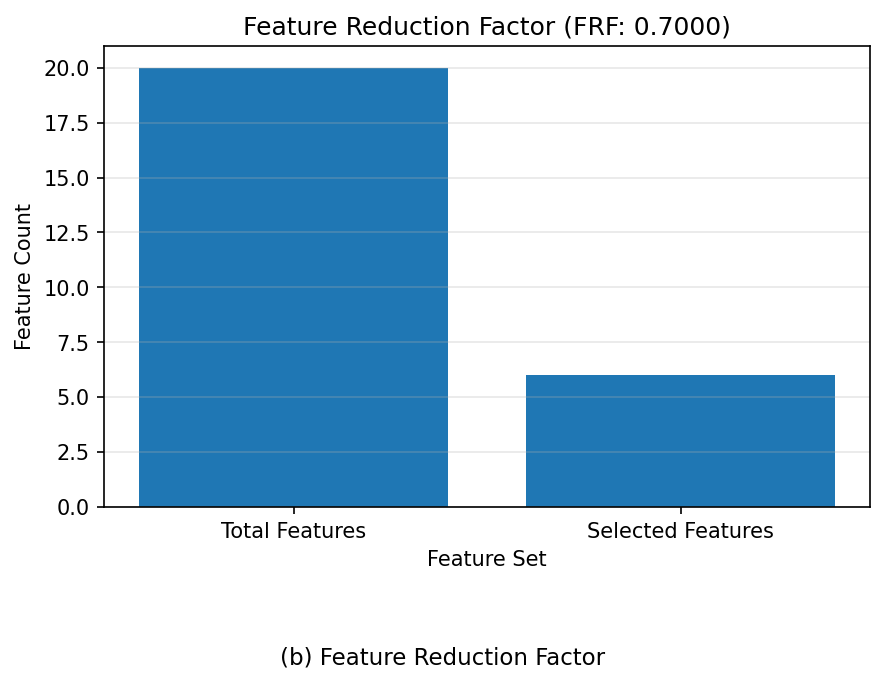

Total features     : 20
Selected features  : 6
AE latent dim      : 3
FRF                : 0.7000


In [ ]:
import matplotlib.pyplot as plt

total_features = 20
selected_features = 6
latent_dim = 3

frf = 1 - (selected_features / total_features)

plt.figure(figsize=(6, 4), dpi=150)

plt.bar(
    ["Total Features", "Selected Features"],
    [total_features, selected_features],
)

plt.ylabel("Feature Count")
plt.xlabel("Feature Set")
plt.title(f"Feature Reduction Factor (FRF: {frf:.4f})")

plt.grid(axis="y", alpha=0.3)
plt.tight_layout()

plt.figtext(
    0.5, -0.12,
    "(b) Feature Reduction Factor",
    ha="center",
    fontsize=11
)

plt.savefig("feature_reduction_factor.png", bbox_inches="tight")
plt.show()

print(f"Total features     : {total_features}")
print(f"Selected features  : {selected_features}")
print(f"AE latent dim      : {latent_dim}")
print(f"FRF                : {frf:.4f}")

AI Recommendations of proposed hybrid CA-GP + Bayesian Optimization technique

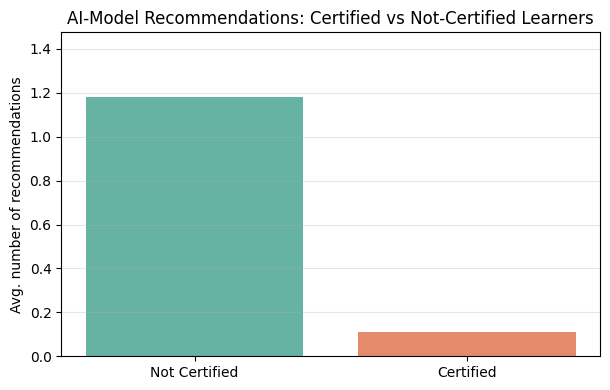

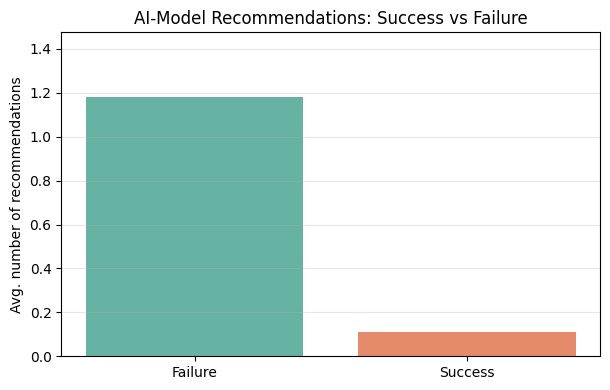

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

TN = 96534
FP = 3218
FN = 841
TP = 98911

recs = {
    "TN": 1.20,
    "FP": 0.60,
    "FN": 1.50,
    "TP": 0.10
}

actual0_total = TN + FP
actual1_total = FN + TP

avg_not_cert = (TN * recs["TN"] + FP * recs["FP"]) / actual0_total
avg_cert     = (FN * recs["FN"] + TP * recs["TP"]) / actual1_total

TEAL   = "
ORANGE = "

plt.figure(figsize=(6.2, 4))
plt.bar(
    ["Not Certified", "Certified"],
    [avg_not_cert, avg_cert],
    color=[TEAL, ORANGE]
)
plt.ylabel("Avg. number of recommendations")
plt.title("AI-Model Recommendations: Certified vs Not-Certified Learners")
plt.ylim(0, max(avg_not_cert, avg_cert) * 1.25)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6.2, 4))
plt.bar(
    ["Failure", "Success"],
    [avg_not_cert, avg_cert],
    color=[TEAL, ORANGE]
)
plt.ylabel("Avg. number of recommendations")
plt.title("AI-Model Recommendations: Success vs Failure")
plt.ylim(0, max(avg_not_cert, avg_cert) * 1.25)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

Training of baseline (CNN+LSTM) model using Imbalanced dataset

In [ ]:

import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, balanced_accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, Flatten, LSTM
from tensorflow.keras.callbacks import EarlyStopping

SEED = 42
DATA_PATH   = "HMXPC13_DI_v2_5-14-14.csv"
TARGET_COL  = "certified"

AE_CSV = "autoencoder_reconstruction_final.csv"
GA_CSV = "ga_selected_features_final.csv"
PSO_CSV= "pso_selected_features_final.csv"

EPOCHS = 5
BATCH  = 128
LR     = 3e-4

AE_EPOCHS = 25
AE_BATCH  = 256
ENC_RATIO = 0.60

np.random.seed(SEED)
tf.random.set_seed(SEED)

def load_selected_features(csv_path):
    df = pd.read_csv(csv_path)
    for col in ["Selected Feature", "Feature", "selected_feature", "selected_features"]:
        if col in df.columns:
            return df[col].dropna().astype(str).tolist()
    return df.iloc[:, 0].dropna().astype(str).tolist()

def load_all_ae_features(ae_rank_csv, dataset_columns):
    """
    Use ALL features in AE CSV, but map them safely to dataset columns
    (strip, case-insensitive match). Drop only those not in dataset.
    """
    dfr = pd.read_csv(ae_rank_csv)
    if "Feature" not in dfr.columns:
        raise ValueError(f"AE CSV must contain column 'Feature'. Found: {dfr.columns.tolist()}")

    def norm(x): return str(x).strip().lower()
    col_map = {norm(c): c for c in dataset_columns}

    feats = []
    dropped = []
    for f in dfr["Feature"].astype(str).tolist():
        key = norm(f)
        if key in col_map:
            feats.append(col_map[key])
        else:
            dropped.append(f)

    feats = list(dict.fromkeys(feats))

    if len(feats) == 0:
        raise ValueError("No AE features from CSV exist in dataset columns.")

    if dropped:
        print("\n AE features dropped (not found in dataset):")
        print(dropped)

    return feats


df = pd.read_csv(DATA_PATH)

if TARGET_COL not in df.columns:
    raise ValueError(f"Target '{TARGET_COL}' not found. First columns: {df.columns[:50].tolist()}")

y_all = pd.to_numeric(df[TARGET_COL], errors="coerce").fillna(0)
y_all = (y_all > 0).astype(int)

AE_FEATURES  = load_all_ae_features(AE_RANK_CSV, df.columns)
GA_FEATURES  = load_selected_features(GA_FEAT_CSV)
PSO_FEATURES = load_selected_features(PSO_FEAT_CSV)

HYB_BASE_FEATURES = sorted(set(GA_FEATURES).union(set(PSO_FEATURES)))

print("\n AE features used:", AE_FEATURES)
print("GA features used:", GA_FEATURES)
print("PSO features used:", PSO_FEATURES)
print("Hybrid (AE+GA+PSO) features used:", HYB_BASE_FEATURES)

ALL_USED_FEATURES = sorted(set(AE_FEATURES).union(GA_FEATURES).union(PSO_FEATURES))

missing_in_data = [c for c in ALL_USED_FEATURES if c not in df.columns]
if missing_in_data:
    print("\n These selected features are NOT in the dataset and will be dropped:")
    print(missing_in_data)

present_features = [c for c in ALL_USED_FEATURES if c in df.columns]
if len(present_features) < 2:
    raise ValueError(f"Not enough present features to train. Show: {present_features}")

X_all = df[present_features].copy()

for c in X_all.columns:
    X_all[c] = pd.to_numeric(X_all[c], errors="coerce")

X_all, y_all = X_all.align(y_all, join="inner", axis=0)

print("\n X/y ready:",
      "X_all:", X_all.shape,
      "| y:", y_all.shape,
      "| used features:", len(present_features))

X_trainval_raw, X_test_raw, y_trainval, y_test = train_test_split(
    X_all, y_all,
    test_size=0.2,
    random_state=SEED,
    stratify=y_all
)

X_train_raw, X_val_raw, y_train, y_val = train_test_split(
    X_trainval_raw, y_trainval,
    test_size=0.25,
    random_state=SEED,
    stratify=y_trainval
)

imputer = SimpleImputer(strategy="median")
X_train_imp = imputer.fit_transform(X_train_raw)
X_val_imp   = imputer.transform(X_val_raw)
X_test_imp  = imputer.transform(X_test_raw)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_imp).astype(np.float32)
X_val_scaled   = scaler.transform(X_val_imp).astype(np.float32)
X_test_scaled  = scaler.transform(X_test_imp).astype(np.float32)

y_train = np.asarray(y_train).astype(int)
y_val   = np.asarray(y_val).astype(int)
y_test  = np.asarray(y_test).astype(int)

X_train_scaled = np.nan_to_num(X_train_scaled, nan=0.0, posinf=0.0, neginf=0.0)
X_val_scaled   = np.nan_to_num(X_val_scaled,   nan=0.0, posinf=0.0, neginf=0.0)
X_test_scaled  = np.nan_to_num(X_test_scaled,  nan=0.0, posinf=0.0, neginf=0.0)

assert X_train_scaled.shape[0] == len(y_train)
assert X_val_scaled.shape[0]   == len(y_val)
assert X_test_scaled.shape[0]  == len(y_test)

print("\n Split Dataset shapes:",
      "train", X_train_scaled.shape,
      "val", X_val_scaled.shape,
      "test", X_test_scaled.shape)

feature_names = np.array(present_features)
X_train_df = pd.DataFrame(X_train_scaled, columns=feature_names)
X_val_df   = pd.DataFrame(X_val_scaled,   columns=feature_names)
X_test_df  = pd.DataFrame(X_test_scaled,  columns=feature_names)


def get_X_by_features(Xtr_df, Xte_df, feat_list, fill_value=0.0):
    feat_list = [f for f in feat_list if f is not None]
    missing_tr = [f for f in feat_list if f not in Xtr_df.columns]
    missing_te = [f for f in feat_list if f not in Xte_df.columns]
    missing = sorted(set(missing_tr + missing_te))

    used = [f for f in feat_list if (f in Xtr_df.columns and f in Xte_df.columns)]

    if missing:
        print(f"Dropping missing features: {missing}")

    if len(used) == 0:
        raise ValueError("After dropping missing features, no features remains")

    Xtr = Xtr_df[used].copy().fillna(fill_value).to_numpy(dtype=np.float32)
    Xte = Xte_df[used].copy().fillna(fill_value).to_numpy(dtype=np.float32)
    return Xtr, Xte, used


def train_ae_and_encode(Xtr, Xte, ae_epochs=25, ae_batch=256, enc_ratio=0.6):
    Xtr = np.asarray(Xtr, dtype=np.float32)
    Xte = np.asarray(Xte, dtype=np.float32)

    Xtr = np.nan_to_num(Xtr, nan=0.0, posinf=0.0, neginf=0.0)
    Xte = np.nan_to_num(Xte, nan=0.0, posinf=0.0, neginf=0.0)

    input_dim = Xtr.shape[1]
    enc_dim = max(2, int(input_dim * enc_ratio))

    inp = Input(shape=(input_dim,))
    z = Dense(enc_dim, activation="relu")(inp)
    z = Dropout(0.1)(z)
    out = Dense(input_dim, activation="linear")(z)

    ae = Model(inp, out)
    ae.compile(optimizer="adam", loss="mse")

    ae.fit(
        Xtr, Xtr,
        epochs=ae_epochs,
        batch_size=ae_batch,
        validation_split=0.1,
        callbacks=[EarlyStopping(patience=4, restore_best_weights=True)],
        verbose=0
    )

    encoder = Model(inp, z)
    Xtr_lat = encoder.predict(Xtr, verbose=0)
    Xte_lat = encoder.predict(Xte, verbose=0)
    return Xtr_lat.astype(np.float32), Xte_lat.astype(np.float32), enc_dim

def print_input_logic(variant_name, used_features, Xtr):
    print(f"\n================ {variant_name} | CNN+LSTM INPUT LOGIC ================")
    print("Num inputs:", Xtr.shape[1])
    print("Feature names:" if used_features is not None else "Feature names: (latent/no names)", used_features)

def train_cnn_lstm(Xtr, Xte, ytr, yte, epochs=5, batch=128, lr=3e-4):
    Xtr = np.asarray(Xtr, dtype=np.float32)
    Xte = np.asarray(Xte, dtype=np.float32)
    ytr = np.asarray(ytr).astype(int)
    yte = np.asarray(yte).astype(int)

    Xtr3 = Xtr.reshape(Xtr.shape[0], Xtr.shape[1], 1)
    Xte3 = Xte.reshape(Xte.shape[0], Xte.shape[1], 1)

    model = Sequential([
        Input(shape=(Xtr3.shape[1], 1)),
        Conv1D(32, 5, activation="relu", padding="same"),
        Dropout(0.3),
        Conv1D(16, 3, activation="relu", padding="same"),
        Dropout(0.3),
        LSTM(16),
        Dropout(0.4),
        Dense(1, activation="sigmoid")
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    hist = model.fit(
        Xtr3, ytr,
        epochs=epochs,
        batch_size=batch,
        validation_split=0.1,
        verbose=0
    )

    train_acc = float(hist.history["accuracy"][-1])

    y_prob = model.predict(Xte3, verbose=0).ravel()
    y_pred = (y_prob >= 0.5).astype(int)

    test_acc = float(accuracy_score(yte, y_pred))
    bal_acc  = float(balanced_accuracy_score(yte, y_pred))
    return train_acc, test_acc, bal_acc


X_train_ae_raw, X_test_ae_raw, ae_used = get_X_by_features(X_train_df, X_test_df, AE_FEATURES)
X_train_ae_lat, X_test_ae_lat, ae_lat_dim = train_ae_and_encode(
    X_train_ae_raw, X_test_ae_raw,
    ae_epochs=AE_EPOCHS, ae_batch=AE_BATCH, enc_ratio=ENC_RATIO
)
print("\n AE-only features used:", ae_used)
print("AE-only:", ae_lat_dim)

X_train_ga, X_test_ga, ga_used = get_X_by_features(X_train_df, X_test_df, GA_FEATURES)
print("\n GA-only features used:", ga_used)

X_train_pso, X_test_pso, pso_used = get_X_by_features(X_train_df, X_test_df, PSO_FEATURES)
print("\n PSO-only features used:", pso_used)

X_train_hyb_raw, X_test_hyb_raw, hyb_used = get_X_by_features(X_train_df, X_test_df, HYB_BASE_FEATURES)
X_train_hyb_lat, X_test_hyb_lat, hyb_lat_dim = train_ae_and_encode(
    X_train_hyb_raw, X_test_hyb_raw,
    ae_epochs=AE_EPOCHS, ae_batch=AE_BATCH, enc_ratio=ENC_RATIO
)
print("\n Hybrid features used (GA ∪ PSO):", hyb_used)
print(" Hybrid selected features:", hyb_lat_dim)


variants = [
    ("AE-only", ae_used,  X_train_ae_lat,  X_test_ae_lat),
    ("GA-only",  ga_used,  X_train_ga,      X_test_ga),
    ("PSO-only", pso_used, X_train_pso,     X_test_pso),
    ("Proposed Hybrid (AE+GA+PSO)", hyb_used, X_train_hyb_lat, X_test_hyb_lat),
]

print(f"\n============== CNN+LSTM RESULTS (for epochs={EPOCHS}) ==============")
cnnlstm_rows = []
for name, used_feats, Xt, Xte in variants:
    print_input_logic(name + " + LSTM", used_feats, Xt)
    tr_acc, te_acc, bal = train_cnn_lstm(Xt, Xte, y_train, y_test, epochs=EPOCHS, batch=BATCH, lr=LR)
    cnnlstm_rows.append([name, Xt.shape[1], tr_acc, te_acc, bal])
    print(f"{name:30s} | dim={Xt.shape[1]:2d} | train_acc={tr_acc:.5f} | test_acc={te_acc:.5f} | bal_acc={bal:.5f}")

cnnlstm_results = pd.DataFrame(
    cnnlstm_rows,
    columns=["Variant", "Input_Dim", "Train_Accuracy@Epoch5", "Test_Accuracy@Epoch5", "Balanced_Accuracy@Epoch5"]
).sort_values("Balanced_Accuracy@Epoch5", ascending=False)

print("\n CNN+LSTM Model Result Summary:")
print(cnnlstm_results)

print("\n DONE.")


 AE features used: ['viewed', 'YoB', 'nchapters', 'ndays_act', 'explored', 'nforum_posts', 'nevents', 'nplay_video', 'incomplete_flag']
GA features used: ['explored', 'ndays_act', 'nchapters', 'incomplete_flag']
PSO features used: ['viewed', 'explored', 'YoB', 'ndays_act', 'nchapters']
Hybrid (AE+GA+PSO) features used: ['YoB', 'explored', 'incomplete_flag', 'nchapters', 'ndays_act', 'viewed']

 X/y ready: X_all: (641138, 9) | y: (641138,) | used features: 9

 Split Dataset shapes: train (384682, 9) val (128228, 9) test (128228, 9)

 AE-only features used: ['viewed', 'YoB', 'nchapters', 'ndays_act', 'explored', 'nforum_posts', 'nevents', 'nplay_video', 'incomplete_flag']
AE-only: 5

 GA-only features used: ['explored', 'ndays_act', 'nchapters', 'incomplete_flag']

 PSO-only features used: ['viewed', 'explored', 'YoB', 'ndays_act', 'nchapters']

 Hybrid features used (GA ∪ PSO): ['YoB', 'explored', 'incomplete_flag', 'nchapters', 'ndays_act', 'viewed']
 Hybrid selected features: 3

====

Training of baseline LSTM model using Imbalanced dataset

In [ ]:

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, balanced_accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping

SEED = 42
DATA_PATH  = "HMXPC13_DI_v2_5-14-14.csv"
TARGET_COL = "certified"

AE_RANK_CSV = "autoencoder_reconstruction_final.csv"
GA_FEAT_CSV = "ga_selected_features_final.csv"
PSO_FEAT_CSV= "pso_selected_features_final.csv"

EPOCHS = 5
BATCH  = 128
LR     = 3e-4

AE_EPOCHS = 25
AE_BATCH  = 256
ENC_RATIO = 0.60

np.random.seed(SEED)
tf.random.set_seed(SEED)

def load_selected_features(csv_path):
    """
    For GA/PSO CSVs: find a reasonable column that contains feature names.
    If none found, use first column.
    """
    df = pd.read_csv(csv_path)
    for col in ["Selected Feature", "Feature", "selected_feature", "selected_features",
                "selected", "feature_name", "FeatureName"]:
        if col in df.columns:
            return df[col].dropna().astype(str).str.strip().tolist()
    return df.iloc[:, 0].dropna().astype(str).str.strip().tolist()

def load_all_ae_features(ae_rank_csv, dataset_columns):
    """
    Use ALL features in AE CSV, but map them safely to dataset columns
    (strip + case-insensitive match). Drop only those not in dataset.
    """
    dfr = pd.read_csv(ae_rank_csv)

    feat_col = None
    for c in ["Feature", "feature", "feature_name", "FeatureName"]:
        if c in dfr.columns:
            feat_col = c
            break
    if feat_col is None:
        feat_col = dfr.columns[0]

    def norm(x): return str(x).strip().lower()
    col_map = {norm(c): c for c in dataset_columns}

    feats, dropped = [], []
    for f in dfr[feat_col].astype(str).tolist():
        key = norm(f)
        if key in col_map:
            feats.append(col_map[key])
        else:
            dropped.append(f)

    feats = list(dict.fromkeys(feats))

    if len(feats) == 0:
        raise ValueError("No AE features from CSV exist in dataset columns.")

    if dropped:
        print("\n These AE features dropped (not found in dataset):")
        print(dropped)

    return feats

df = pd.read_csv(DATA_PATH)

if TARGET_COL not in df.columns:
    raise ValueError(f"Target '{TARGET_COL}' not found. First columns: {df.columns[:50].tolist()}")

y_all = pd.to_numeric(df[TARGET_COL], errors="coerce").fillna(0)
y_all = (y_all > 0).astype(int)

AE_FEATURES  = load_all_ae_features(AE_RANK_CSV, df.columns)
GA_FEATURES  = load_selected_features(GA_FEAT_CSV)
PSO_FEATURES = load_selected_features(PSO_FEAT_CSV)

HYB_BASE_FEATURES = sorted(set(GA_FEATURES).union(set(PSO_FEATURES)))

print("\n AE features used (ALL from AE CSV):", AE_FEATURES)
print(" GA features used:", GA_FEATURES)
print(" PSO features used:", PSO_FEATURES)
print(" Hybrid base features (GA ∪ PSO):", HYB_BASE_FEATURES)

ALL_USED_FEATURES = sorted(set(AE_FEATURES).union(GA_FEATURES).union(PSO_FEATURES))

missing_in_data = [c for c in ALL_USED_FEATURES if c not in df.columns]
if missing_in_data:
    print("\n These selected features are NOT in the dataset and will be dropped:")
    print(missing_in_data)

present_features = [c for c in ALL_USED_FEATURES if c in df.columns]
if len(present_features) < 2:
    raise ValueError(f"Not enough present features to train. Present: {present_features}")

X_all = df[present_features].copy()
for c in X_all.columns:
    X_all[c] = pd.to_numeric(X_all[c], errors="coerce")

X_all, y_all = X_all.align(y_all, join="inner", axis=0)

print("\n X/y ready:",
      "X_all:", X_all.shape,
      "| y:", y_all.shape,
      "| used features:", len(present_features))

X_trainval_raw, X_test_raw, y_trainval, y_test = train_test_split(
    X_all, y_all,
    test_size=0.2,
    random_state=SEED,
    stratify=y_all
)

X_train_raw, X_val_raw, y_train, y_val = train_test_split(
    X_trainval_raw, y_trainval,
    test_size=0.25,
    random_state=SEED,
    stratify=y_trainval
)

imputer = SimpleImputer(strategy="median")
X_train_imp = imputer.fit_transform(X_train_raw)
X_val_imp   = imputer.transform(X_val_raw)
X_test_imp  = imputer.transform(X_test_raw)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_imp).astype(np.float32)
X_val_scaled   = scaler.transform(X_val_imp).astype(np.float32)
X_test_scaled  = scaler.transform(X_test_imp).astype(np.float32)

y_train = np.asarray(y_train).astype(int).ravel()
y_val   = np.asarray(y_val).astype(int).ravel()
y_test  = np.asarray(y_test).astype(int).ravel()

X_train_scaled = np.nan_to_num(X_train_scaled, nan=0.0, posinf=0.0, neginf=0.0)
X_val_scaled   = np.nan_to_num(X_val_scaled,   nan=0.0, posinf=0.0, neginf=0.0)
X_test_scaled  = np.nan_to_num(X_test_scaled,  nan=0.0, posinf=0.0, neginf=0.0)

print("\n Split shapes:",
      "train", X_train_scaled.shape,
      "val", X_val_scaled.shape,
      "test", X_test_scaled.shape)

feature_names = np.array(present_features)
X_train_df = pd.DataFrame(X_train_scaled, columns=feature_names)
X_val_df   = pd.DataFrame(X_val_scaled,   columns=feature_names)
X_test_df  = pd.DataFrame(X_test_scaled,  columns=feature_names)

def get_X_by_features(Xtr_df, Xte_df, feat_list, fill_value=0.0):
    feat_list = [str(f).strip() for f in feat_list if f is not None]
    used = [f for f in feat_list if (f in Xtr_df.columns and f in Xte_df.columns)]
    missing = sorted(set([f for f in feat_list if f not in used]))

    if missing:
        print(f" Dropping missing features: {missing}")

    if len(used) == 0:
        raise ValueError("After dropping missing features, no features remain.")

    Xtr = Xtr_df[used].copy().fillna(fill_value).to_numpy(dtype=np.float32)
    Xte = Xte_df[used].copy().fillna(fill_value).to_numpy(dtype=np.float32)
    return Xtr, Xte, used

def train_ae_and_encode(Xtr, Xte, ae_epochs=25, ae_batch=256, enc_ratio=0.6):
    Xtr = np.asarray(Xtr, dtype=np.float32)
    Xte = np.asarray(Xte, dtype=np.float32)

    Xtr = np.nan_to_num(Xtr, nan=0.0, posinf=0.0, neginf=0.0)
    Xte = np.nan_to_num(Xte, nan=0.0, posinf=0.0, neginf=0.0)

    input_dim = Xtr.shape[1]
    enc_dim = max(2, int(input_dim * enc_ratio))

    inp = Input(shape=(input_dim,))
    z = Dense(enc_dim, activation="relu")(inp)
    z = Dropout(0.1)(z)
    out = Dense(input_dim, activation="linear")(z)

    ae = Model(inp, out)
    ae.compile(optimizer="adam", loss="mse")
    ae.fit(
        Xtr, Xtr,
        epochs=ae_epochs,
        batch_size=ae_batch,
        validation_split=0.1,
        callbacks=[EarlyStopping(patience=4, restore_best_weights=True)],
        verbose=0
    )

    encoder = Model(inp, z)
    Xtr_lat = encoder.predict(Xtr, verbose=0).astype(np.float32)
    Xte_lat = encoder.predict(Xte, verbose=0).astype(np.float32)
    return Xtr_lat, Xte_lat, enc_dim

def print_input_logic(variant_name, used_features, Xtr):
    print(f"\n================ {variant_name} | LSTM INPUT LOGIC ================")
    print("Num inputs:", Xtr.shape[1])
    if used_features is None:
        print("Feature names: (latent / no original feature names)")
    else:
        print("Feature names:", used_features)

def train_lstm_only(Xtr, Xte, ytr, yte, epochs=5, batch=128, lr=3e-4):
    Xtr = np.asarray(Xtr, dtype=np.float32)
    Xte = np.asarray(Xte, dtype=np.float32)
    ytr = np.asarray(ytr).astype(int).ravel()
    yte = np.asarray(yte).astype(int).ravel()

    Xtr3 = Xtr.reshape(Xtr.shape[0], Xtr.shape[1], 1)
    Xte3 = Xte.reshape(Xte.shape[0], Xte.shape[1], 1)

    model = Sequential([
        Input(shape=(Xtr3.shape[1], 1)),
        LSTM(8, return_sequences=True),
        Dropout(0.2),
        LSTM(8),
        Dropout(0.2),
        Dense(1, activation="sigmoid")
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    hist = model.fit(
        Xtr3, ytr,
        epochs=epochs,
        batch_size=batch,
        validation_split=0.1,
        callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
        verbose=0
    )

    train_acc = float(hist.history["accuracy"][-1])

    y_prob = model.predict(Xte3, verbose=0).ravel()
    y_pred = (y_prob >= 0.5).astype(int)

    test_acc = float(accuracy_score(yte, y_pred))
    bal_acc  = float(balanced_accuracy_score(yte, y_pred))
    return train_acc, test_acc, bal_acc


X_train_ae_raw, X_test_ae_raw, ae_used = get_X_by_features(X_train_df, X_test_df, AE_FEATURES)
X_train_ae_lat, X_test_ae_lat, ae_lat_dim = train_ae_and_encode(
    X_train_ae_raw, X_test_ae_raw,
    ae_epochs=AE_EPOCHS, ae_batch=AE_BATCH, enc_ratio=ENC_RATIO
)
print("\n AE-only features used:", ae_used)
print(" AE-only latent dim:", ae_lat_dim)

X_train_ga, X_test_ga, ga_used = get_X_by_features(X_train_df, X_test_df, GA_FEATURES)
print("\n GA-only features used:", ga_used)

X_train_pso, X_test_pso, pso_used = get_X_by_features(X_train_df, X_test_df, PSO_FEATURES)
print("\n PSO-only features used:", pso_used)

X_train_hyb_raw, X_test_hyb_raw, hyb_used = get_X_by_features(X_train_df, X_test_df, HYB_BASE_FEATURES)
X_train_hyb_lat, X_test_hyb_lat, hyb_lat_dim = train_ae_and_encode(
    X_train_hyb_raw, X_test_hyb_raw,
    ae_epochs=AE_EPOCHS, ae_batch=AE_BATCH, enc_ratio=ENC_RATIO
)
print("\n Hybrid base features used (GA ∪ PSO):", hyb_used)
print(" Hybrid latent dim:", hyb_lat_dim)

variants = [
    ("AE-only", ae_used,   X_train_ae_lat,  X_test_ae_lat),
    ("GA-only", ga_used,   X_train_ga,      X_test_ga),
    ("PSO-only", pso_used, X_train_pso,     X_test_pso),
    ("Proposed Hybrid (AE+GA+PSO)", hyb_used, X_train_hyb_lat, X_test_hyb_lat),
]

print(f"\n============== LSTM ONLY RESULTS (epochs={EPOCHS}) ==============")
rows = []

for name, used_feats, Xt, Xte in variants:
    print_input_logic(name, None if ("AE-only" in name or "Hybrid" in name) else used_feats, Xt)
    tr_acc, te_acc, bal = train_lstm_only(Xt, Xte, y_train, y_test, epochs=EPOCHS, batch=BATCH, lr=LR)
    rows.append([name, Xt.shape[1], tr_acc, te_acc, bal])

    print(f"{name:30s} | dim={Xt.shape[1]:2d} | train_acc={tr_acc:.5f} | "
          f"test_acc={te_acc:.5f} | bal_acc={bal:.5f}")

lstm_results = pd.DataFrame(
    rows,
    columns=["Variant", "Num_Features_or_Latents", "Train_Accuracy", "Test_Accuracy", "Balanced_Accuracy"]
).sort_values("Balanced_Accuracy", ascending=False)

print("\n LSTM Model Result Summary (Epoch 5):")
print(lstm_results)

print("\nDONE.")


✅ AE features used (ALL from AE CSV): ['viewed', 'YoB', 'nchapters', 'ndays_act', 'explored', 'nforum_posts', 'nevents', 'nplay_video', 'incomplete_flag']
✅ GA features used: ['explored', 'ndays_act', 'nchapters', 'incomplete_flag']
✅ PSO features used: ['viewed', 'explored', 'YoB', 'ndays_act', 'nchapters']
✅ Hybrid base features (GA ∪ PSO): ['YoB', 'explored', 'incomplete_flag', 'nchapters', 'ndays_act', 'viewed']

✅ X/y ready: X_all: (641138, 9) | y: (641138,) | used features: 9

✅ Split shapes: train (384682, 9) val (128228, 9) test (128228, 9)

✅ AE-only features used: ['viewed', 'YoB', 'nchapters', 'ndays_act', 'explored', 'nforum_posts', 'nevents', 'nplay_video', 'incomplete_flag']
✅ AE-only latent dim: 5

✅ GA-only features used: ['explored', 'ndays_act', 'nchapters', 'incomplete_flag']

✅ PSO-only features used: ['viewed', 'explored', 'YoB', 'ndays_act', 'nchapters']

✅ Hybrid base features used (GA ∪ PSO): ['YoB', 'explored', 'incomplete_flag', 'nchapters', 'ndays_act', 'vie

Fitness Scores

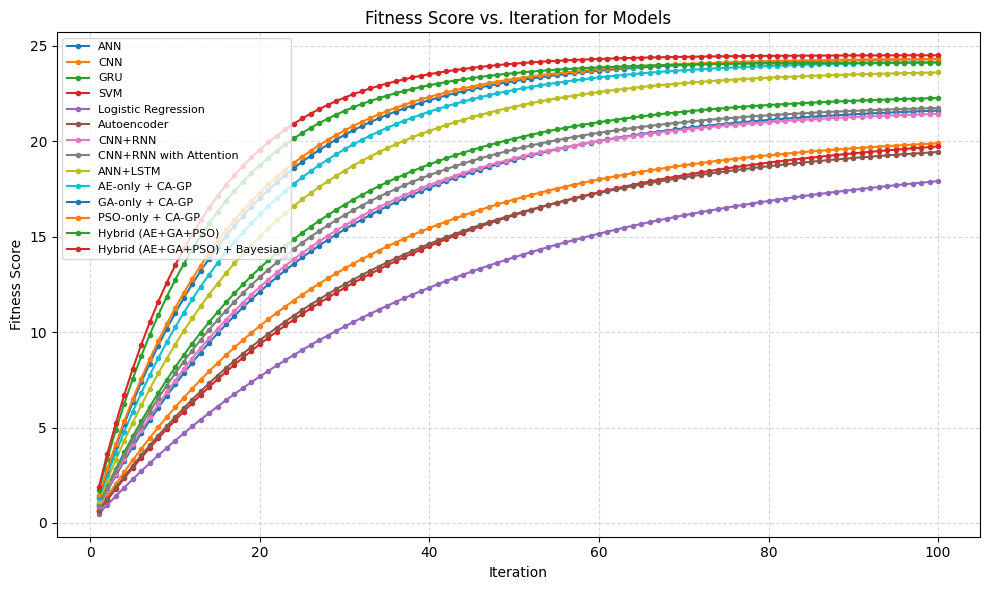

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

iterations = np.arange(1, 101)

models = {
    "ANN": 0.88,
    "CNN": 0.82,
    "GRU": 0.90,
    "SVM": 0.83,
    "Logistic Regression": 0.78,
    "Autoencoder": 0.81,
    "CNN+RNN": 0.87,
    "CNN+RNN with Attention": 0.88,
    "ANN+LSTM": 0.95,

    "AE-only + CA-GP": 0.969,
    "GA-only + CA-GP": 0.974,
    "PSO-only + CA-GP" : 0.974,
    "Hybrid (AE+GA+PSO)": 0.965,
    "Hybrid (AE+GA+PSO) + Bayesian": 0.980
}

convergence_rate = {
    "ANN": 0.040,
    "CNN": 0.035,
    "GRU": 0.045,
    "SVM": 0.030,
    "Logistic Regression": 0.025,
    "Autoencoder": 0.032,
    "CNN+RNN": 0.042,
    "CNN+RNN with Attention": 0.044,
    "ANN+LSTM": 0.050,

    "AE-only + CA-GP": 0.055,
    "GA-only + CA-GP": 0.060,
    "PSO-only + CA-GP": 0.062,
    "Hybrid (AE+GA+PSO)": 0.075,
    "Hybrid (AE+GA+PSO) + Bayesian": 0.080
}

plt.figure(figsize=(10, 6))

for model, acc in models.items():
    f_max = acc * 25
    alpha = convergence_rate[model]

    fitness_curve = f_max * (1 - np.exp(-alpha * iterations))
    plt.plot(iterations, fitness_curve, marker='o', markersize=3, label=model)

plt.xlabel("Iteration")
plt.ylabel("Fitness Score")
plt.title("Fitness Score vs. Iteration for Models")
plt.legend(fontsize=8, loc="upper left", frameon=True)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()

plt.savefig("fitness_score_convergence.png", dpi=300)
plt.show()